In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import csv

#const
k = 1.3806504e-23
hb = 1.0545716e-34
h = (2.0*np.pi*1.0545716e-34) 
c = 2.9979246e+8
#some functions

def cleanSpec(spec, dwV = 525, upwV = 530, dwV1 = 535, upwV1 = 540):
    specdata2 = np.copy(spec)
    upw = np.where(specdata2[:,0] >= upwV)[0][0] 
    dw = np.where(specdata2[:,0] <= dwV)[0][-1] 

    upw1 = np.where(specdata2[:,0] >= upwV1)[0][0] 
    dw1 = np.where(specdata2[:,0] <= dwV1)[0][-1] 
    
    wl = np.concatenate((specdata2[dw:upw,0], specdata2[dw1:upw1,0]))
    val = np.concatenate((specdata2[dw:upw,1], specdata2[dw1:upw1,1]))
    
    popt, pcov = curve_fit(func, wl, val)

    specdata2[upw:dw1,1] = func(specdata2[upw:dw1,0],*popt)
    return specdata2

def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    from math import factorial

    try:
        window_size = np.abs(np.int(window_size))
        order = np.abs(np.int(order))
    except (ValueError, msg):
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

def readSp(specName, delimiter):
    x = np.array([])
    y = np.array([])
    with open(specName, newline='') as f:
        fr = csv.reader(f, delimiter=delimiter, quotechar='|')
        ii = 0
        for row in fr:
            ii += 1
            if ii > 33 and ii < 3682:
                y = np.append(y, row[1])
                x = np.append(x, row[0])
                #print(y, x)
    x = x.astype(np.float)
    y = y.astype(np.float)
    out = np.array([[1,1]])
    ii = -1
    for _ in x:
        ii += 1
        out = np.append(out, [[x[ii],y[ii]]], axis = 0)
    out = out[1:]
    return out

#transmition
def func(x, a, b, c, d, e, f):
     return a + b * x + c * x ** 2 + d * x ** 3 + e * x ** 4 + f * x ** 5 
    
def transM(y, x, trans):
    tx = trans[:, 0]
    ty = trans[:, 1]

    #f = np.vectorize(lambda zz: min(tx, key=lambda z:abs(z-zz)))
    #x1 = f(x)
    #f = np.vectorize(lambda z: np.where(tx == z)[0][0])
    #ind = f(x1)
    #f = np.vectorize(lambda z: ty[z])
    #y1 = f(ind)
    #y11 = y / y1
    #y = y11 / max(y11)
        
    xmin = min(np.where(tx >= min(x))[0])
    xmax = max(np.where(tx <= max(x))[0])
    tx1 = tx[xmin:xmax]
    ty1 = ty[xmin:xmax]
    popt, pcov = curve_fit(func, tx1, 1/ty1)
    y1 = func(x,*popt)
    y1 = (y1 > 0) * y1
    y = y * y1
    y = y 
    
    return y,x

#smoothing
def smooth(x, y, downwl, upwl):
    down = np.where(x >= downwl)[0][0]
    up = np.where(x <= upwl)[0][-1]
    #ysmooth = savitzky_golay(y[down:up], 101, 3)
    ysmooth = savitzky_golay(y[down:up], 81, 2)
    #ysmooth = savitzky_golay(y[down:up], 51, 1)
    yOut = np.copy(y)
    yOut[down:up] = ysmooth
    return yOut

#derivative
def deriv(y, x, dBorder, upBorder, avg = 5):
    derivv = np.zeros(y.shape)
    for i in range(dBorder, upBorder):
        #print(i, dBorder, upBorder)
        for j in range(1, avg + 1):
            derivv[i] += (y[i+j] - y[i-j])/(x[i+j] - x[i-j])
        derivv[i] = derivv[i] / avg
    return derivv
#binning
def avgPlot(xIn, yIn, num):
    while yIn.size%num != 0:
        yIn = yIn[1:]
        xIn = xIn[1:]
    yOut = np.mean(yIn.reshape(-1, num), axis=1)
    xOut = np.mean(xIn.reshape(-1, num), axis=1)
    error = np.std(yIn.reshape(-1, num), axis=1)
    return xOut, yOut, error


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in log


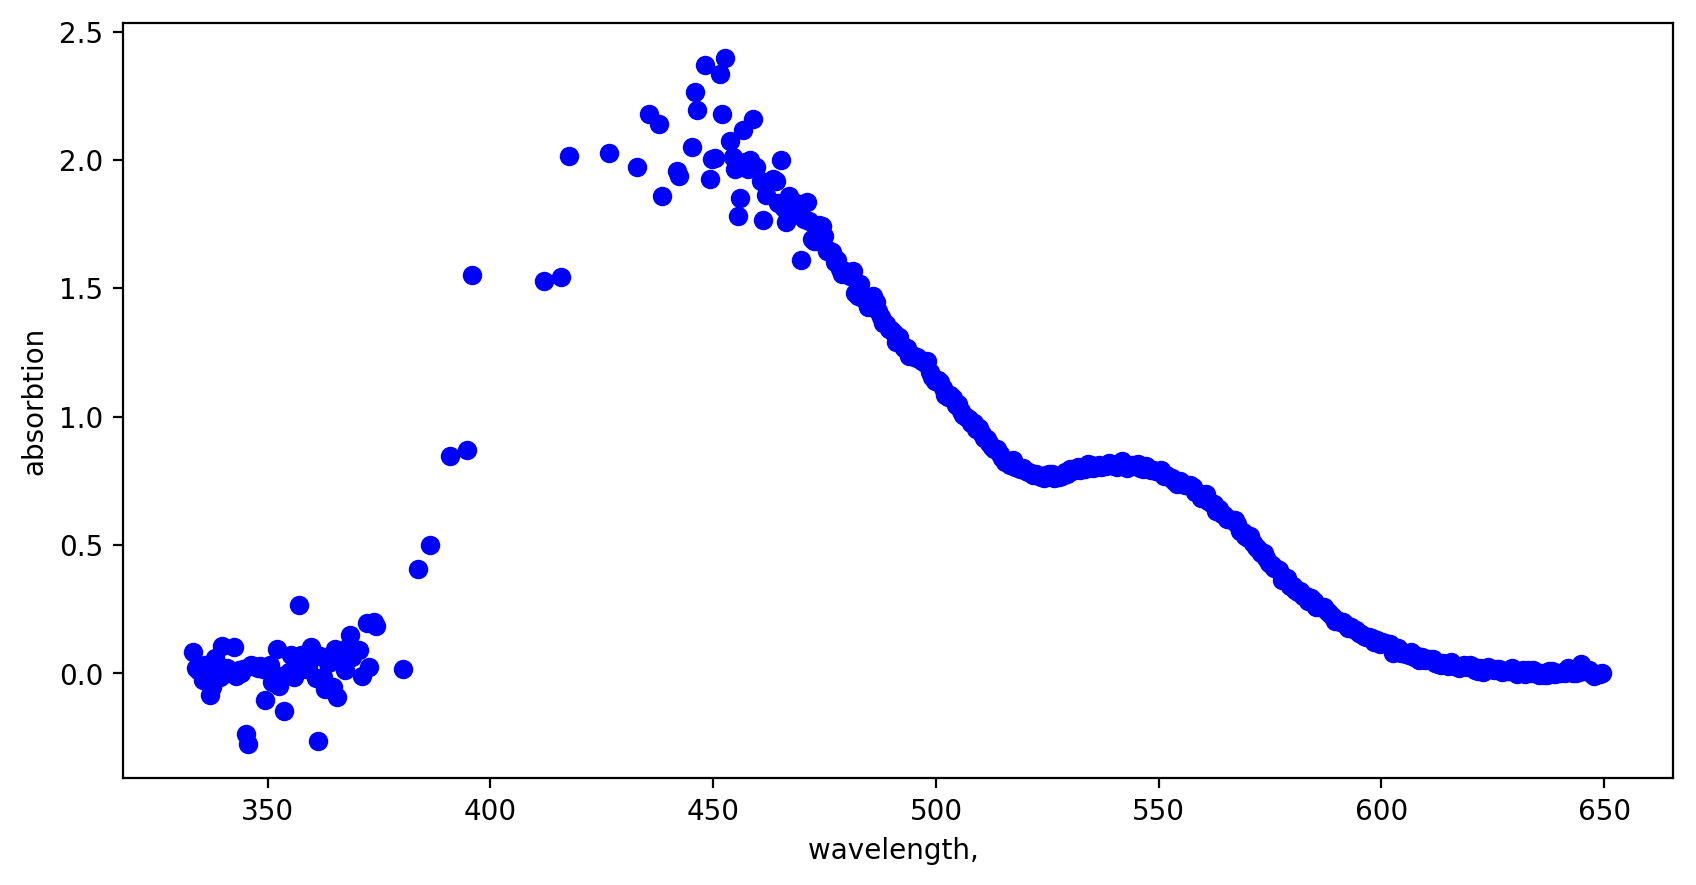

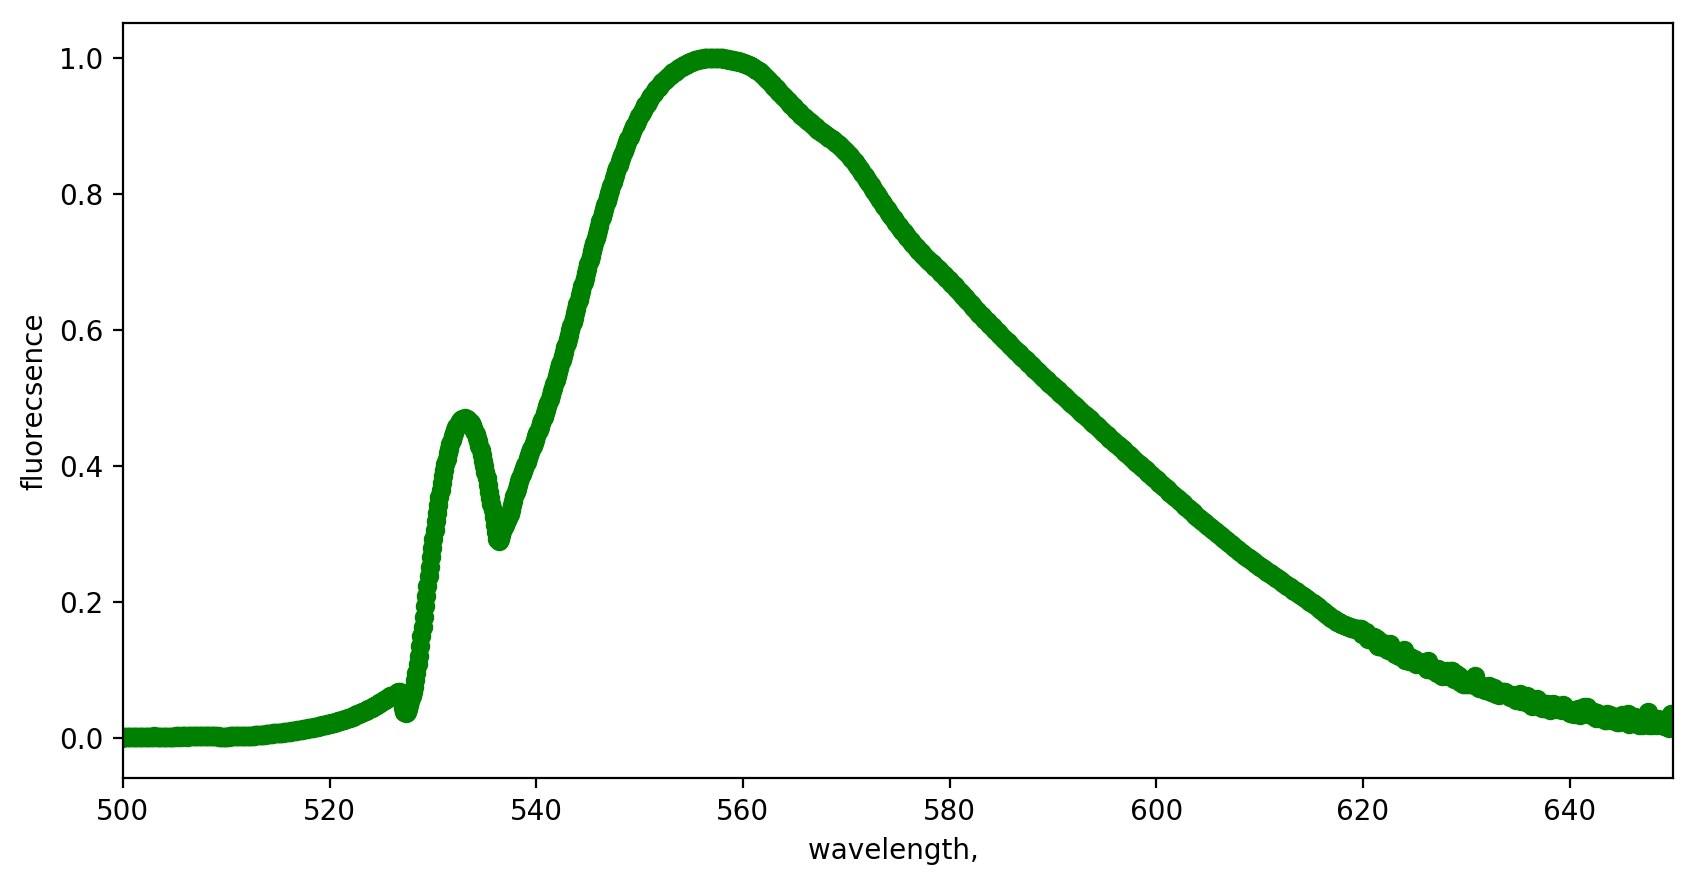

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: RuntimeWarning: invalid value encountered in log


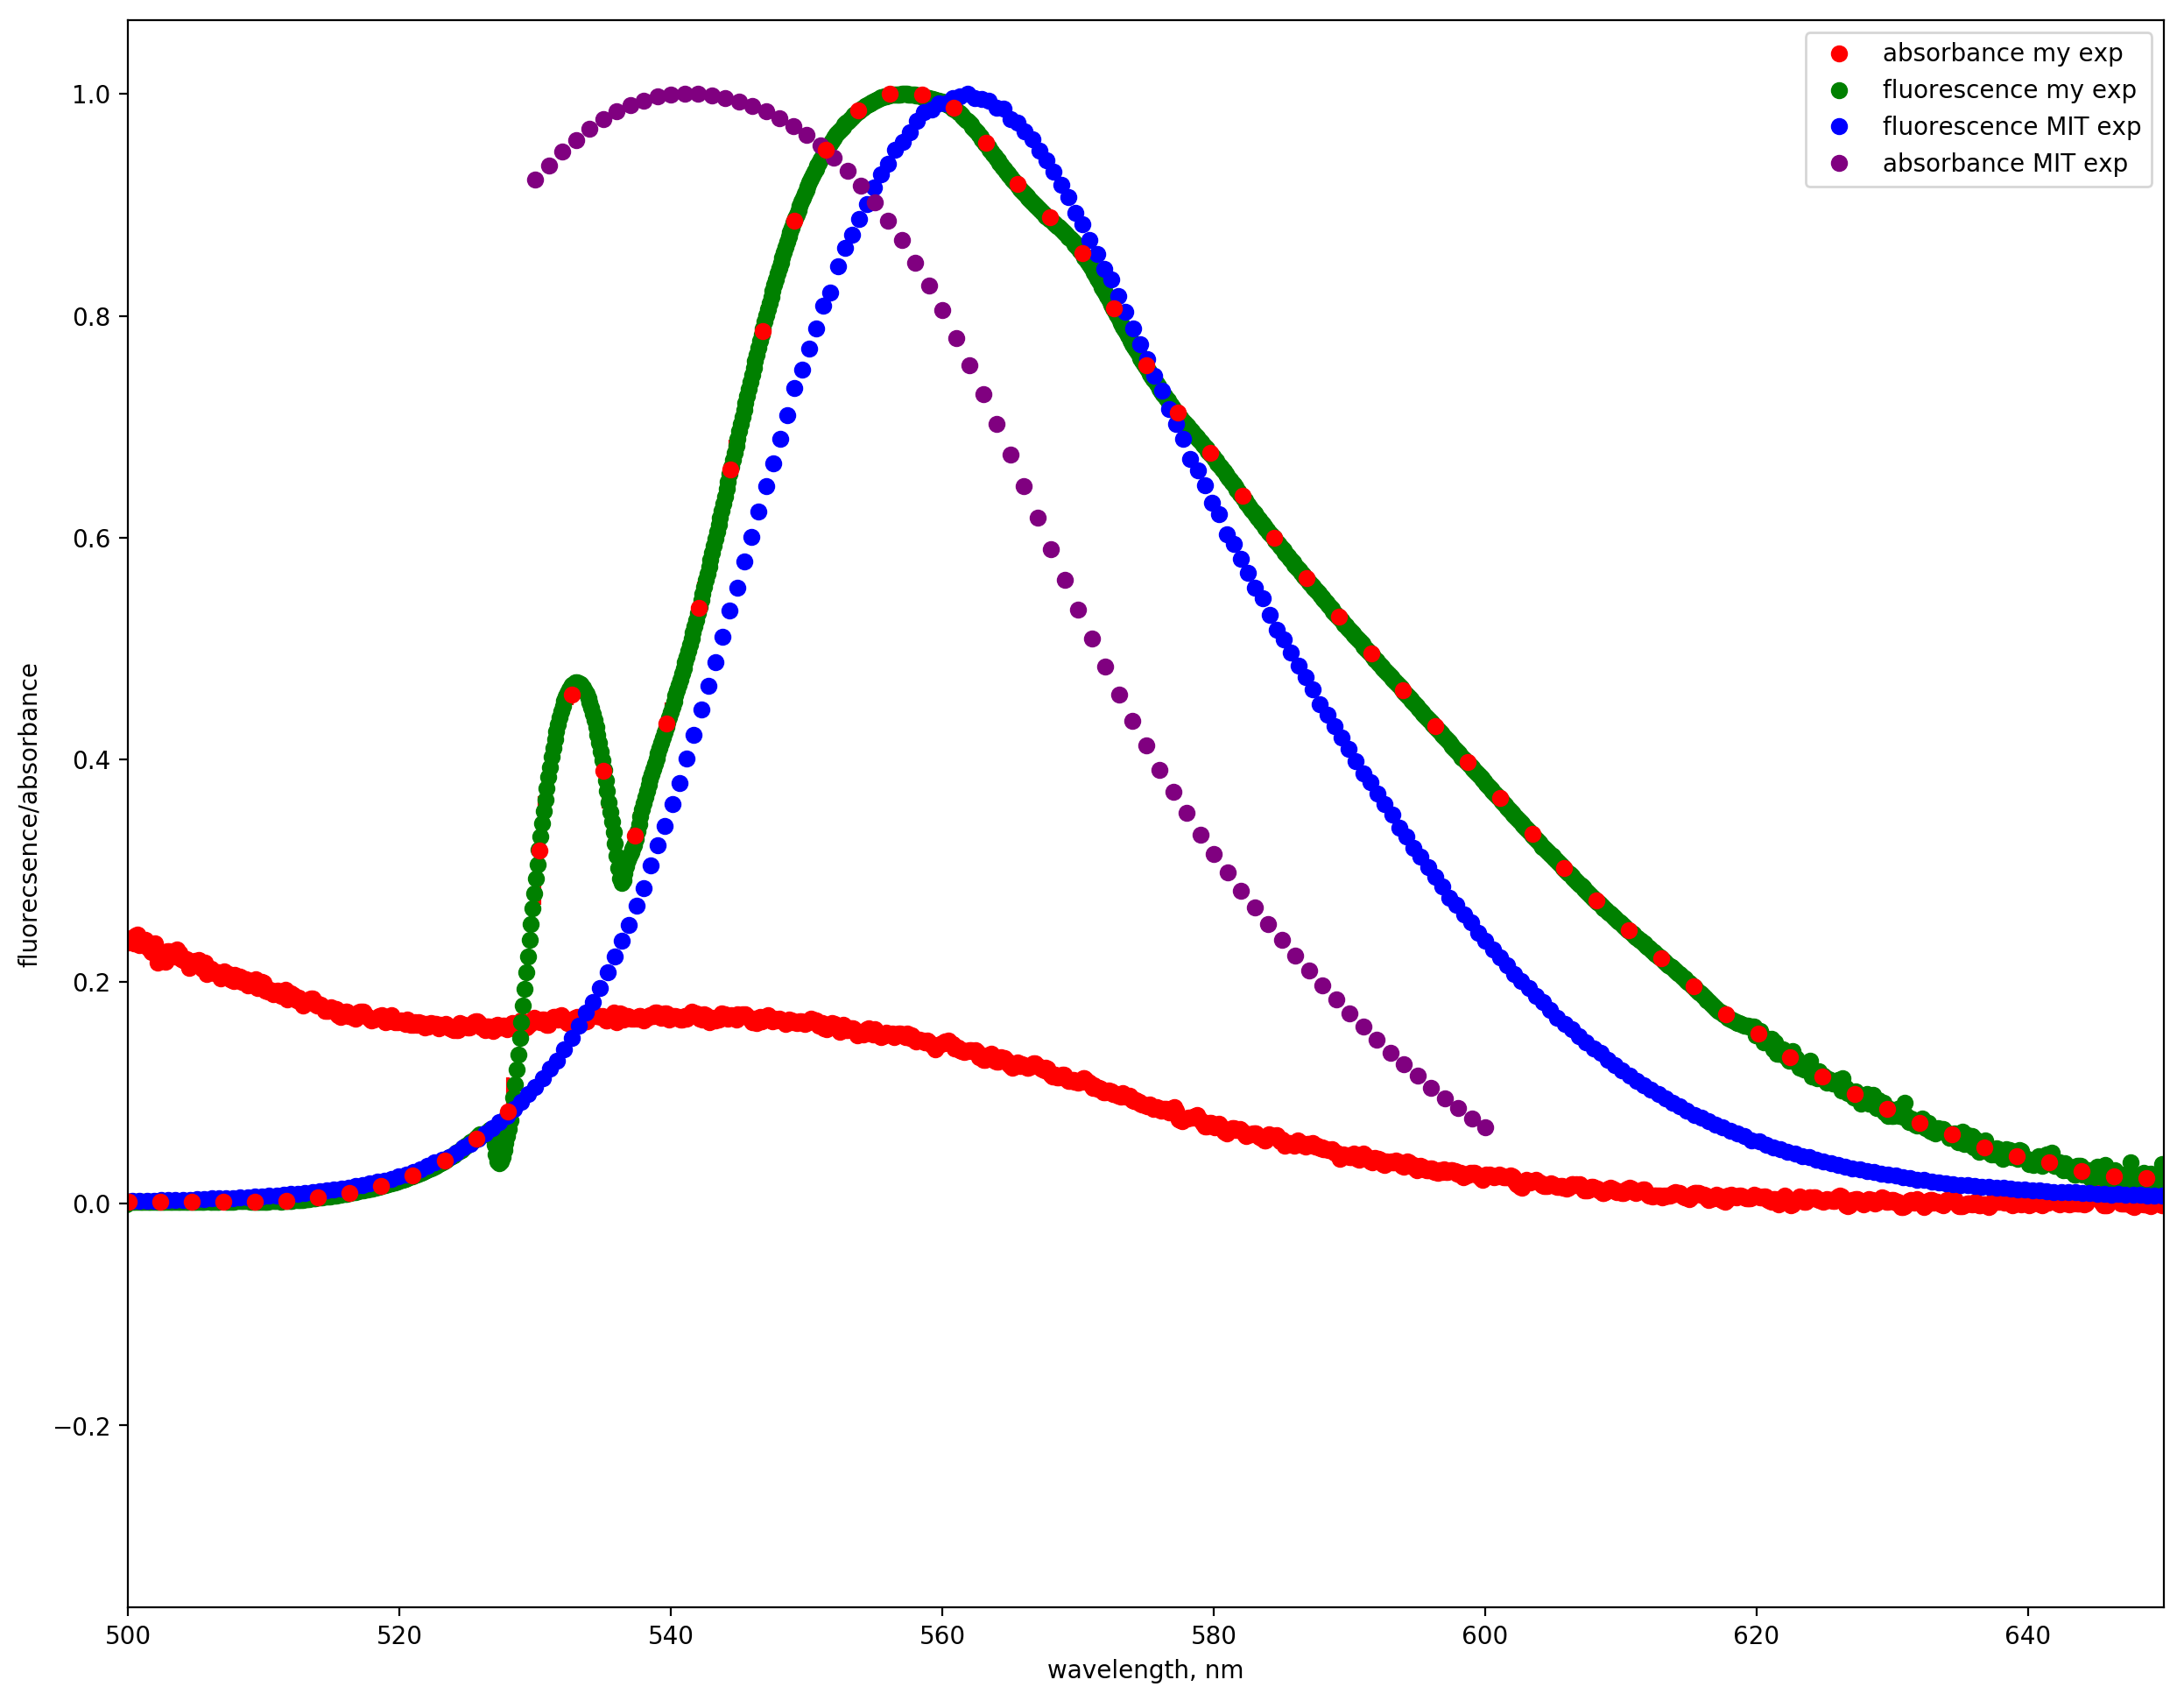

max fluorescence wl 557.0318604
max absorption wl 447.9925232


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in log


In [8]:
#read specs
specdata1 = readSp('MIT_qd1/qd2_a_1_avg10000.csv', ';')
#specdata = readSp('qd1_ocd_2.csv', delimiter = ';')
specdata = readSp('MIT_qd1/qd2_ode_1_avg10000.csv', delimiter = ';')
specdata2 = readSp('MIT_qd1/qd2_f_2.csv', ';')

specdata1 = readSp('MIT_qd1/qd1_byOffset_2/3.csv', ';')
specdata = readSp('MIT_qd1/qd1_byOffset_2/1.csv', delimiter = ';')
specdata2 = readSp('MIT_qd1/qd1/qd1_f_1x100.csv', ';')

rangeWl = np.copy(specdata2[:,0])
specFlur = np.copy(specdata2[:,1])
#specdata = specdata * 0.1 / 0.12

#cutting all less x
cutwl = np.where(rangeWl >= 330)[0][0]
specdata = np.copy(specdata[cutwl:])
specdata1 = np.copy(specdata1[cutwl:])
specdata2 = np.copy(specdata2[cutwl:])
rangeWl = np.copy(rangeWl[cutwl:])

#cutting all more than x

cutwl = np.where(rangeWl <= 650)[0][-1]
specdata = np.copy(specdata[:cutwl])
specdata1 = np.copy(specdata1[:cutwl])
specdata2 = np.copy(specdata2[:cutwl])
rangeWl = np.copy(rangeWl[:cutwl])

#absorption
#yy, xx = transM(specdata2[:,1]*100, specdata2[:,0], np.genfromtxt('QuartzCuvette.csv', delimiter = '\t'))
fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=200, facecolor='w', edgecolor='k')
#ax.plot(specdata[:,0], specdata[:,1], linestyle='', marker='o', color='green')
#ax.plot(specdata1[:,0], specdata1[:,1], linestyle='', marker='o', color='red')
#ax.plot(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1]) / 0.002 , linestyle='', marker='o', color='blue')
#coef = (specdata[:,1] - specdata1[:,1]) / (1 * 0.2 * 1e3)


#ax.plot(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1]) / 2, linestyle='', marker='o', color='blue')
#ax.plot(specdata1[:,0], (specdata[:,1] - specdata1[:,1]) , linestyle='', marker='o', color='blue')
#ax.plot(specdata1[:,0], specdata[:,1], linestyle='', marker='o', color='red')
#ax.plot(specdata1[:,0], specdata1[:,1], linestyle='', marker='o', color='blue')
x,y,err = avgPlot(specdata2[:, 0], np.log(specdata[:,1]/specdata1[:,1]), 5)
ax.plot(x, y/2, linestyle='', marker='o', color='blue')


plt.xlabel('wavelength, ')
plt.ylabel('absorbtion')
#plt.ylim(-0.1,3)
#plt.xlim(510, 600)
#plt.ylim(0,130)
plt.show()

#fluor
#transmition + smooth for pump and 2 strange regions
specdata2[:,1], specdata2[:,0] = transM(specdata2[:,1]*100, specdata2[:,0], np.genfromtxt('QuartzCuvette.csv', delimiter = '\t'))

specdata2[:,1] = smooth(specdata2[:,0], specdata2[:,1], 500, 620)
#specdata2[:,1] = smooth(specdata2[:,0], specdata2[:,1], 563, 569)
#specdata2[:,1] = smooth(specdata2[:,0], specdata2[:,1], 573, 577)

#plot
fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=200, facecolor='w', edgecolor='k')
#ax.plot(xx, yy, linestyle='', marker='o', color='red')

ax.plot(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), linestyle='', marker='o', color='green')
plt.xlabel('wavelength, ')
plt.ylabel('fluorecsence')
#ax.plot(specdataE2[:-100,0], specdataE2[:-100,1]/max(specdataE2[:,1]), linestyle='', marker='o', color='red')

plt.xlim(500, 650)
plt.show()

specdataQDA = np.genfromtxt('fromMit/abs_2', delimiter = '\t')
specdataQDF = np.genfromtxt('fromMit/flur_2', delimiter = '\t')

fig, ax = plt.subplots(num=None, figsize=(15, 12), dpi=200, facecolor='w', edgecolor='k')
ax.plot(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1]) / max(np.log(specdata[:,1]/specdata1[:,1])) , linestyle='', marker='o', color='red')
ax.plot(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), linestyle='', marker='o', color='green')

abswl, absy, abserr = avgPlot(specdata2[:, 0], np.log(specdata[:,1]/specdata1[:,1]), 20)
flwl, fly, flerr = avgPlot(specdata2[:, 0], specdata2[:,1], 20)

ax.errorbar(abswl, absy / max(absy) , yerr=abserr,linestyle='', marker='o', color='red')
ax.errorbar(flwl, fly / max(fly), yerr=flerr, linestyle='', marker='o', color='red')



ax.plot(specdataQDF[:,0], specdataQDF[:,1]/max(specdataQDF[:,1]), linestyle='', marker='o', color='blue')
#ax.plot(x[:,0], x[:,1]/max(x[:,1]), linestyle='', marker='o', color='blue')
ax.plot(specdataQDA[:-180,0], specdataQDA[:-180,1]/max(specdataQDA[:-180,1]), linestyle='', marker='o', color='purple')

plt.xlabel('wavelength, nm')
plt.ylabel('fluorecsence/absorbance')
plt.legend( ('absorbance my exp', 'fluorescence my exp', 'fluorescence MIT exp', 'absorbance MIT exp'))
plt.xlim(500, 650)
#plt.ylim(0,0.4)
plt.show()

print('max fluorescence wl', specdata2[np.where(specdata2[:,1] == max(specdata2[:,1]))[0][0],0])
print('max absorption wl', specdata[np.where(np.log(specdata[:,1]/specdata1[:,1]) == max(np.log(specdata[:,1]/specdata1[:,1])))[0][0],0])




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


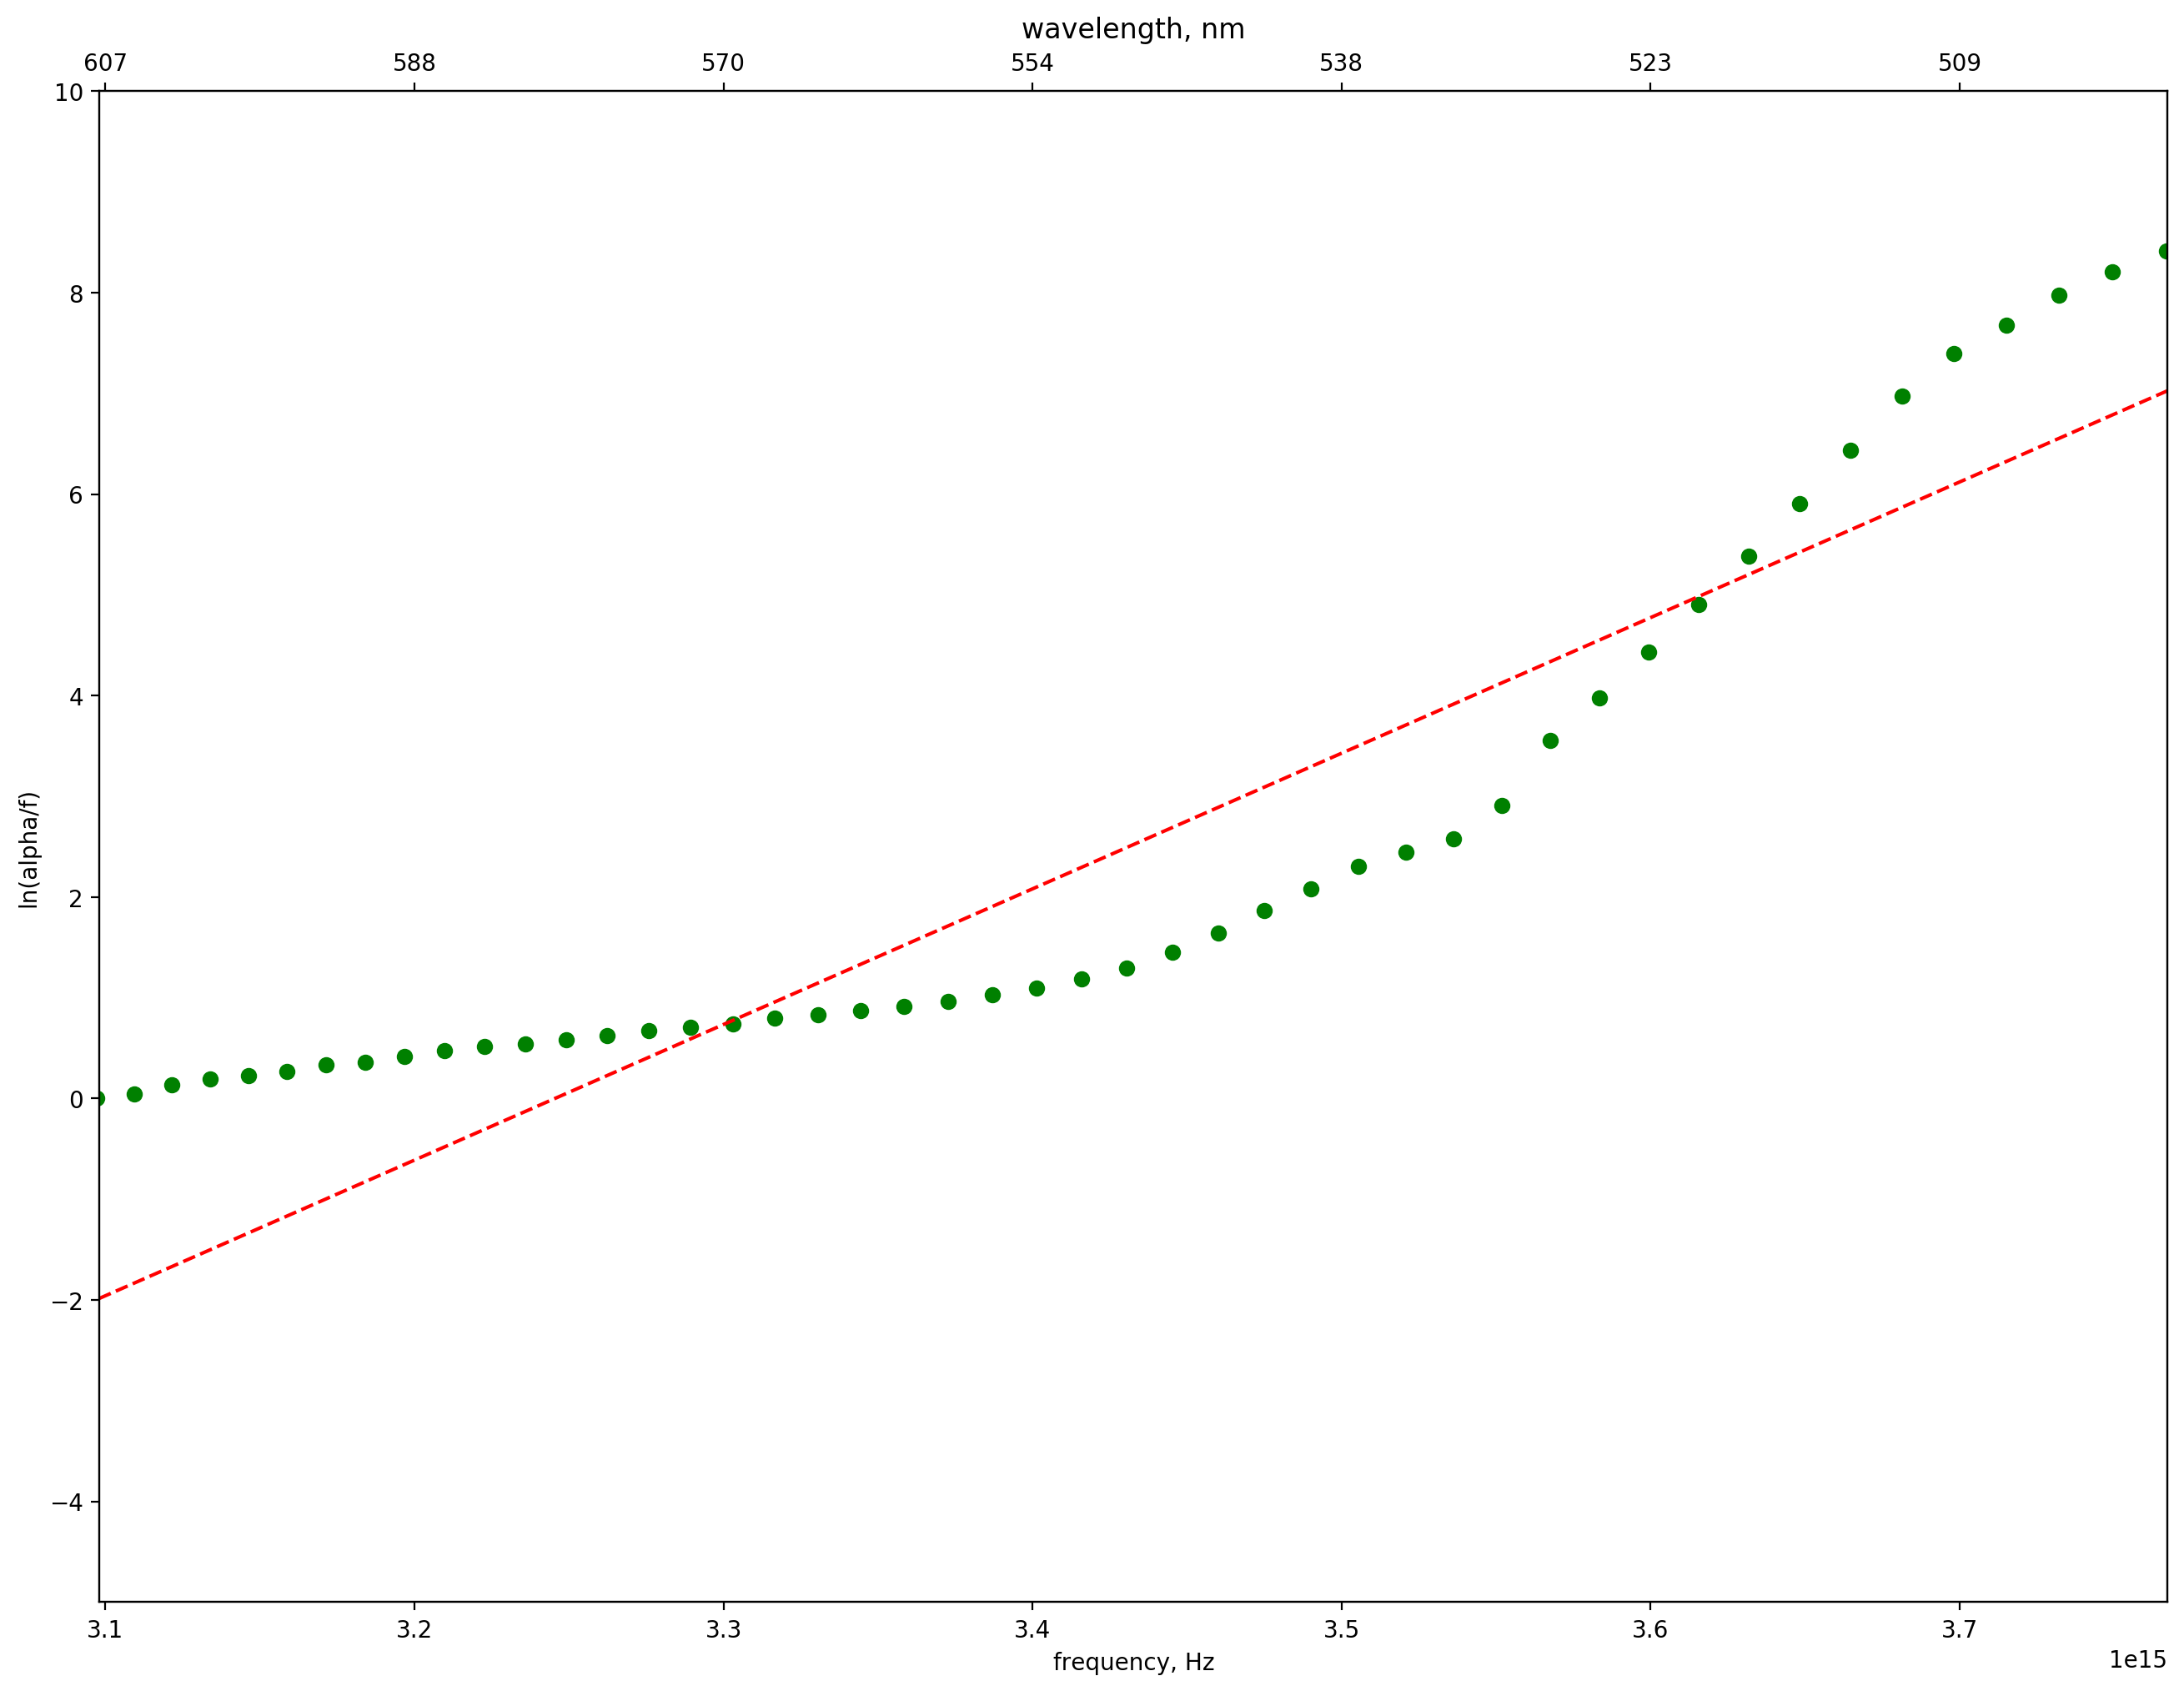

estimated temp 567.2523829245752


In [6]:
alpha = absy 

lolo = (np.log(alpha/fly))

fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=200, facecolor='w', edgecolor='k')
#freq = 2 * np.pi * c / specdata1[:,0] * 1e+9
#ax.plot(specdata2[:,0], lolo, linestyle='', marker='o', color='blue')
#ax.plot(specdata2[:,0], popt[0]*(2 * np.pi * c * 1e+9 / specdata2[:,0]) + popt[1], linestyle='', marker='o', color='green')
#ax.plot(alpha, specdata2[:,1], linestyle='', marker='o', color='blue')
plt.xlabel('frequency, Hz')
plt.ylabel('ln(alpha/f)')
#plt.xlim(520, 590)
#plt.ylim(4, 8)

#plt.xlim(3.4 * 1e+15, 3.5 * 1e+15)

#alpha = specdata[:,1] - specdata1[:,1]
#lolo = np.log(alpha2/specdata2[:,1])

dwV = 2 * np.pi * c / 500 * 1e+9
upwV = 2 * np.pi * c /  600 * 1e+9
freq = 2 * np.pi * c / flwl * 1e+9
upw = np.where(freq >= upwV)[0][-1] 
dw = np.where(freq <= dwV)[0][0] 
def func(x, a, b):
    return x * a + b
lolo = np.nan_to_num(lolo)
popt, pcov = curve_fit(func,   freq[dw:upw], (lolo[dw:upw]))

#ax.plot(specdata2[:,0], func(freq[:], *popt), linestyle='--', marker='', color='green')

ax.plot(freq[:], lolo, linestyle='', marker='o', color='green')
ax.plot(freq[:], func(freq[:], *popt), linestyle='--', marker='', color='red')

#ax.plot(freq[:], np.log(alpha * freq** 3 / specdata2[:, 1]), linestyle='', marker='o', color='red')
#ax.plot(freq[:], deriv(np.log(alpha * freq** 3 / specdata2[:, 1]), freq, dw, upw), linestyle='', marker='o', color='red')

plt.xlim(2 * np.pi * c /  608 * 1e+9, 2 * np.pi * c /  500 * 1e+9)
plt.ylim(-5,10)
ax2 = ax.twiny()
ax1Xs = ax.get_xticks()

ax2Xs = []
for X in ax1Xs:
    ax2Xs.append(int(2 * np.pi * c * 1e+9/X))

ax2.set_xticks(ax1Xs)
ax2.set_xbound(ax.get_xbound())
ax2.set_xticklabels(ax2Xs)
ax2.set_title('wavelength, nm')



plt.show()
#spec temperature  
print('estimated temp', hb  /(k * popt[0]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


avg temp: 1030.5719201132792
std temp 700.8181184680332


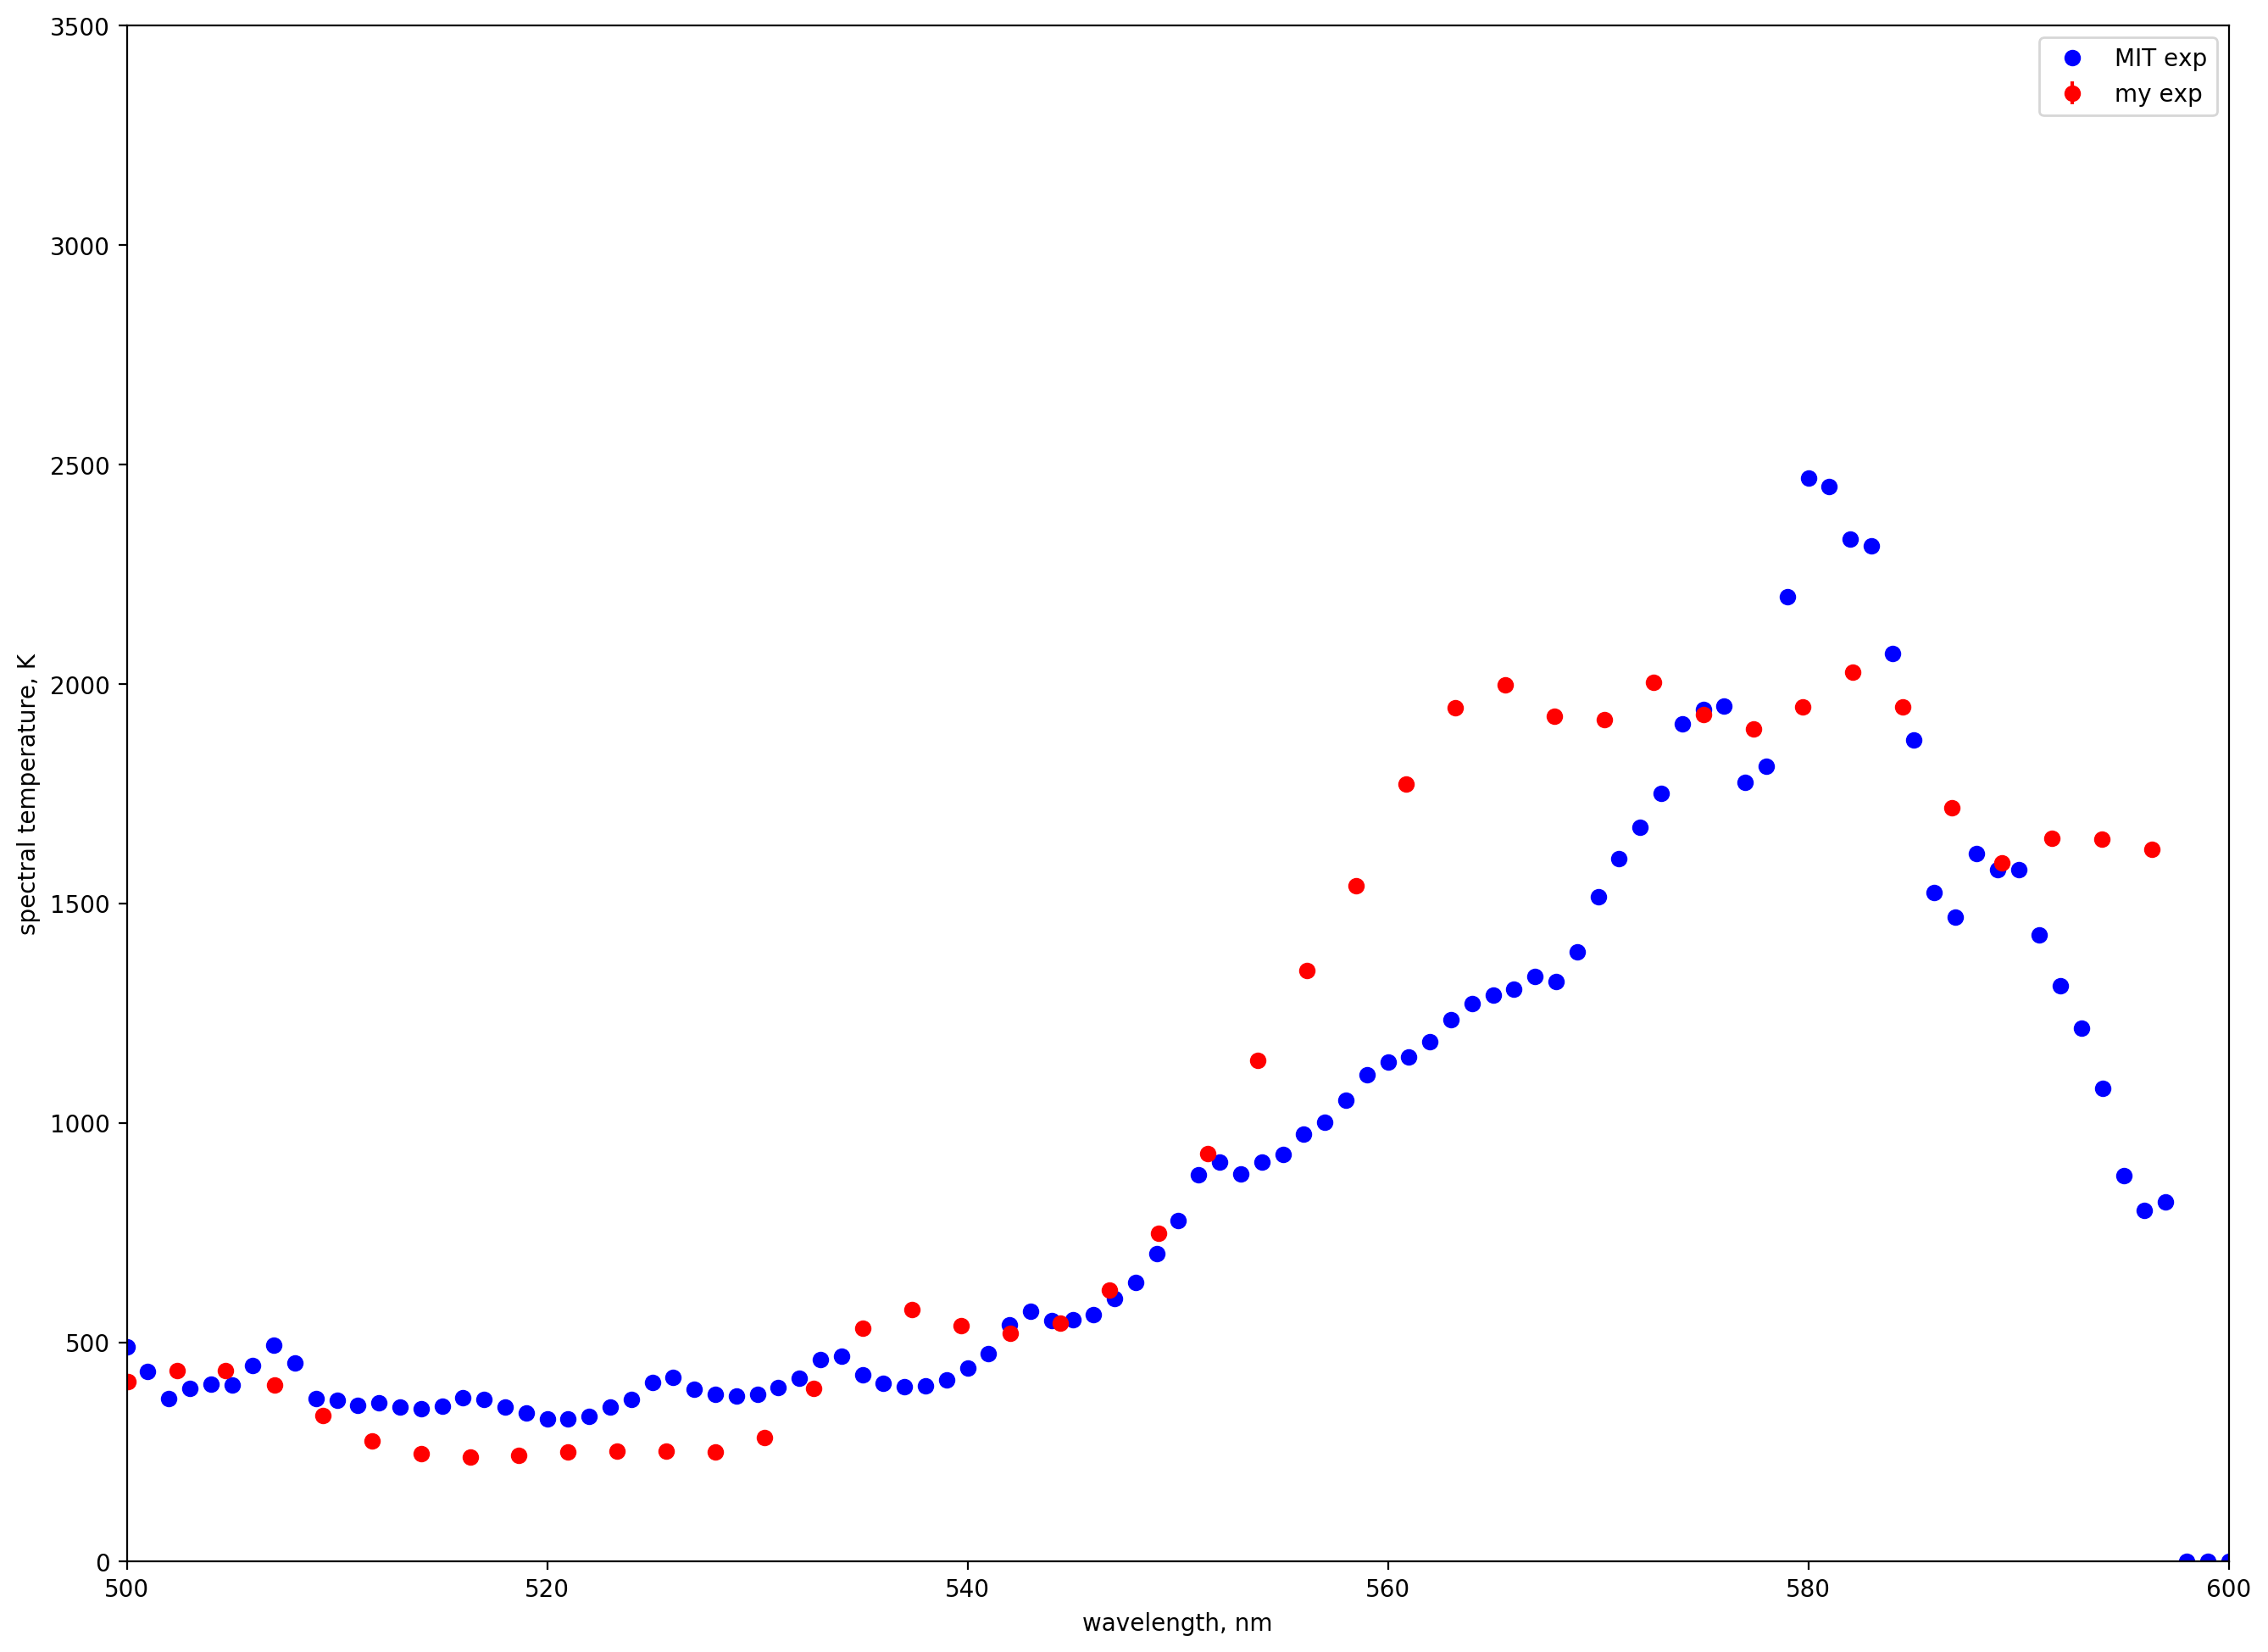

In [7]:
temp2 = deriv(np.log(alpha * freq** 3 / fly), freq, dw, upw, 3)
temp2 = (hb / k) / temp2
temp2 = temp2[dw:upw]
#def deriv1(y, x, j):
#    (y[i+j] - y[i-j])/(x[i+j] - x[i-j])

temp11 = temp2#[temp2 > 0]
#temp11 = temp11[temp11 < 1000]
print('avg temp:', np.average( temp11))
print('std temp',np.std(temp11))
#print('total number of points', specdata2[dw:upw, 0].size)

wl1, temp22, err2 = avgPlot(flwl[dw:upw], temp2, 1)
#wl1, temp22_, err2 = avgPlot(specdata2[dw:upw, 0], temp2, 1)


fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=200, facecolor='w', edgecolor='k')
#ax.plot(specdata2[dw:upw, 0], temp2[dw:upw], linestyle='', marker='o', color='red')#plt.ylim(0, 600)
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='red')
#ax.errorbar(flwl, temp2, yerr=0, fmt='-o', linestyle='', color='red')



#ax.errorbar(wl1, temp1, yerr=err1, fmt='-o', linestyle='', color='green')
#ax.plot(wl1, np.ones(wl1.size) * np.average(temp11), linestyle='--', marker='', color='blue')#plt.ylim(0, 600)
tempMit = np.genfromtxt('tempMitqd2.csv', delimiter = ';')
ax.plot(tempMit[:,0], tempMit[:,1], linestyle='', marker='o', color='blue')#plt.ylim(0, 600)

plt.legend( ('MIT exp', 'my exp'))

#print(np.average(temp22))
plt.ylim(0,3500)
plt.xlim(500, 600)
plt.xlabel('wavelength, nm')
plt.ylabel('spectral temperature, K')
plt.show()



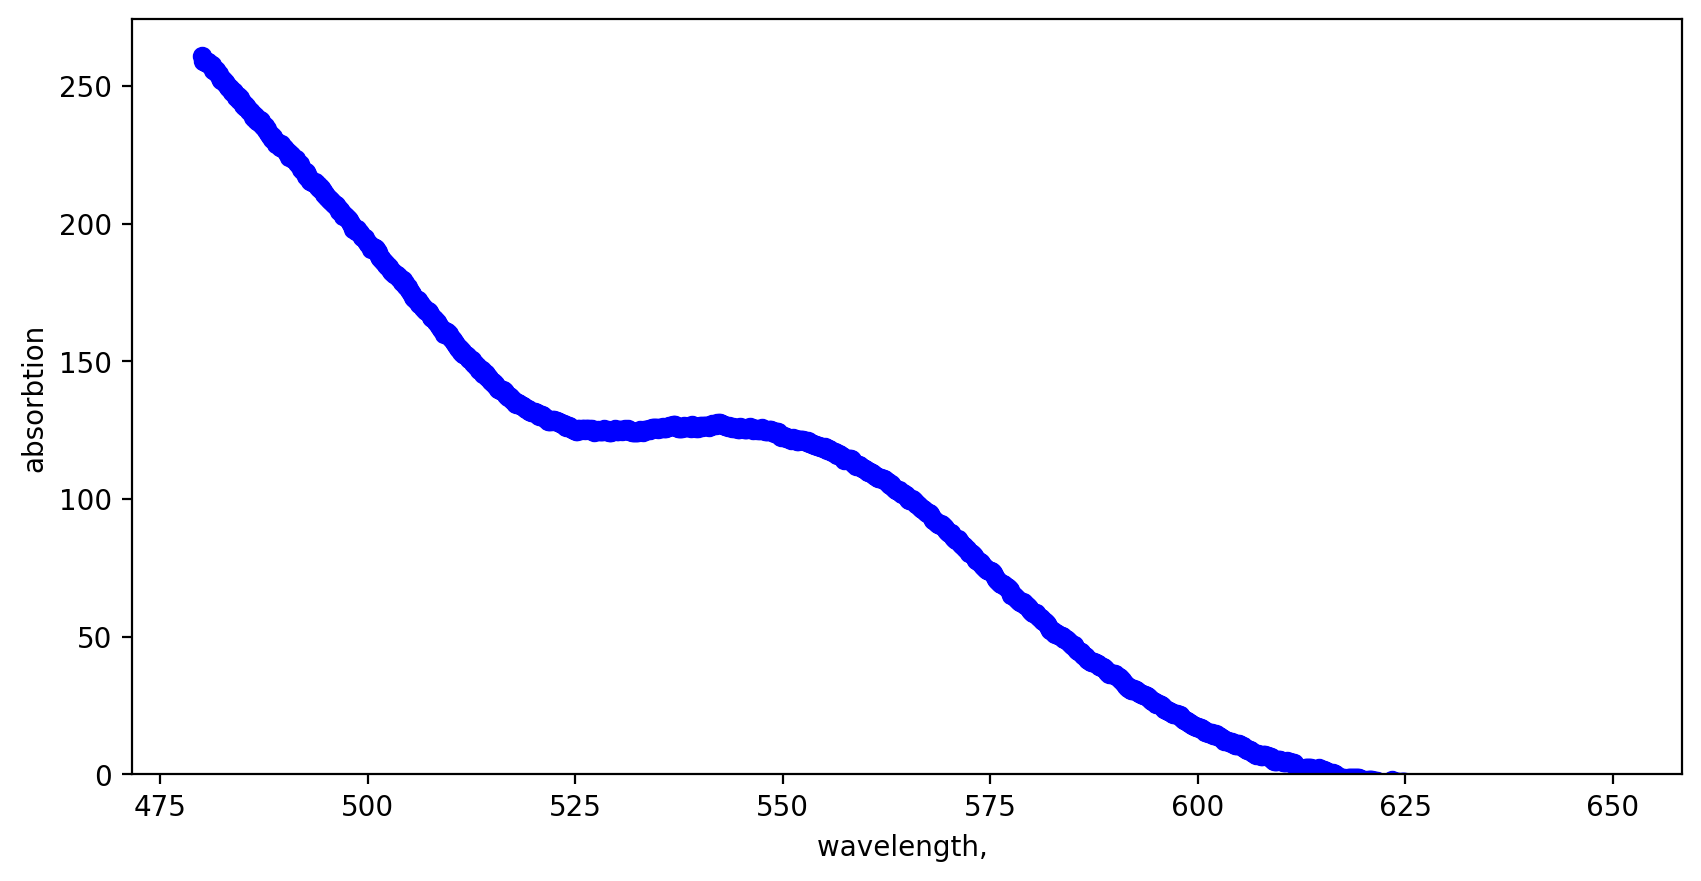

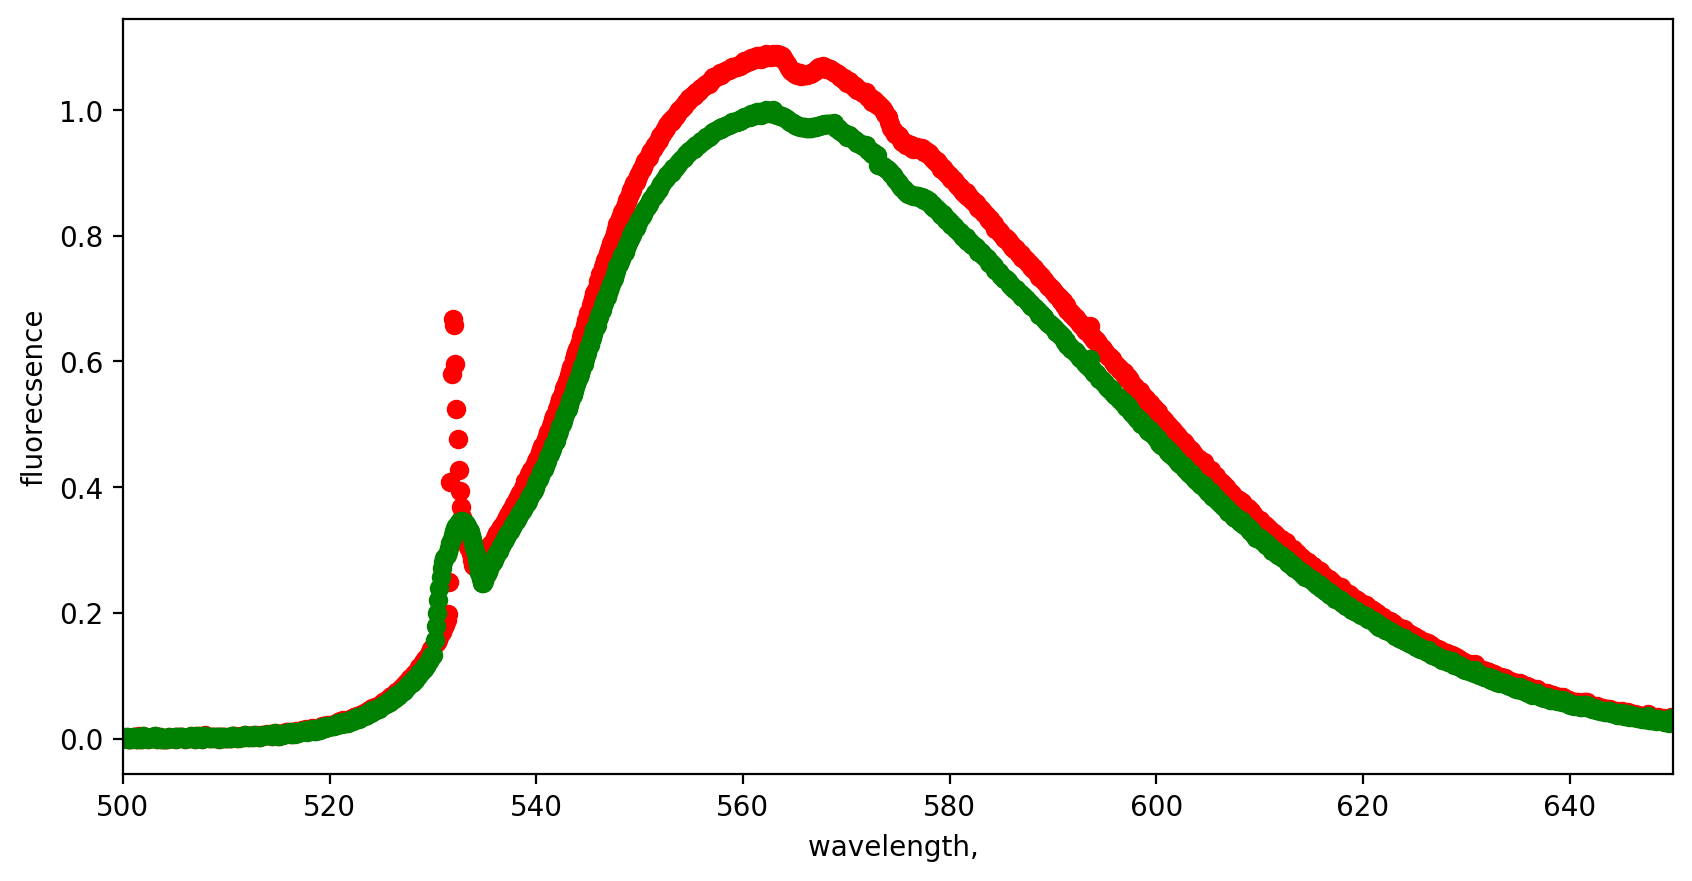

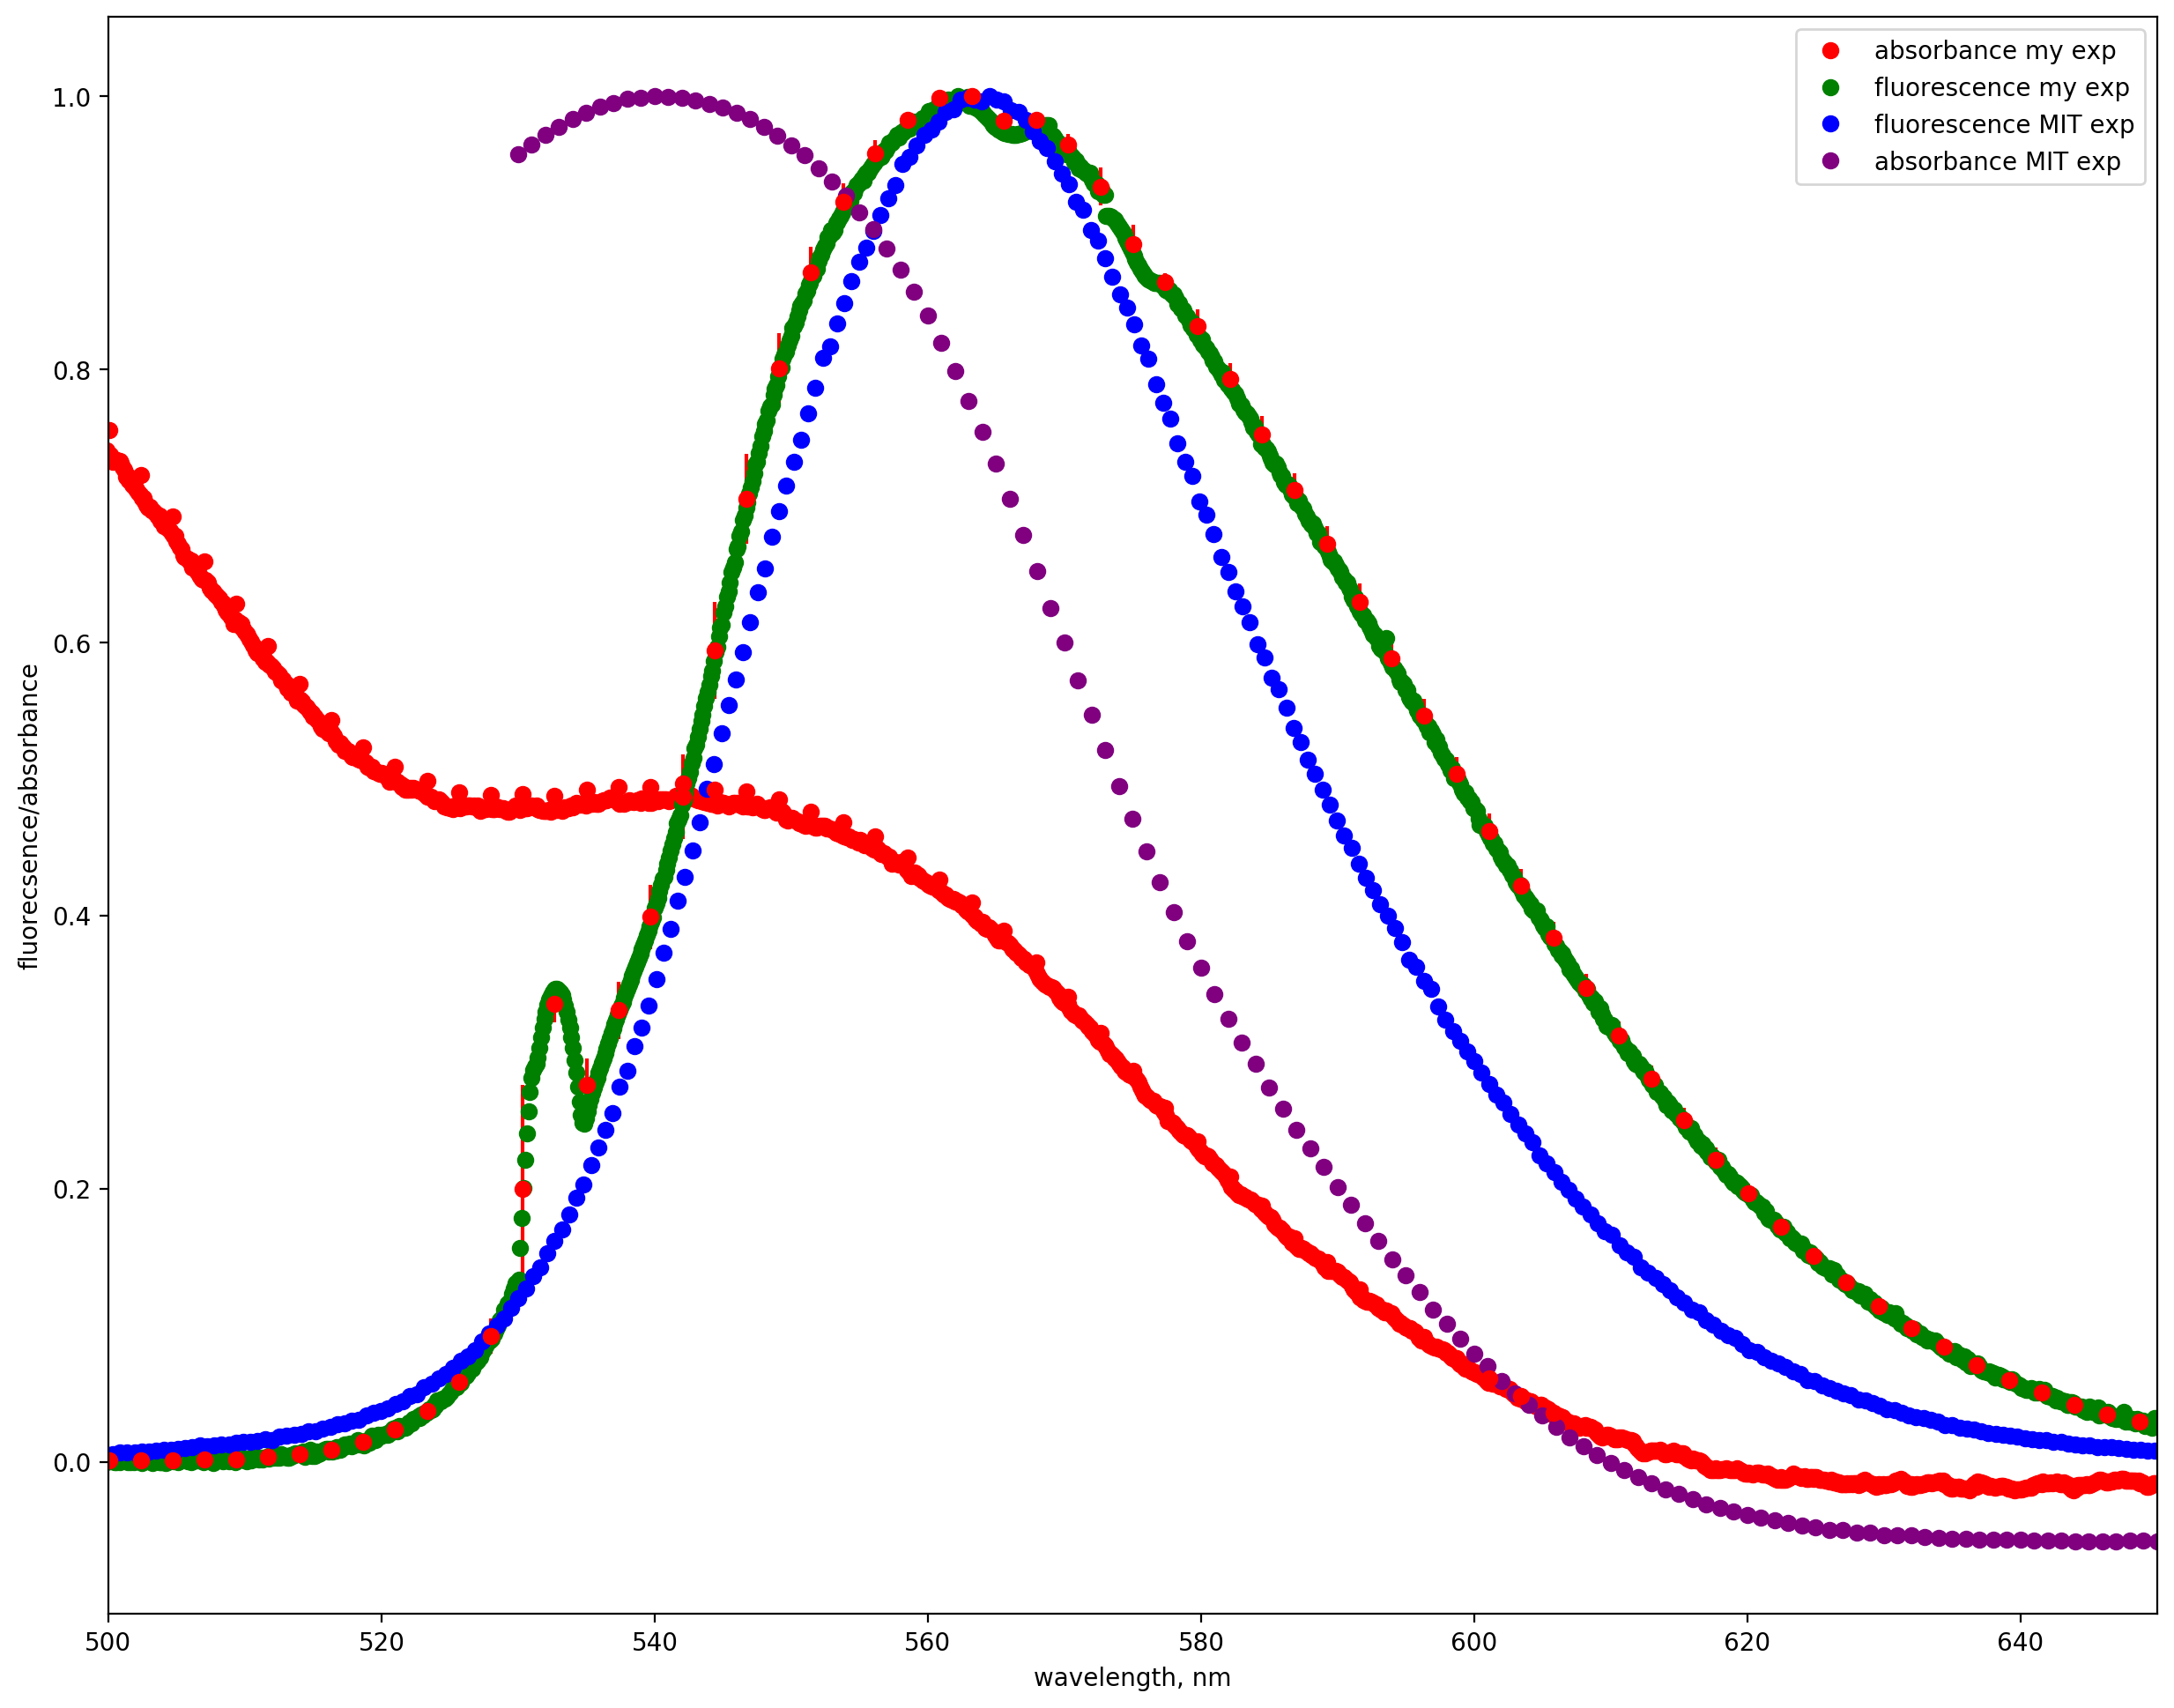

max fluorescence wl 562.2142944
max absorption wl 480.0246887


In [385]:
#read specs
specdata1 = readSp('qd1_a_2_2.csv', ';')
#specdata = readSp('qd1_ocd_2.csv', delimiter = ';')
specdata = readSp('qd1_ocd_2.csv', delimiter = ';')
specdata2 = readSp('qd1_f_1.csv', ';')

rangeWl = np.copy(specdata2[:,0])
specAbs = np.copy(specdata[:,1] - specdata1[:,1])
specFlur = np.copy(specdata2[:,1])
#specdata = specdata * 0.1 / 0.12

#cutting all less x
cutwl = np.where(rangeWl >= 480)[0][0]
specdata = np.copy(specdata[cutwl:])
specdata1 = np.copy(specdata1[cutwl:])
specdata2 = np.copy(specdata2[cutwl:])
specAbs = np.copy(specAbs[cutwl:])
rangeWl = np.copy(rangeWl[cutwl:])

#cutting all more than x

cutwl = np.where(rangeWl <= 650)[0][-1]
specdata = np.copy(specdata[:cutwl])
specdata1 = np.copy(specdata1[:cutwl])
specdata2 = np.copy(specdata2[:cutwl])
specAbs = np.copy(specAbs[:cutwl])
rangeWl = np.copy(rangeWl[:cutwl])

#absorbtion
yy, xx = transM(specdata2[:,1]*100, specdata2[:,0], np.genfromtxt('QuartzCuvette.csv', delimiter = '\t'))
fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=200, facecolor='w', edgecolor='k')
#ax.plot(specdata[:,0], specdata[:,1], linestyle='', marker='o', color='green')
#ax.plot(specdata1[:,0], specdata1[:,1], linestyle='', marker='o', color='red')
ax.plot(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1]) / 0.002 , linestyle='', marker='o', color='blue')
plt.xlabel('wavelength, ')
plt.ylabel('absorbtion')
plt.ylim(-0.1)
#plt.xlim(510, 600)
#plt.ylim(0,130)
plt.show()

#fluor
#transmition + smooth for pump and 2 strange regions
specdata2[:,1], specdata2[:,0] = transM(specdata2[:,1]*100, specdata2[:,0], np.genfromtxt('QuartzCuvette.csv', delimiter = '\t'))

specdata2[:,1] = smooth(specdata2[:,0], specdata2[:,1], 530, 540)
specdata2[:,1] = smooth(specdata2[:,0], specdata2[:,1], 563, 569)
specdata2[:,1] = smooth(specdata2[:,0], specdata2[:,1], 573, 577)

#plot
fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=200, facecolor='w', edgecolor='k')
ax.plot(xx, yy, linestyle='', marker='o', color='red')

ax.plot(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), linestyle='', marker='o', color='green')
plt.xlabel('wavelength, ')
plt.ylabel('fluorecsence')
#ax.plot(specdataE2[:-100,0], specdataE2[:-100,1]/max(specdataE2[:,1]), linestyle='', marker='o', color='red')

plt.xlim(500, 650)
plt.show()

specdataQDA = np.genfromtxt('fromMit/abs_1', delimiter = '\t')
specdataQDF = np.genfromtxt('fromMit/flur_1', delimiter = '\t')

fig, ax = plt.subplots(num=None, figsize=(15, 12), dpi=200, facecolor='w', edgecolor='k')
ax.plot(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1]) / max(np.log(specdata[:,1]/specdata1[:,1])) , linestyle='', marker='o', color='red')
ax.plot(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), linestyle='', marker='o', color='green')

abswl, absy, abserr = avgPlot(specdata2[:, 0], np.log(specdata[:,1]/specdata1[:,1]), 20)
flwl, fly, flerr = avgPlot(specdata2[:, 0], specdata2[:,1], 20)

ax.errorbar(abswl, absy / max(absy) , yerr=abserr,linestyle='', marker='o', color='red')
ax.errorbar(flwl, fly / max(fly), yerr=flerr, linestyle='', marker='o', color='red')



ax.plot(specdataQDF[:,0], specdataQDF[:,1]/max(specdataQDF[:,1]), linestyle='', marker='o', color='blue')
#ax.plot(x[:,0], x[:,1]/max(x[:,1]), linestyle='', marker='o', color='blue')
ax.plot(specdataQDA[:-180,0], specdataQDA[:-180,1]/max(specdataQDA[:-180,1]), linestyle='', marker='o', color='purple')

plt.xlabel('wavelength, nm')
plt.ylabel('fluorecsence/absorbance')
plt.legend( ('absorbance my exp', 'fluorescence my exp', 'fluorescence MIT exp', 'absorbance MIT exp'))
plt.xlim(500, 650)
#plt.ylim(0,0.4)
plt.show()

print('max fluorescence wl', specdata2[np.where(specdata2[:,1] == max(specdata2[:,1]))[0][0],0])
print('max absorption wl', specdata[np.where(np.log(specdata[:,1]/specdata1[:,1]) == max(np.log(specdata[:,1]/specdata1[:,1])))[0][0],0])





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


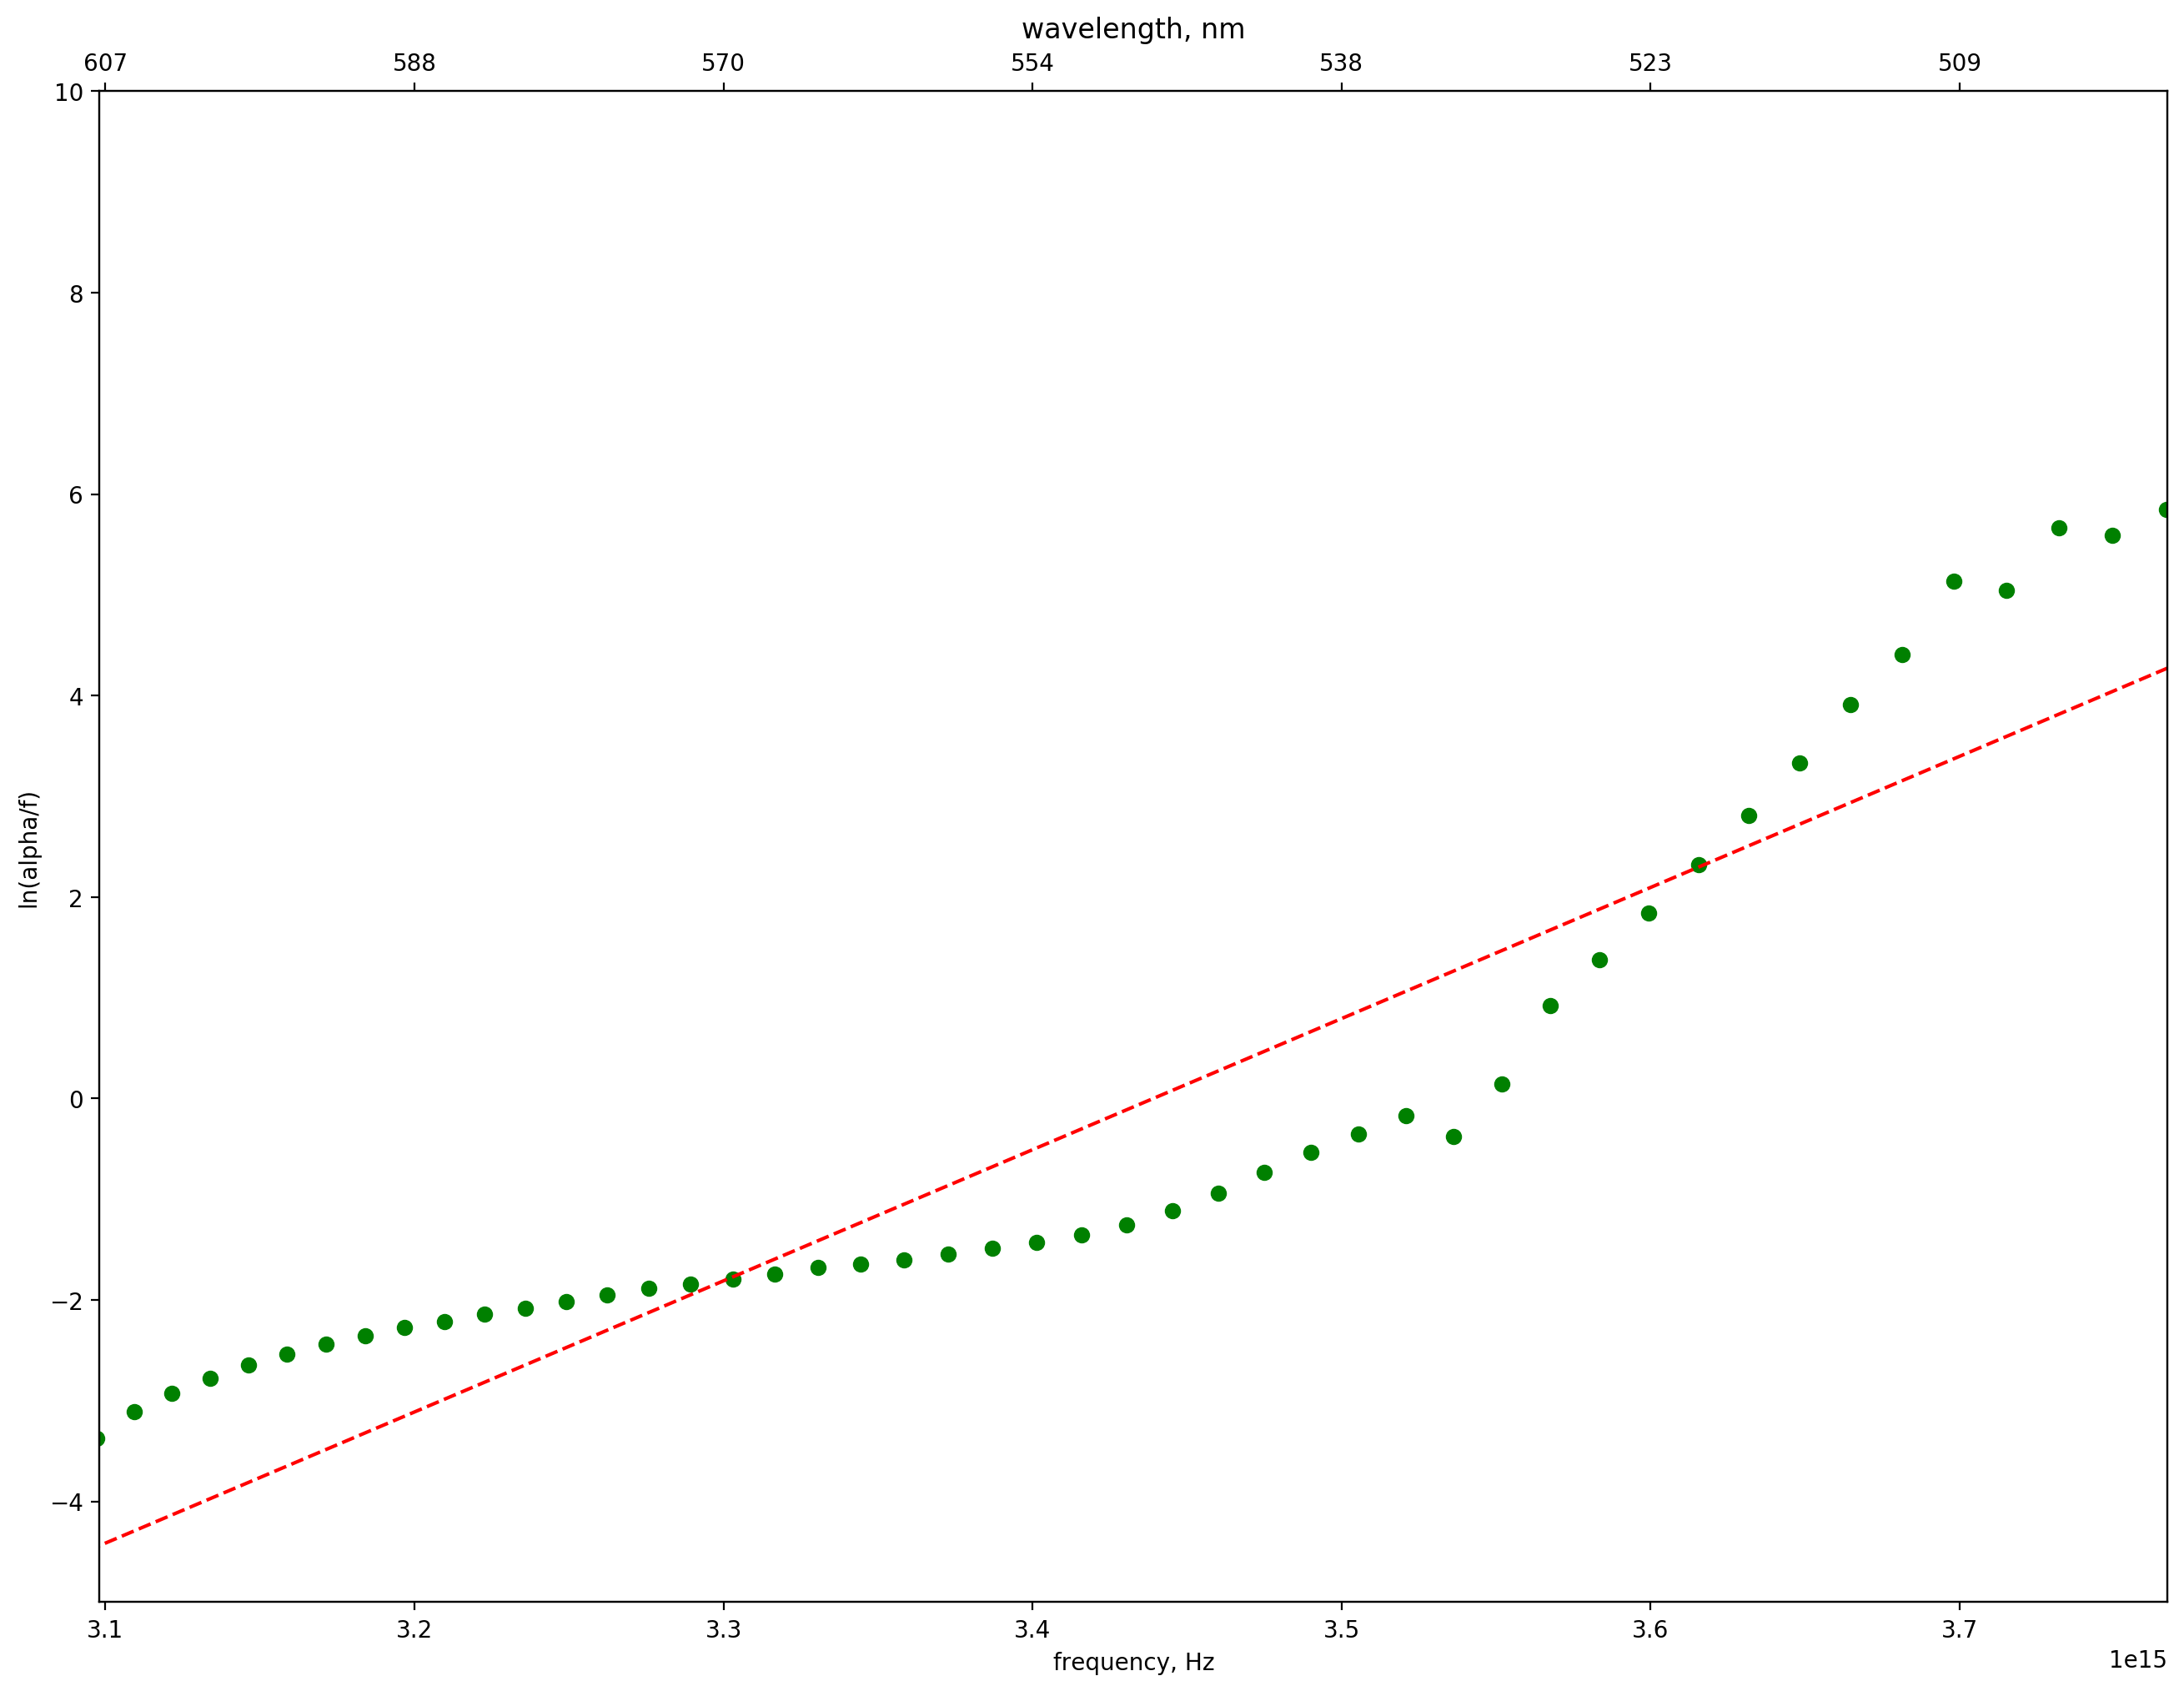

estimated temp 586.6849427357243


In [386]:
alpha = absy 



lolo = (np.log(alpha/fly))

fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=200, facecolor='w', edgecolor='k')
#freq = 2 * np.pi * c / specdata1[:,0] * 1e+9
#ax.plot(specdata2[:,0], lolo, linestyle='', marker='o', color='blue')
#ax.plot(specdata2[:,0], popt[0]*(2 * np.pi * c * 1e+9 / specdata2[:,0]) + popt[1], linestyle='', marker='o', color='green')
#ax.plot(alpha, specdata2[:,1], linestyle='', marker='o', color='blue')
plt.xlabel('frequency, Hz')
plt.ylabel('ln(alpha/f)')
#plt.xlim(520, 590)
#plt.ylim(4, 8)

#plt.xlim(3.4 * 1e+15, 3.5 * 1e+15)

#alpha = specdata[:,1] - specdata1[:,1]
#lolo = np.log(alpha2/specdata2[:,1])

dwV = 2 * np.pi * c / 480 * 1e+9
upwV = 2 * np.pi * c /  600 * 1e+9
freq = 2 * np.pi * c / flwl * 1e+9
upw = np.where(freq >= upwV)[0][-1] 
dw = np.where(freq <= dwV)[0][0] 
def func(x, a, b):
    return x * a + b
lolo = np.nan_to_num(lolo)
popt, pcov = curve_fit(func,   freq[dw:upw], (lolo[dw:upw]))

#ax.plot(specdata2[:,0], func(freq[:], *popt), linestyle='--', marker='', color='green')

ax.plot(freq[:], lolo, linestyle='', marker='o', color='green')
ax.plot(freq[:], func(freq[:], *popt), linestyle='--', marker='', color='red')

#ax.plot(freq[:], np.log(alpha * freq** 3 / specdata2[:, 1]), linestyle='', marker='o', color='red')
#ax.plot(freq[:], deriv(np.log(alpha * freq** 3 / specdata2[:, 1]), freq, dw, upw), linestyle='', marker='o', color='red')

plt.xlim(2 * np.pi * c /  608 * 1e+9, 2 * np.pi * c /  500 * 1e+9)
plt.ylim(-5, 10)
ax2 = ax.twiny()
ax1Xs = ax.get_xticks()

ax2Xs = []
for X in ax1Xs:
    ax2Xs.append(int(2 * np.pi * c * 1e+9/X))

ax2.set_xticks(ax1Xs)
ax2.set_xbound(ax.get_xbound())
ax2.set_xticklabels(ax2Xs)
ax2.set_title('wavelength, nm')



plt.show()
#spec temperature  
print('estimated temp', hb  /(k * popt[0]))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


avg temp: nan
std temp nan


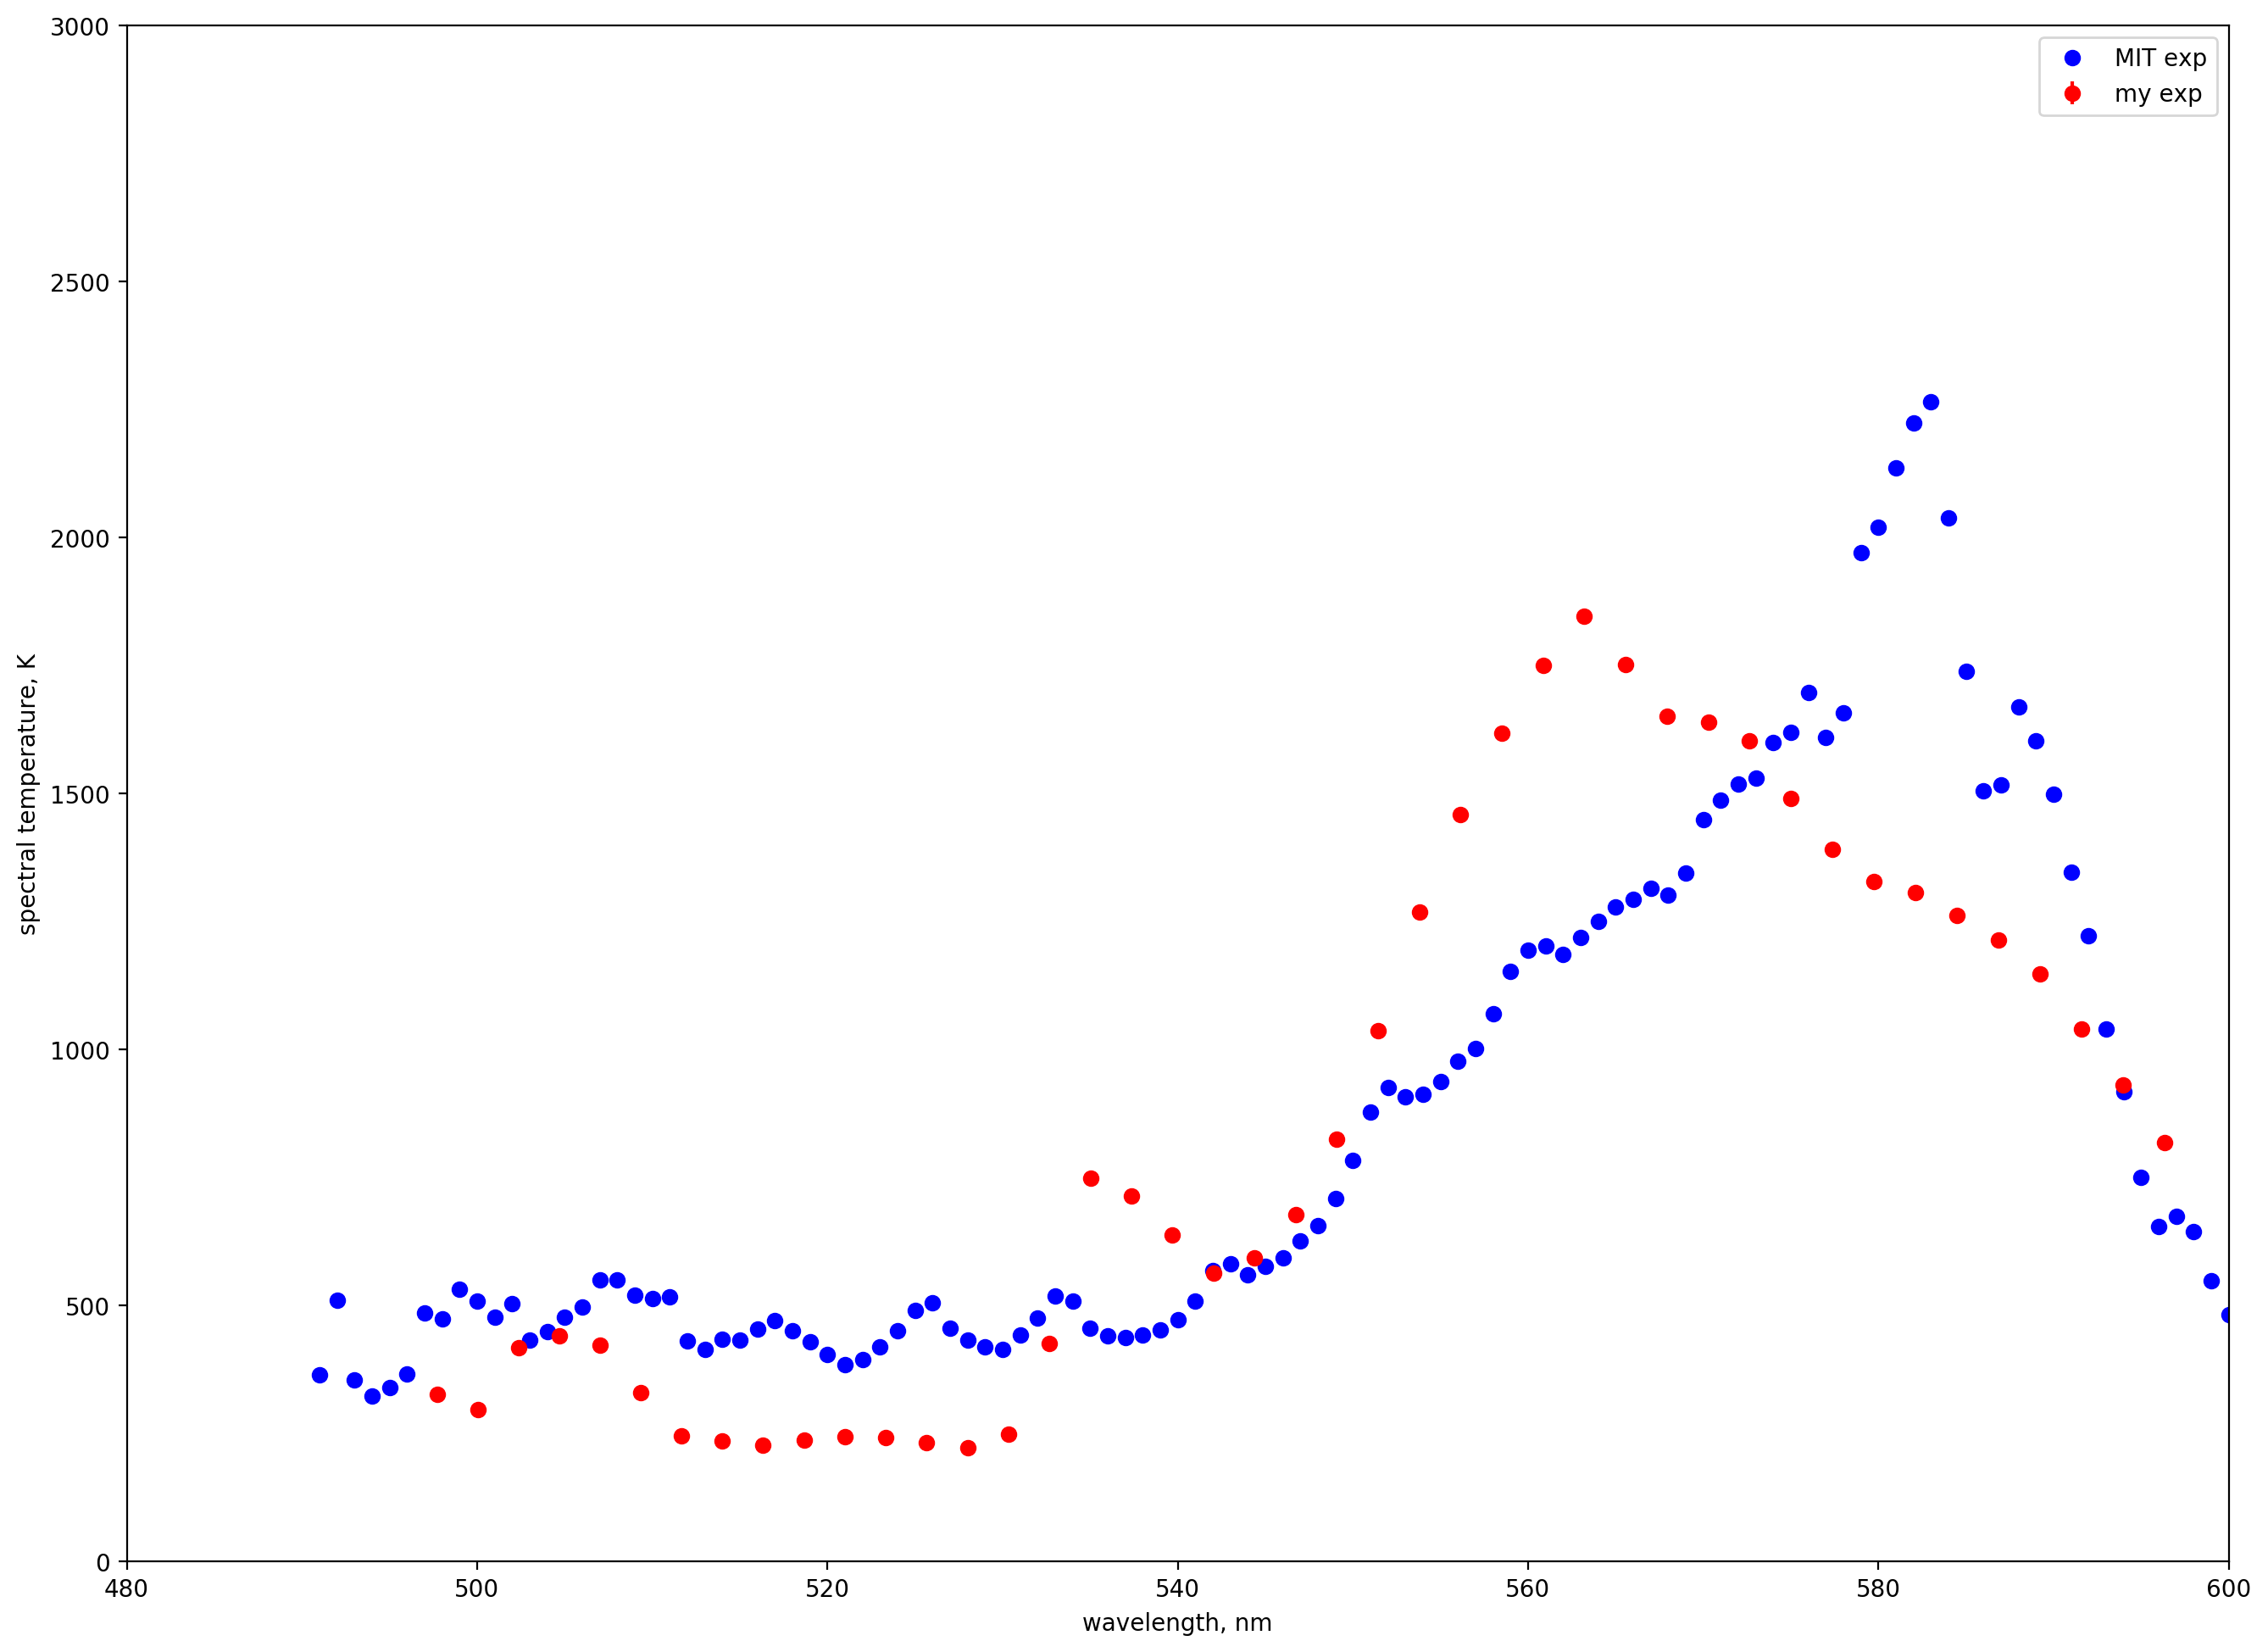

In [387]:


temp2 = deriv(np.log(alpha * freq** 3 / fly), freq, dw, upw, 3)
temp2 = (hb / k) / temp2
temp2 = temp2[dw:upw]
#def deriv1(y, x, j):
#    (y[i+j] - y[i-j])/(x[i+j] - x[i-j])

temp11 = temp2#[temp2 > 0]
#temp11 = temp11[temp11 < 1000]
print('avg temp:', np.average( temp11))
print('std temp',np.std(temp11))
#print('total number of points', specdata2[dw:upw, 0].size)

wl1, temp22, err2 = avgPlot(flwl[dw:upw], temp2, 1)
#wl1, temp22_, err2 = avgPlot(specdata2[dw:upw, 0], temp2, 1)


fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=200, facecolor='w', edgecolor='k')
#ax.plot(specdata2[dw:upw, 0], temp2[dw:upw], linestyle='', marker='o', color='red')#plt.ylim(0, 600)
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='red')
#ax.errorbar(flwl, temp2, yerr=0, fmt='-o', linestyle='', color='red')

#ax.errorbar(wl1, temp1, yerr=err1, fmt='-o', linestyle='', color='green')
#ax.plot(wl1, np.ones(wl1.size) * np.average(temp11), linestyle='--', marker='', color='blue')#plt.ylim(0, 600)
tempMit = np.genfromtxt('tempMitqd1.csv', delimiter = ';')

ax.plot(tempMit[:,0], tempMit[:,1], linestyle='', marker='o', color='blue')#plt.ylim(0, 600)


plt.legend( ('MIT exp', 'my exp'))

#print(np.average(temp22))
plt.ylim(0,3000)
plt.xlim(480, 600)
plt.xlabel('wavelength, nm')
plt.ylabel('spectral temperature, K')
plt.show()



In [ ]:
#here comes more interesting

In [8]:
#stöpa
def stepaPlot(specdata1, specdata, specdata2):
    specdata1 = np.copy(specdata1)
    specdata = np.copy(specdata)
    specdata2 = np.copy(specdata2)
    #read specs

    rangeWl = np.copy(specdata2[:,0])
    specAbs = np.copy(specdata[:,1] - specdata1[:,1])
    specFlur = np.copy(specdata2[:,1])
#specdata = specdata * 0.1 / 0.12

#cutting all less x
    cutwl = np.where(rangeWl >= 520)[0][0]
    specdata = np.copy(specdata[cutwl:])
    specdata1 = np.copy(specdata1[cutwl:])
    specdata2 = np.copy(specdata2[cutwl:])
    specAbs = np.copy(specAbs[cutwl:])
    rangeWl = np.copy(rangeWl[cutwl:])

#cutting all more than x

    cutwl = np.where(rangeWl <= 650)[0][-1]
    specdata = np.copy(specdata[:cutwl])
    specdata1 = np.copy(specdata1[:cutwl])
    specdata2 = np.copy(specdata2[:cutwl])
    specAbs = np.copy(specAbs[:cutwl])
    rangeWl = np.copy(rangeWl[:cutwl])

#absorption
    #fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=200, facecolor='w', edgecolor='k')
    #ax.plot(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1]) / 0.002 , linestyle='', marker='o', color='blue')
    #plt.xlabel('wavelength, ')
    #plt.ylabel('absorbtion')
    #plt.ylim(-0.1)
#plt.xlim(510, 600)
#plt.ylim(0,130)
    #plt.show()

#fluor
    specdata2[:,1], specdata2[:,0] = transM(specdata2[:,1]*100, specdata2[:,0], np.genfromtxt('QuartzCuvette.csv', delimiter = '\t'))

#plot
    #fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=200, facecolor='w', edgecolor='k')

    #ax.plot(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), linestyle='', marker='o', color='green')
    #plt.xlabel('wavelength, ')
    #plt.ylabel('fluorecsence')

    #plt.xlim(500, 650)
    #plt.show()

    specdataQDA = np.genfromtxt('fromMit/abs_2', delimiter = '\t')
    specdataQDF = np.genfromtxt('fromMit/flur_2', delimiter = '\t')

    fig, ax = plt.subplots(num=None, figsize=(15, 12), dpi=200, facecolor='w', edgecolor='k')
    ax.plot(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1]) / max(np.log(specdata[:,1]/specdata1[:,1])) , linestyle='', marker='o', color='red')
    ax.plot(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), linestyle='', marker='o', color='green')

    abswl, absy, abserr = avgPlot(specdata2[:, 0], np.log(specdata[:,1]/specdata1[:,1]), 20)
    flwl, fly, flerr = avgPlot(specdata2[:, 0], specdata2[:,1], 20)

    ax.errorbar(abswl, absy / max(absy) , yerr=abserr,linestyle='', marker='o', color='red')
    ax.errorbar(flwl, fly / max(fly), yerr=flerr, linestyle='', marker='o', color='red')

    #ax.plot(specdataQDF[:,0], specdataQDF[:,1]/max(specdataQDF[:,1]), linestyle='', marker='o', color='blue')
    #ax.plot(specdataQDA[:-180,0], specdataQDA[:-180,1]/max(specdataQDA[:-180,1]), linestyle='', marker='o', color='purple')

    plt.xlabel('wavelength, nm')
    plt.ylabel('fluorecsence/absorbance')
    #plt.legend( ('absorbance my exp', 'fluorescence my exp', 'fluorescence MIT exp', 'absorbance MIT exp'))
    plt.xlim(500, 650)

    plt.show()

    print('max fluorescence wl', specdata2[np.where(specdata2[:,1] == max(specdata2[:,1]))[0][0],0])
    print('max absorption wl', specdata[np.where(np.log(specdata[:,1]/specdata1[:,1]) == max(np.log(specdata[:,1]/specdata1[:,1])))[0][0],0])

def stepaLog(specdata1, specdata, specdata2):
    abswl, absy, abserr = avgPlot(specdata2[:, 0], np.log(specdata[:,1]/specdata1[:,1]), 20)
    flwl, fly, flerr = avgPlot(specdata2[:, 0], specdata2[:,1], 20)
    alpha = absy 
    lolo = (np.log(alpha/fly))
    fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=200, facecolor='w', edgecolor='k')

    plt.xlabel('frequency, Hz')
    plt.ylabel('ln(alpha/f)')

    dwV = 2 * np.pi * c / 480 * 1e+9
    upwV = 2 * np.pi * c /  600 * 1e+9
    freq = 2 * np.pi * c / flwl * 1e+9
    upw = np.where(freq >= upwV)[0][-1] 
    dw = np.where(freq <= dwV)[0][0] 
    def func(x, a, b):
        return x * a + b
    lolo = np.nan_to_num(lolo)
    popt, pcov = curve_fit(func,   freq[dw:upw], (lolo[dw:upw]))

    ax.plot(freq[:], lolo, linestyle='', marker='o', color='green')
    ax.plot(freq[:], func(freq[:], *popt), linestyle='--', marker='', color='red')
    
    plt.xlim(2 * np.pi * c /  608 * 1e+9, 2 * np.pi * c /  500 * 1e+9)
    plt.ylim(-5, 10)
    ax2 = ax.twiny()
    ax1Xs = ax.get_xticks()

    ax2Xs = []
    for X in ax1Xs:
        ax2Xs.append(int(2 * np.pi * c * 1e+9/X))

    ax2.set_xticks(ax1Xs)
    ax2.set_xbound(ax.get_xbound())
    ax2.set_xticklabels(ax2Xs)
    ax2.set_title('wavelength, nm')
    plt.show()
    print('estimated temp', hb  /(k * popt[0]))
    
#spec temperature  ###################1111#####
def stepaTemp(specdata1, specdata, specdata2):
    wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2)
    print('avg temp:', np.average( temp22))
    print('std temp',np.std(temp22))
    
    fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=200, facecolor='w', edgecolor='k')
    ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='red')

    tempMit = np.genfromtxt('tempMitqd1.csv', delimiter = ';')
    ax.plot(tempMit[:,0], tempMit[:,1], linestyle='', marker='o', color='blue')#plt.ylim(0, 600)

    plt.legend( ('MIT exp', 'my exp'))

    plt.ylim(0,3000)
    plt.xlim(500, 600)
    plt.xlabel('wavelength, nm')
    plt.ylabel('spectral temperature, K')
    plt.show()
    
def stepaTemp1(specdata1, specdata, specdata2, smoothing = True, smoothing2 = True):
    specdata2[:,1], specdata2[:,0] = transM(specdata2[:,1]*100, specdata2[:,0], np.genfromtxt('QuartzCuvette.csv', delimiter = '\t'))
    specdata2 = cleanSpec(specdata2)
    if smoothing:
        specdata2[:, 1] = (smooth(specdata2[:, 0], specdata2[:, 1], 460, 640))
    absy1 = np.log(specdata[:,1]/specdata1[:,1])

    if smoothing2:
        absy1 = smooth(specdata2[:, 0], absy1, 460, 640)

    abswl, absy, abserr = avgPlot(specdata2[:, 0], absy1, 20)

    
    flwl, fly, flerr = avgPlot(specdata2[:, 0], specdata2[:,1], 20)
    alpha = absy 
    lolo = (np.log(alpha/fly))
    dwV = 2 * np.pi * c / 450 * 1e+9
    upwV = 2 * np.pi * c /  640 * 1e+9
    freq = 2 * np.pi * c / flwl * 1e+9
    upw = np.where(freq >= upwV)[0][-1] 
    dw = np.where(freq <= dwV)[0][0] 
    
    temp2 = deriv(np.log(alpha * freq** 3 / fly), freq, dw, upw, 2)
    temp2 = (hb / k) / temp2
    temp2 = temp2[dw:upw]

    temp11 = temp2#[temp2 > 0]


    wl1, temp22, err2 = avgPlot(flwl[dw:upw], temp2, 1)
    return wl1, temp22, err2

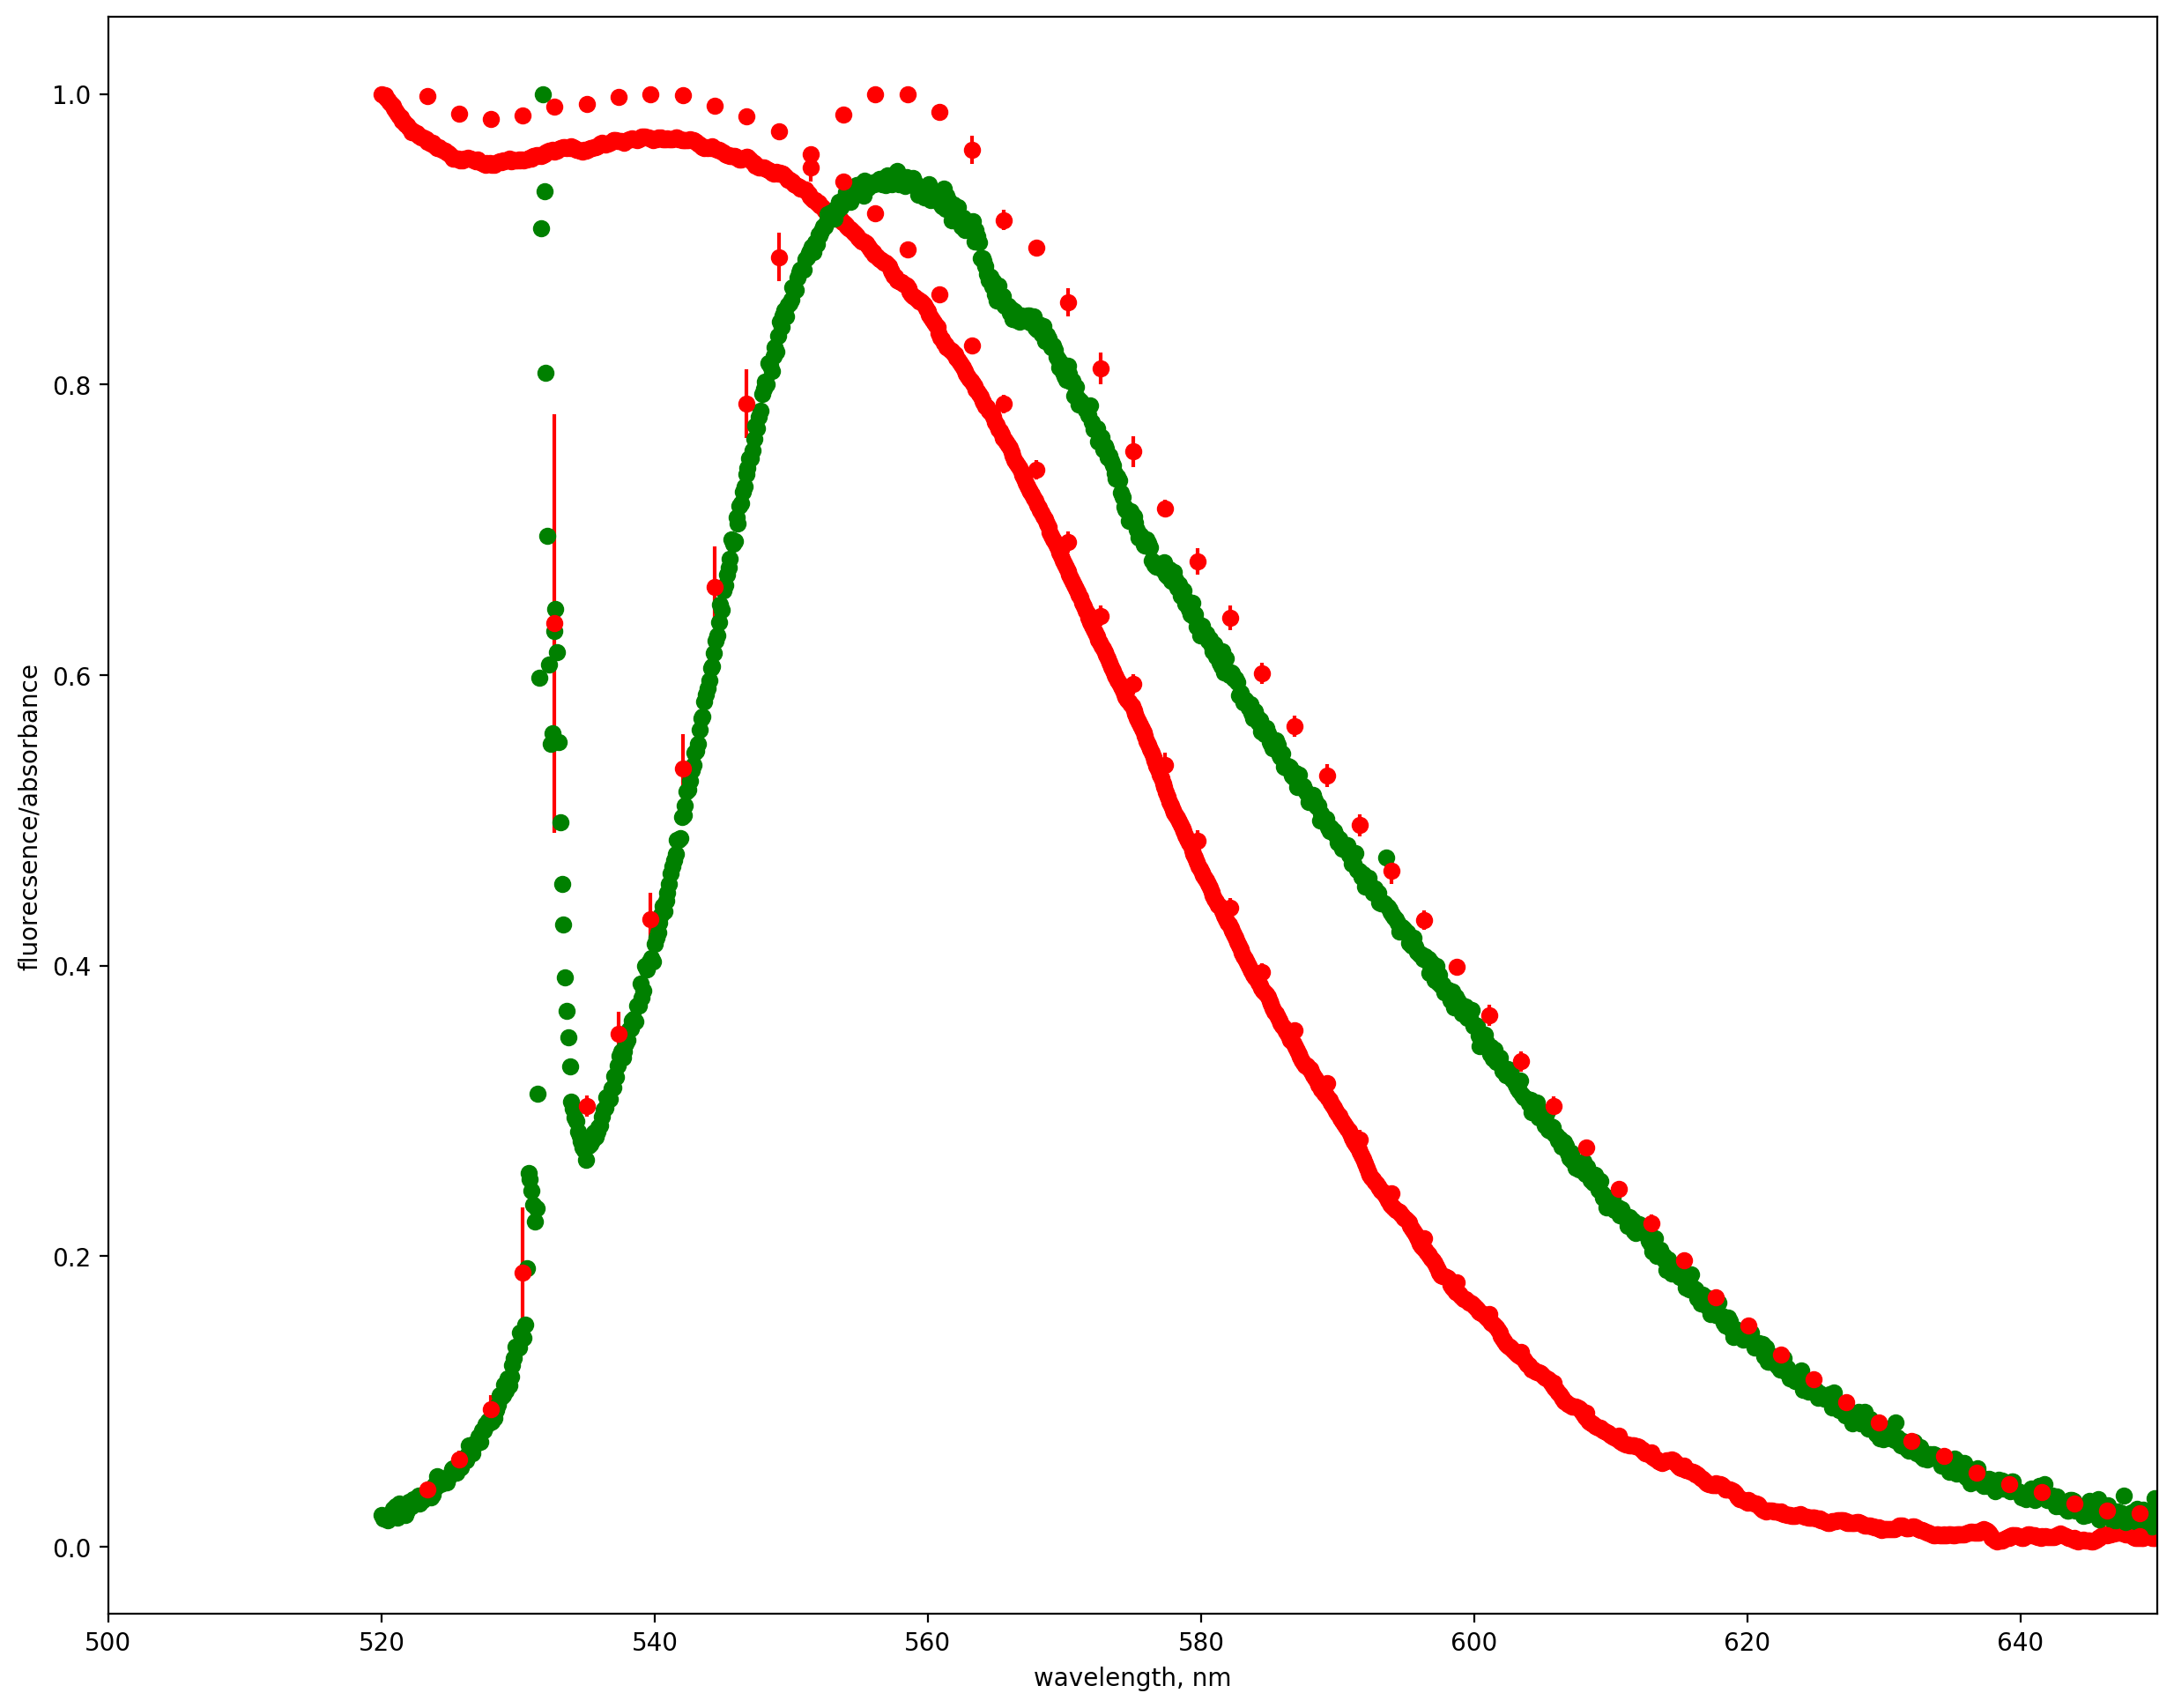

max fluorescence wl 531.7994385
max absorption wl 520.0028687


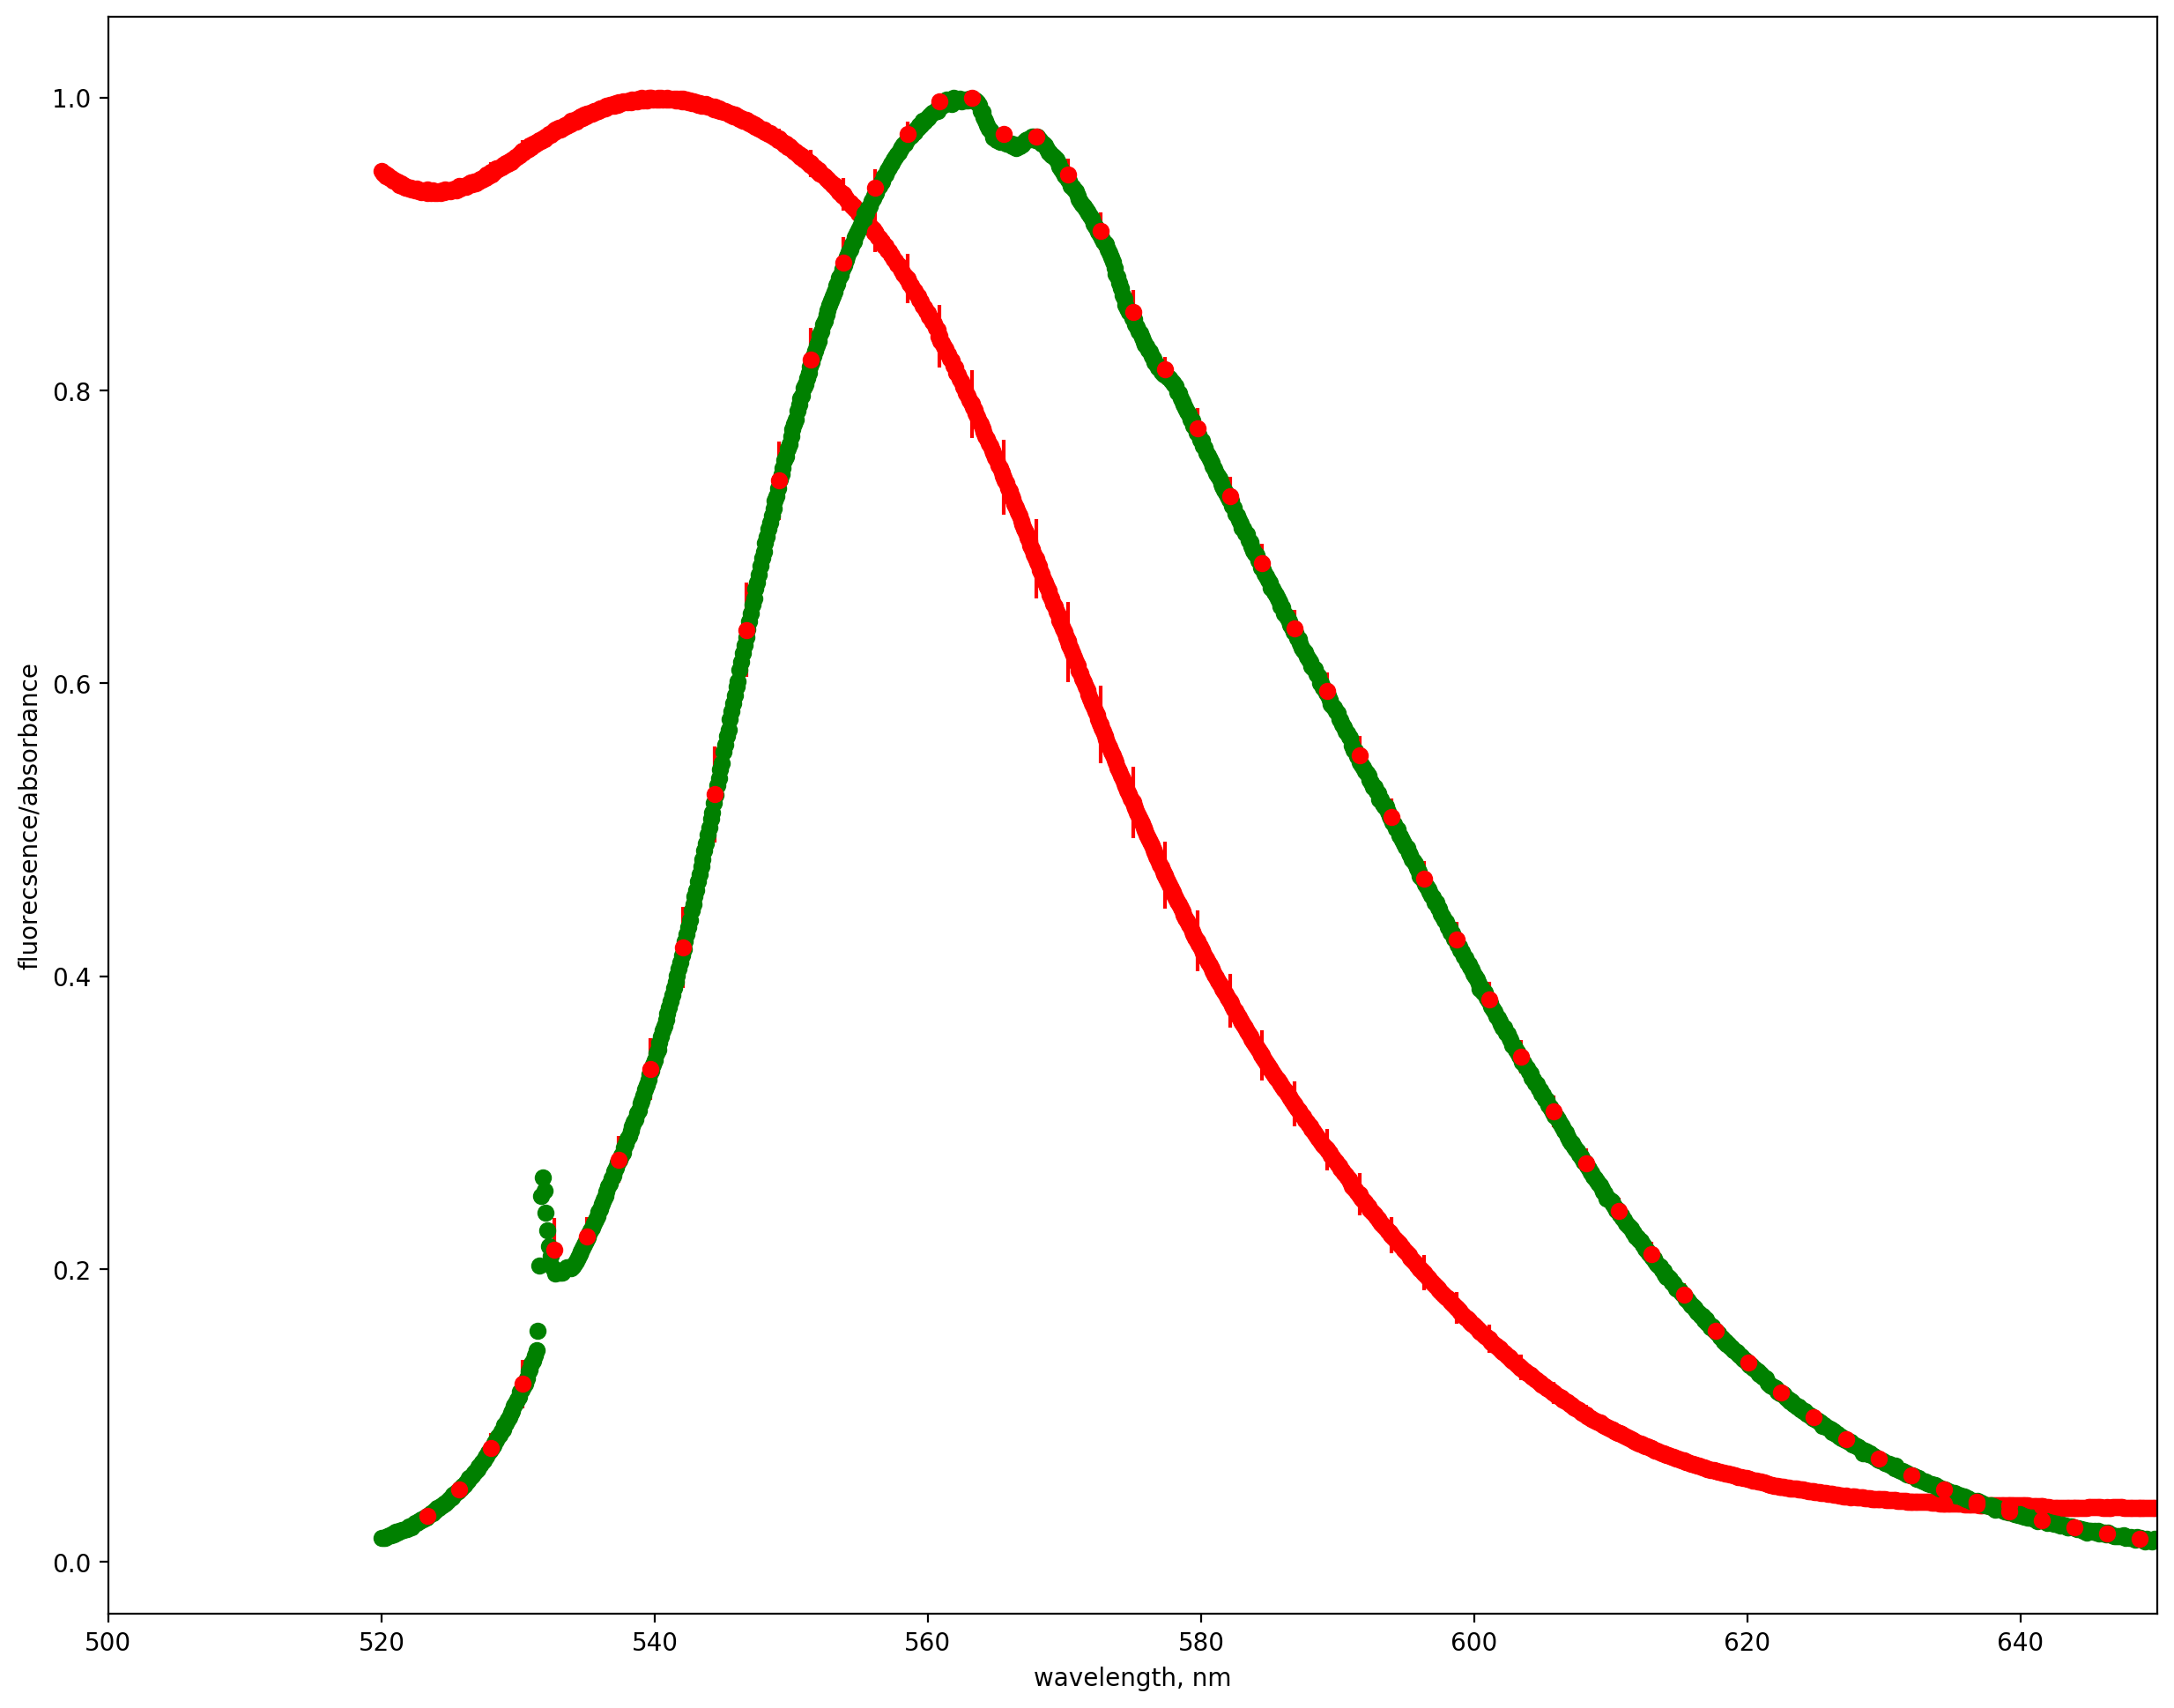

max fluorescence wl 561.8607788
max absorption wl 540.4662476


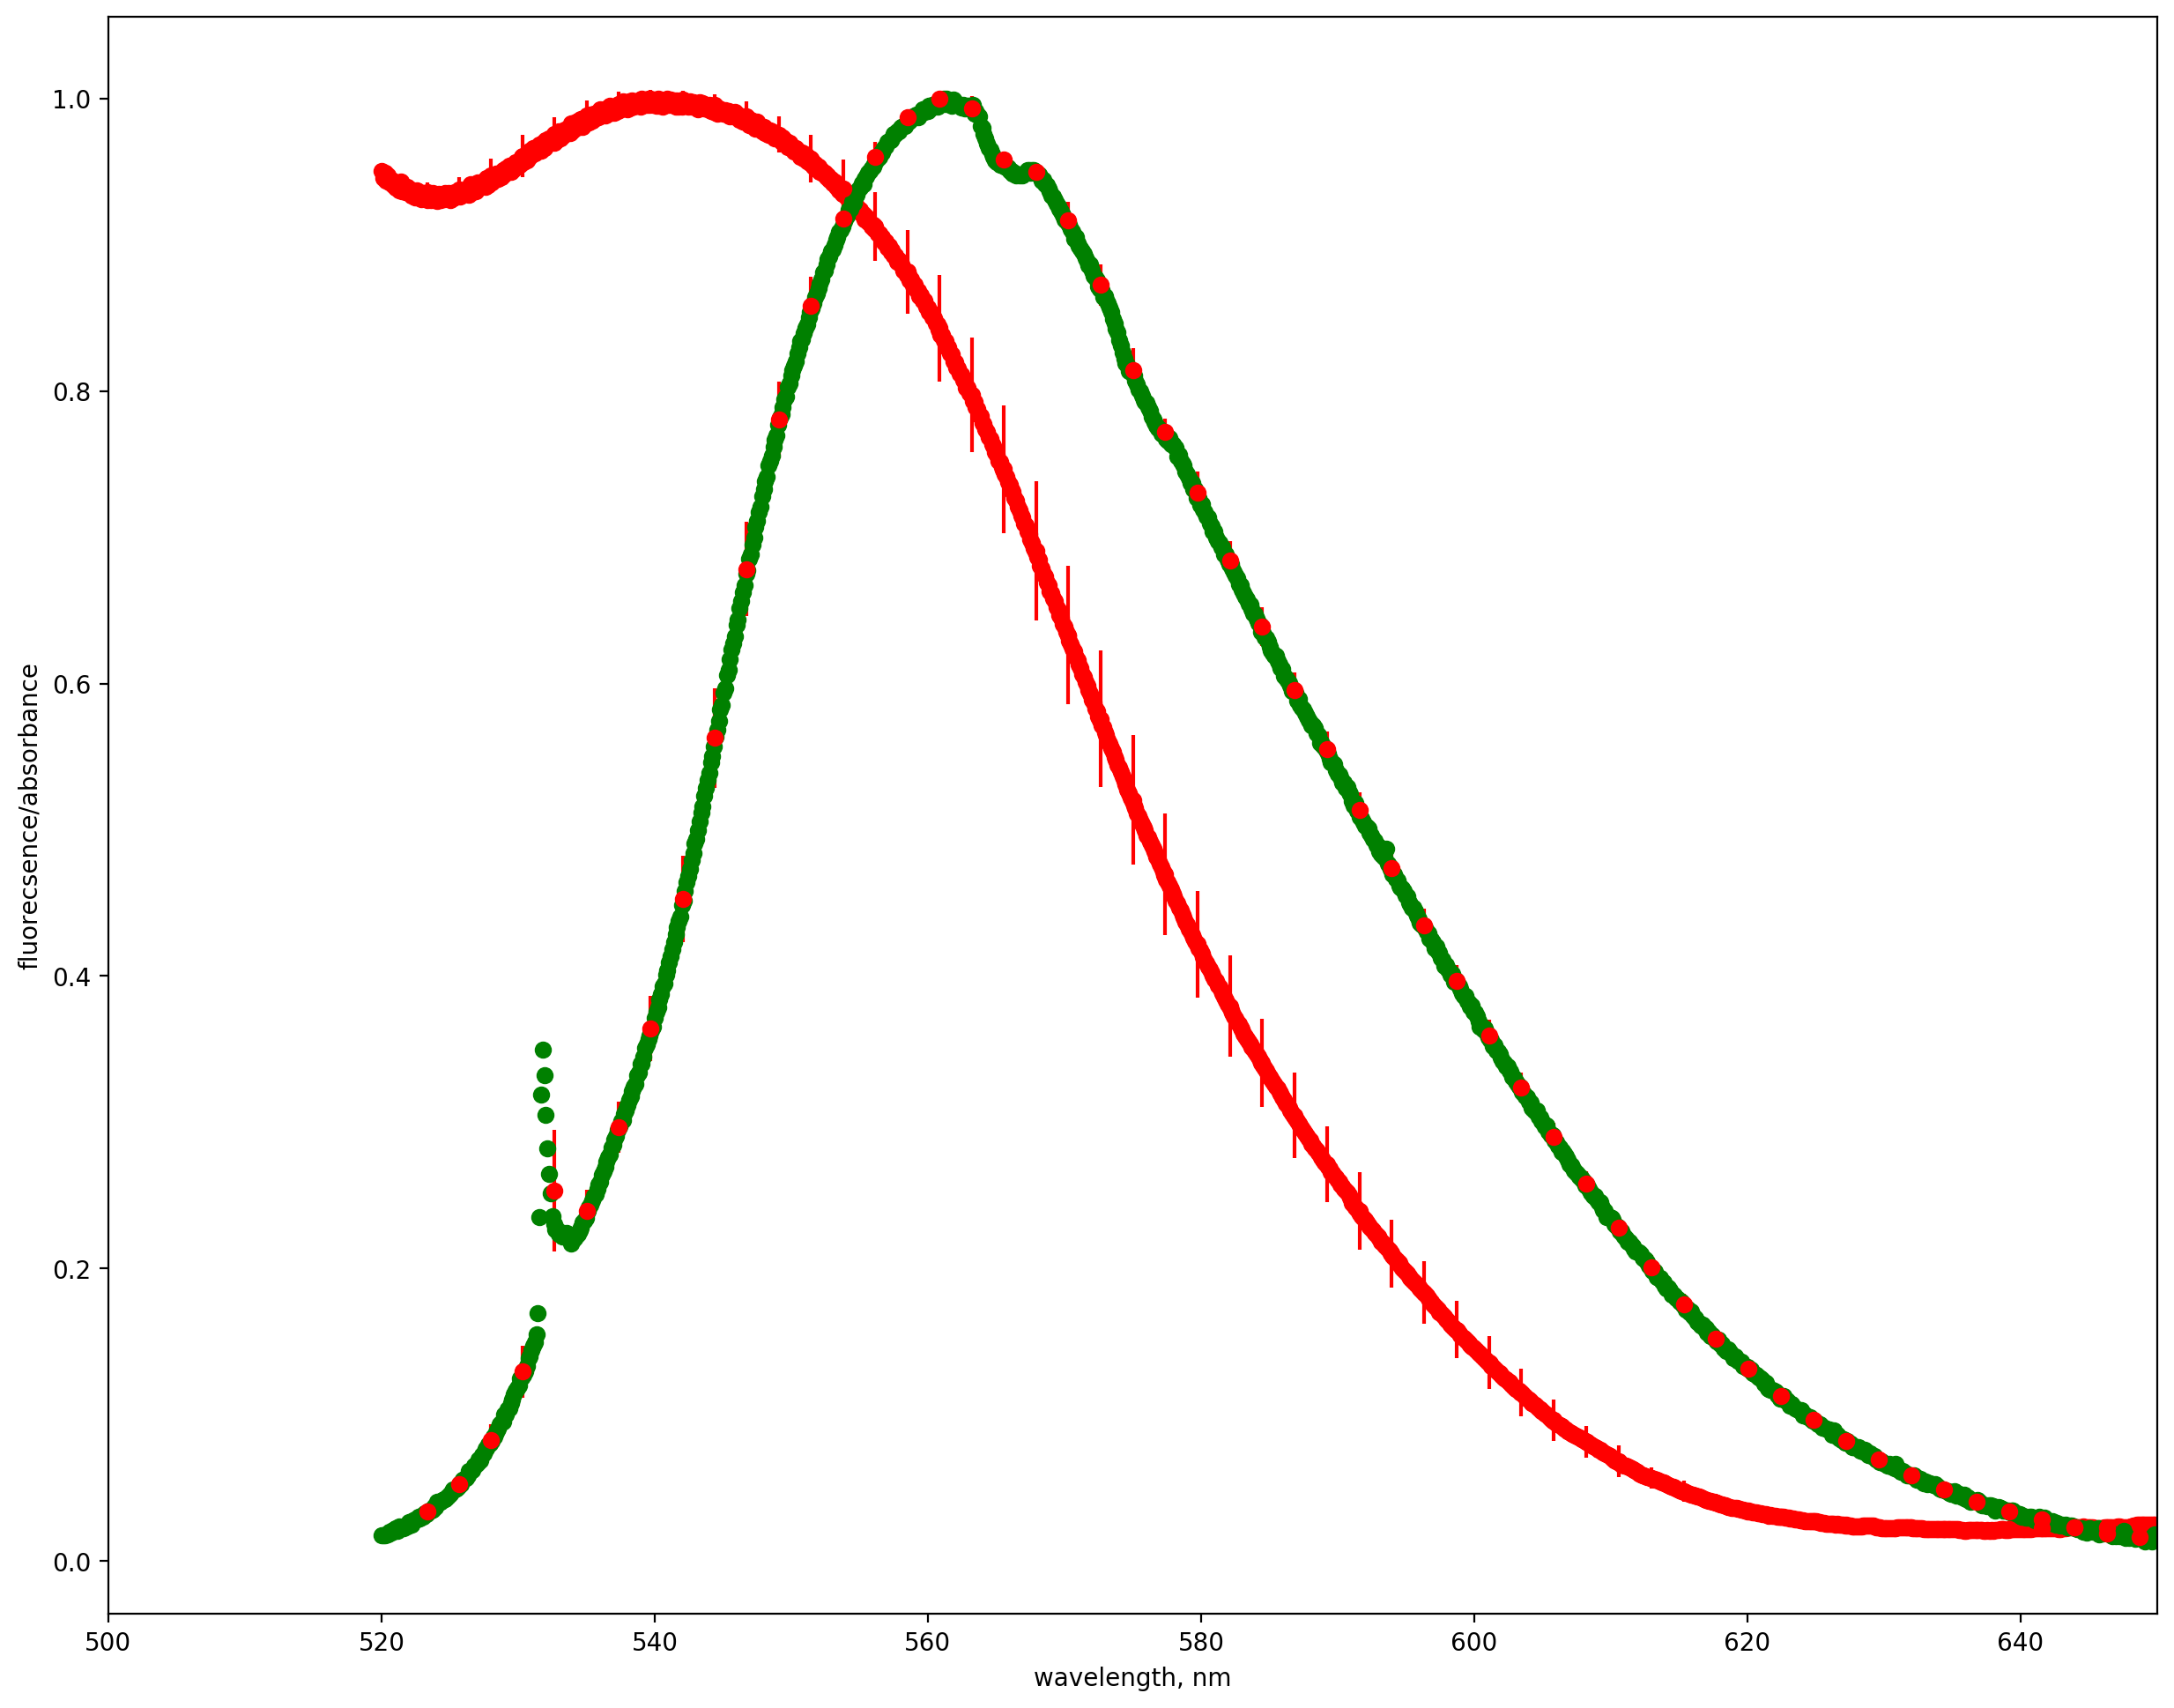

max fluorescence wl 561.3894653
max absorption wl 539.5283813


In [6]:
specdata1 = readSp('qd1/qd1_a_1x100.csv', ';')
specdata = readSp('qd1/qd1_ode_1x100.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')


stepaPlot(specdata1, specdata, specdata2)

specdata1 = readSp('qd1/qd1_a_1x50.csv', ';')
specdata = readSp('qd1/qd1_ode_1x50.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x50.csv', ';')


stepaPlot(specdata1, specdata, specdata2)

specdata1 = readSp('qd1/qd1_a_1x25.csv', ';')
specdata = readSp('qd1/qd1_ode_1x25.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x25.csv', ';')

stepaPlot(specdata1, specdata, specdata2)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in log


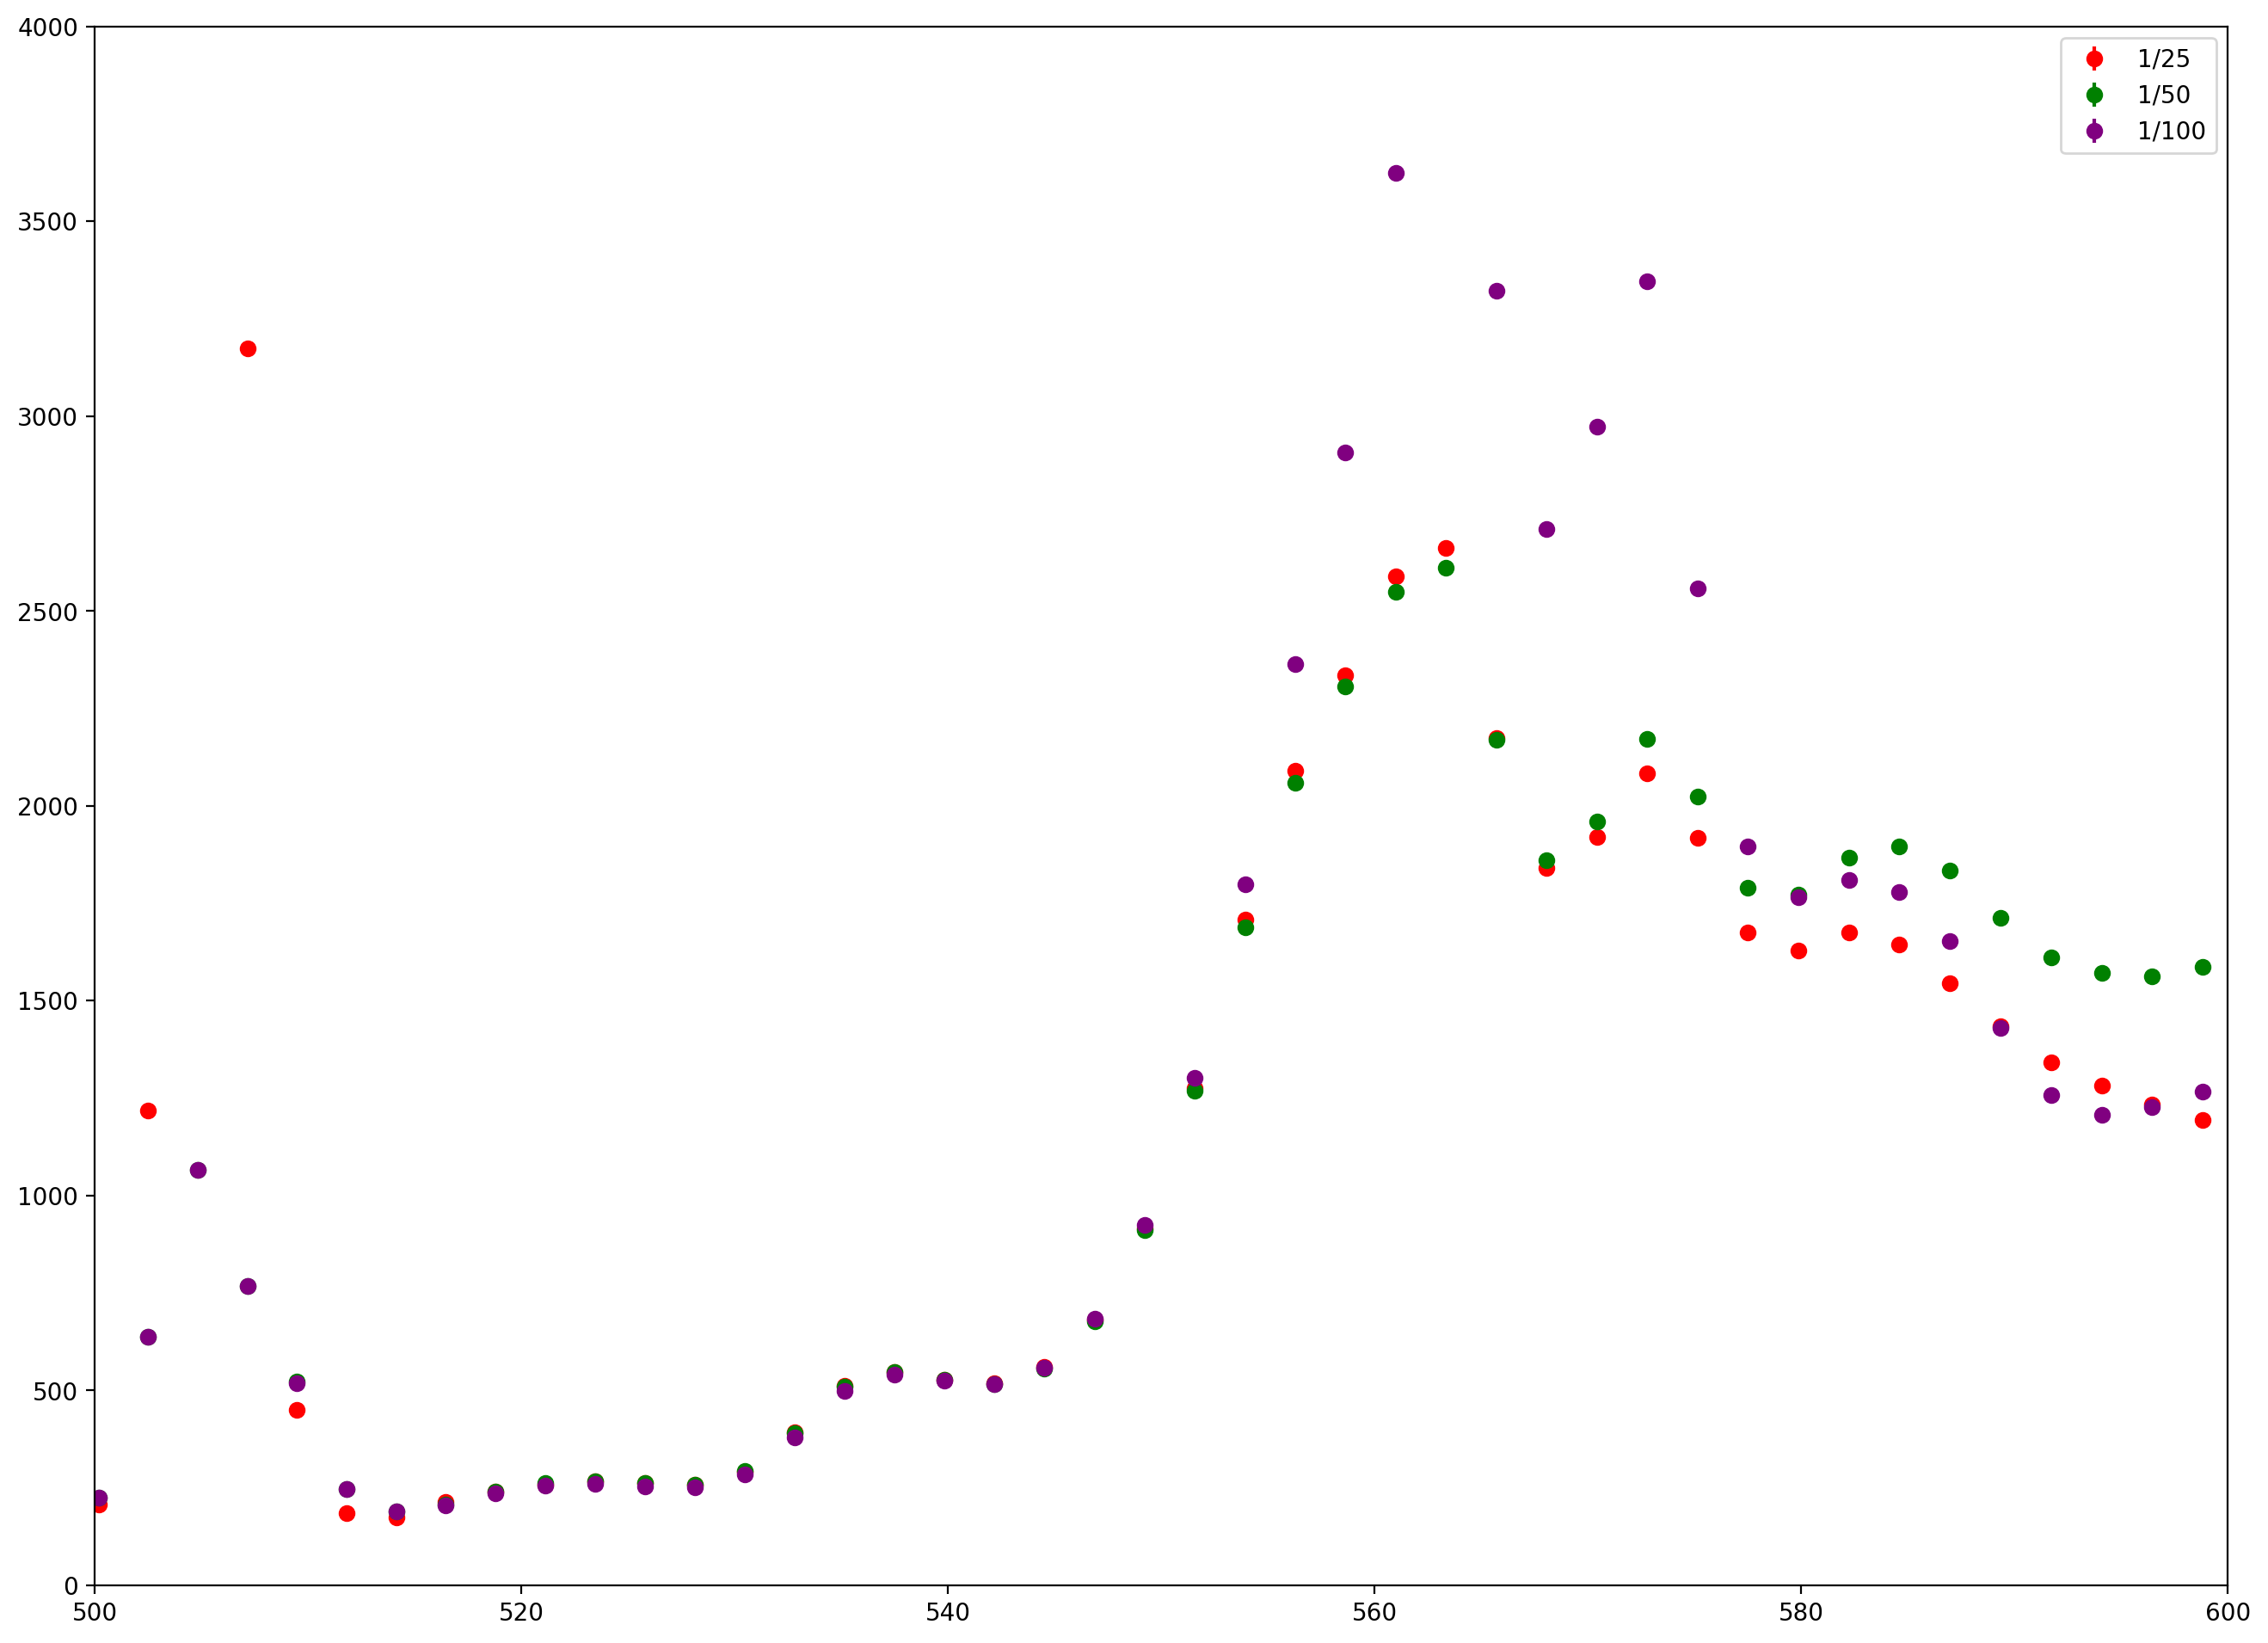

In [9]:
def smooth(x, y, downwl, upwl):
    down = np.where(x >= downwl)[0][0]
    up = np.where(x <= upwl)[0][-1]
    #ysmooth = savitzky_golay(y[down:up], 101, 3)
    ysmooth = savitzky_golay(y[down:up], 51, 3)
    #ysmooth = savitzky_golay(y[down:up], 101, 1)
    yOut = np.copy(y)
    yOut[down:up] = ysmooth
    return yOut

specdata1 = readSp('qd1/qd1_a_1x25.csv', ';')
specdata = readSp('qd1/qd1_ode_1x25.csv', delimiter = ';')

#specdata1 = readSp('qd1_18_02_closedAp/5.csv', ';')
#specdata = readSp('qd1_18_02_closedAp/1.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, False, False)
fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=200, facecolor='w', edgecolor='k')
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='red')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
#ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='black')

specdata1 = readSp('qd1/qd1_a_1x50.csv', ';')
specdata = readSp('qd1/qd1_ode_1x50.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='green')

specdata1 = readSp('qd1/qd1_a_1x100.csv', ';')
specdata = readSp('qd1/qd1_ode_1x100.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='purple')

specdata1 = readSp('qd1_a_2_2.csv', ';')
specdata = readSp('qd1_ocd_2.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, False)
#ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='blue')
plt.legend(('1/25', '1/50', '1/100'))

specdata1 = readSp('qd1AnotherSpectrom/qd1_a_1x50.csv', ';')
specdata = readSp('qd1AnotherSpectrom/qd1_ode_1x50.csv', delimiter = ';')
specdata2 = readSp('qd1AnotherSpectrom/qd1_f_1x50.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2)
#ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='yellow')

plt.ylim(0,4000)
plt.xlim(500, 600)
plt.show()

(500, 600)

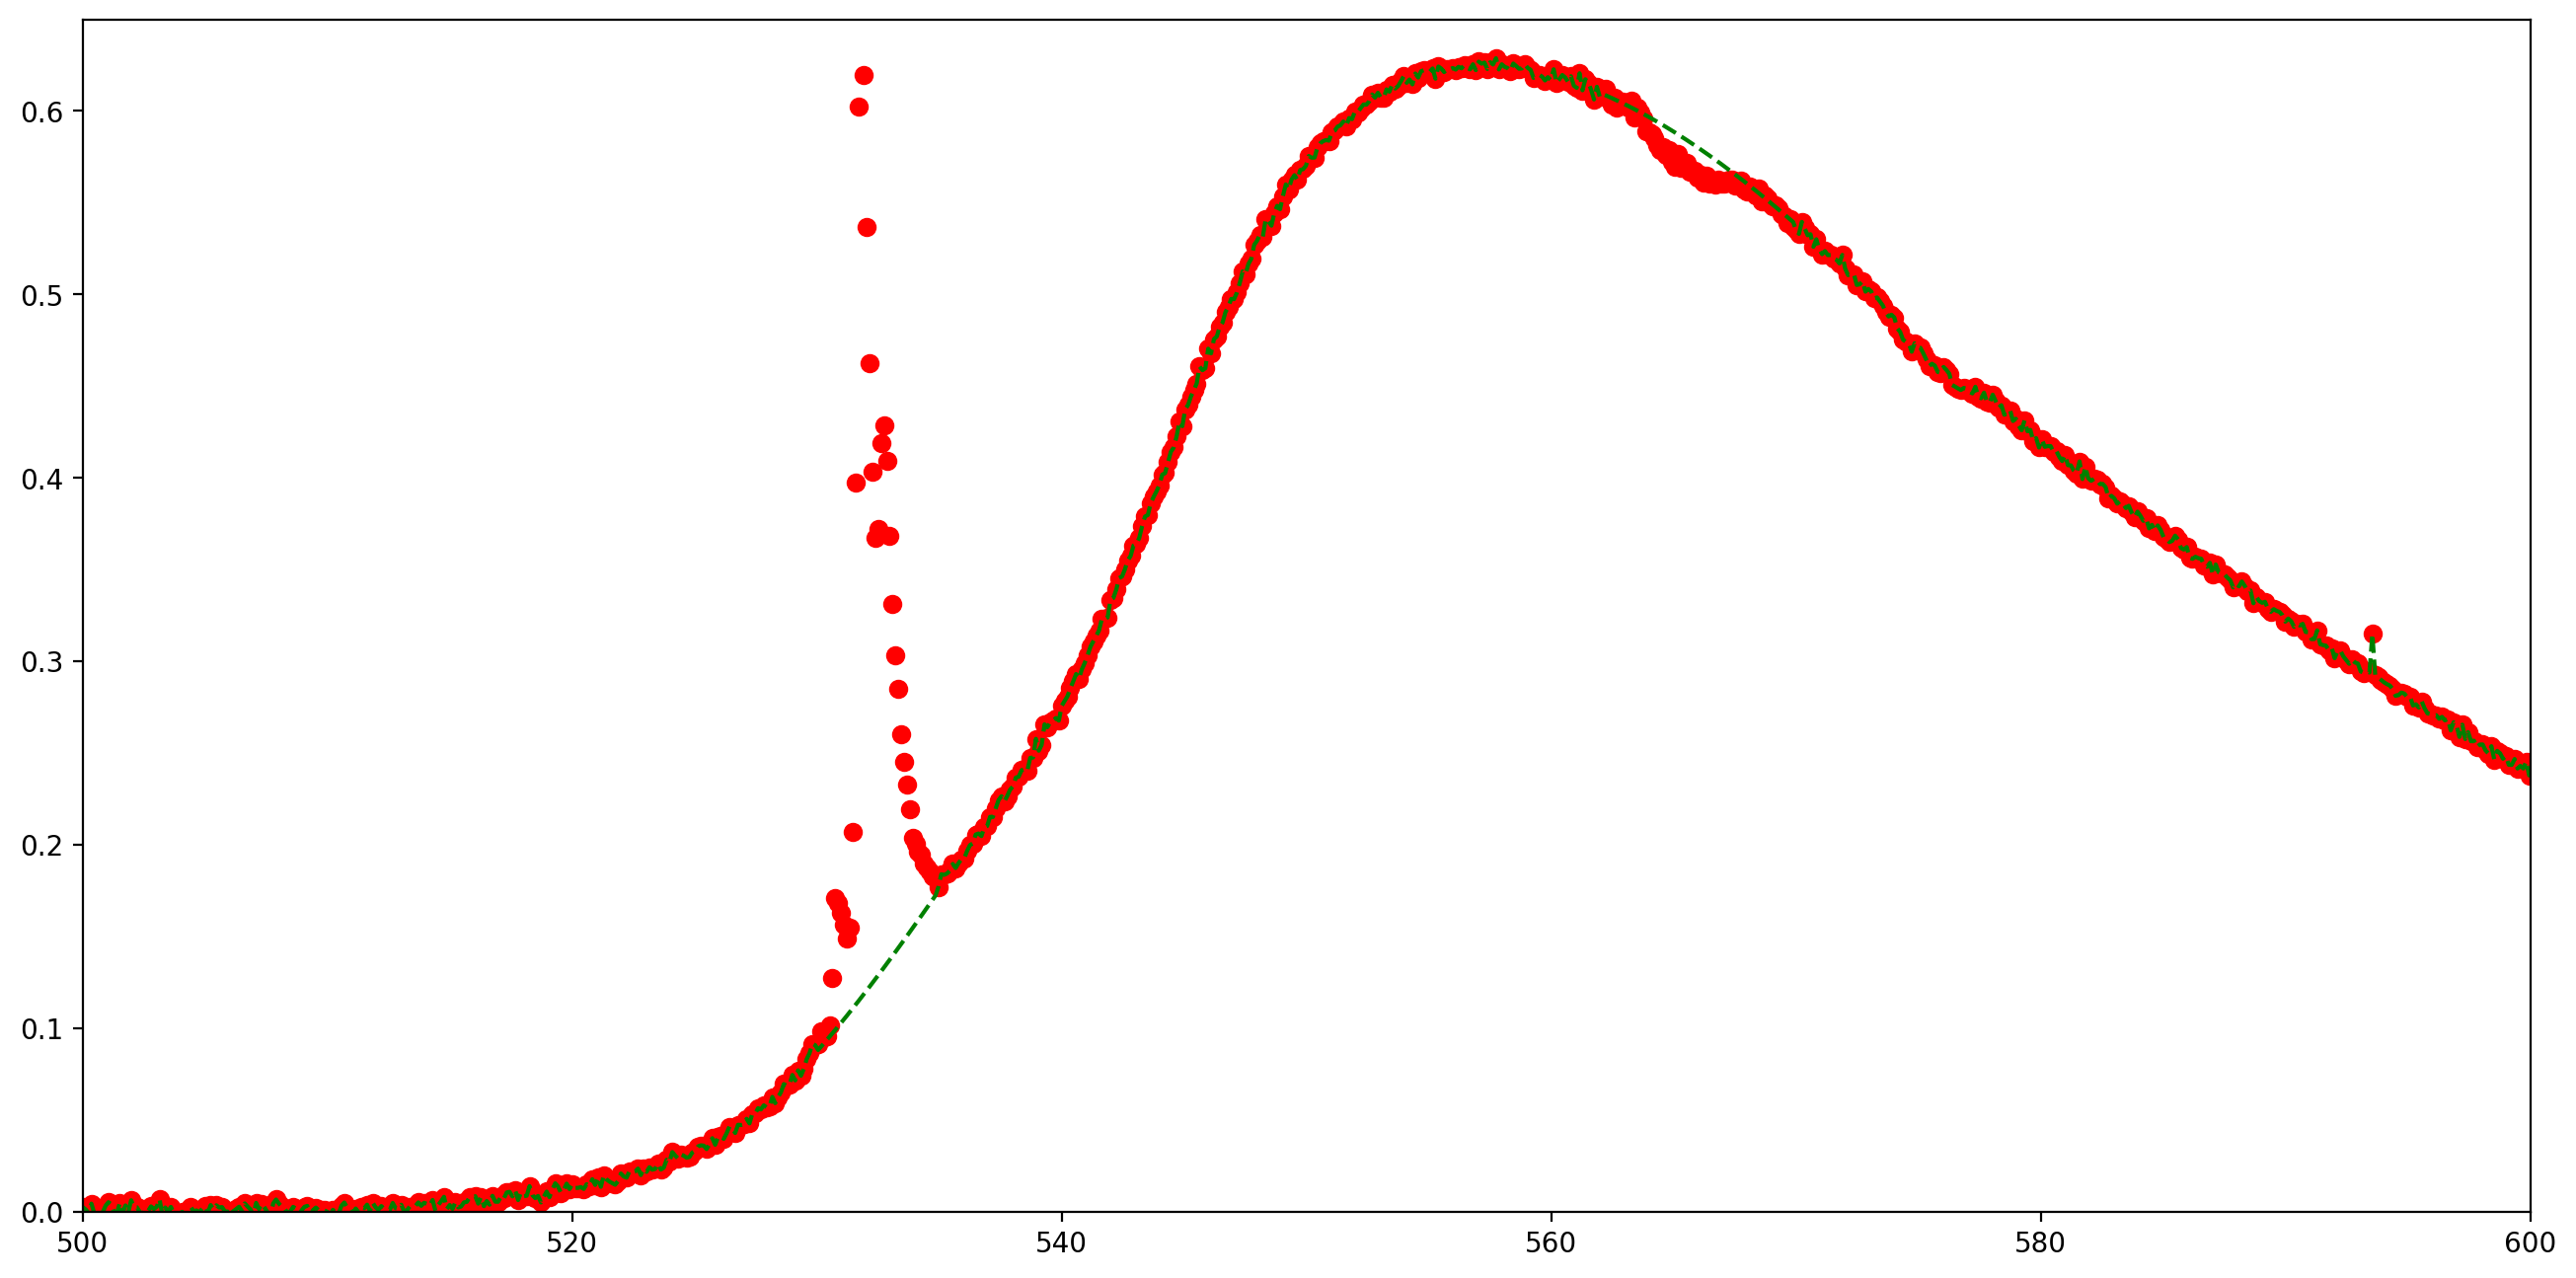

In [339]:



specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')
fig, ax = plt.subplots(num=None, figsize=(16, 8), dpi=200, facecolor='w', edgecolor='k')
ax.errorbar(specdata2[:,0], specdata2[:,1],  fmt='-o', linestyle='', color='red')

specdata2 = cleanSpec(specdata2)
specdata2 = cleanSpec(specdata2, 558,562,570,574)
specdata2 = cleanSpec(specdata2)

ax.errorbar(specdata2[:,0], specdata2[:,1], linestyle='--', color='green')
plt.ylim(0,0.65)
plt.xlim(500,600)

    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:160: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: RuntimeWarning: divide by zero encountered in true_divide
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in log


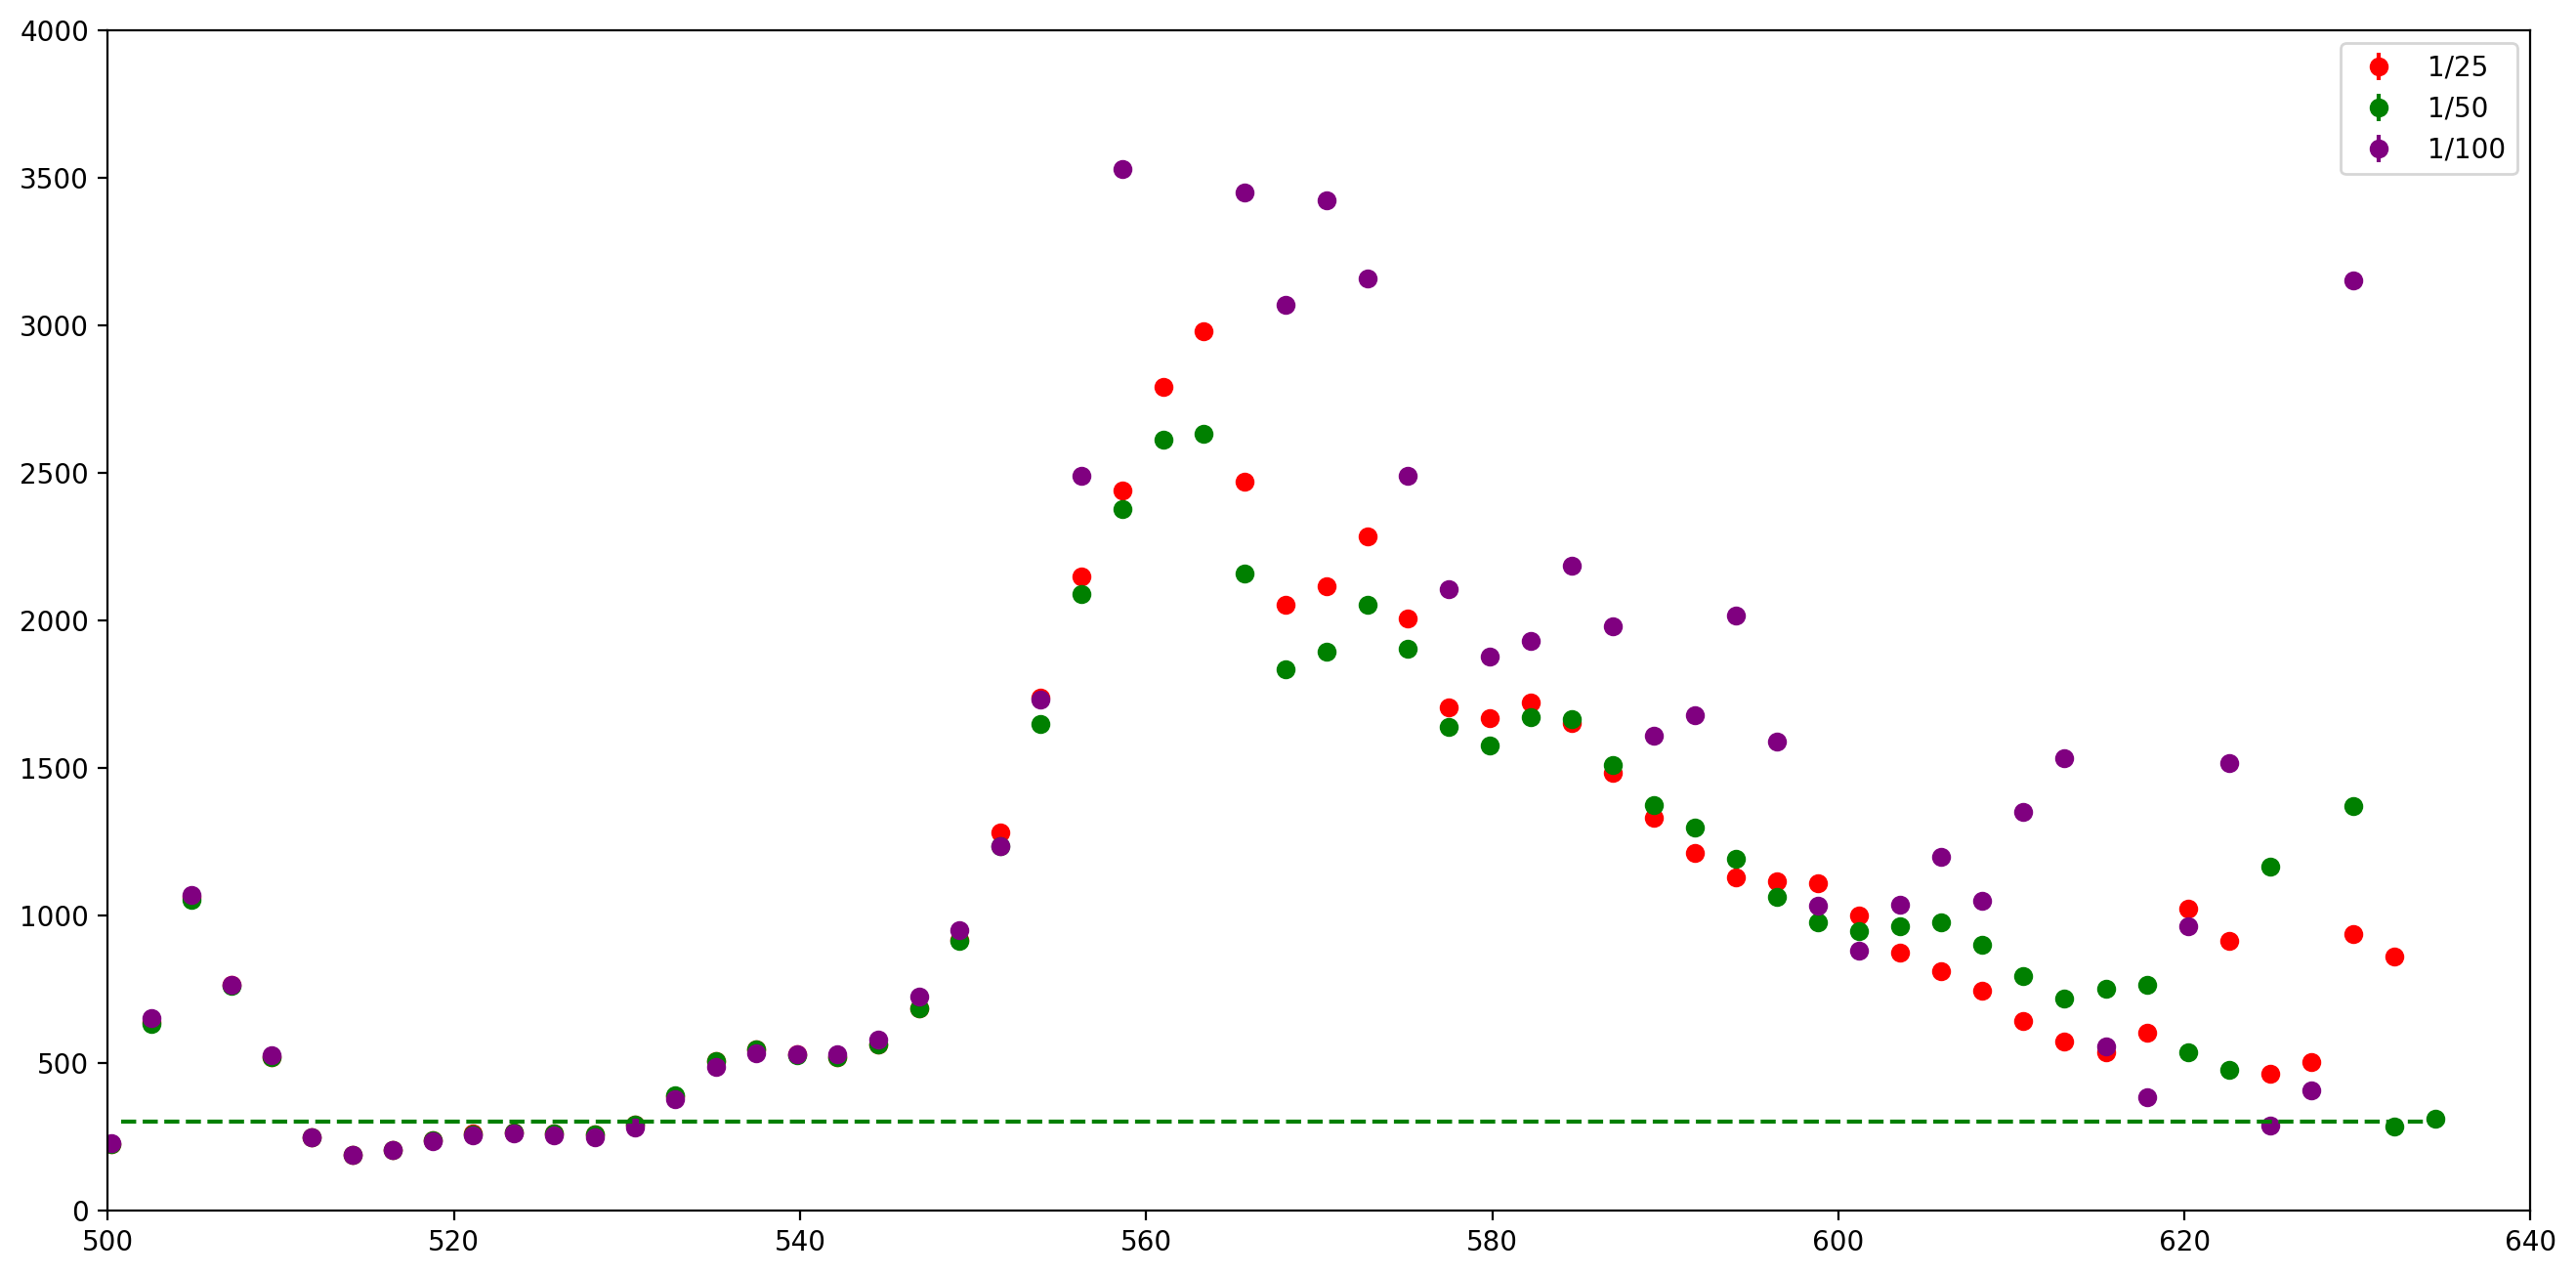

In [10]:
def smooth(x, y, downwl, upwl):
    down = np.where(x >= downwl)[0][0]
    up = np.where(x <= upwl)[0][-1]
    #ysmooth = savitzky_golay(y[down:up], 101, 3)
    ysmooth = savitzky_golay(y[down:up], 51, 2)
    #ysmooth = savitzky_golay(y[down:up], 101, 1)
    yOut = np.copy(y)
    yOut[down:up] = ysmooth
    return yOut

specdata1 = readSp('qd1_byOffset/2.csv', ';')
specdata = readSp('qd1_byOffset/1.csv', delimiter = ';')

#specdata1 = readSp('qd1_18_02_closedAp/5.csv', ';')
#specdata = readSp('qd1_18_02_closedAp/1.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
fig, ax = plt.subplots(num=None, figsize=(16, 8), dpi=200, facecolor='w', edgecolor='k')
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='red')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
#ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='black')

specdata1 = readSp('qd1_byOffset/3.csv', ';')
specdata = readSp('qd1_byOffset/1.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='green')

specdata1 = readSp('qd1_byOffset/4.csv', ';')
specdata = readSp('qd1_byOffset/1.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='purple')

specdata1 = readSp('qd1_a_2_2.csv', ';')
specdata = readSp('qd1_ocd_2.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
#ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='blue')
plt.legend(('1/25', '1/50', '1/100'))

specdata1 = readSp('qd1AnotherSpectrom/qd1_a_1x50.csv', ';')
specdata = readSp('qd1AnotherSpectrom/qd1_ode_1x50.csv', delimiter = ';')
specdata2 = readSp('qd1AnotherSpectrom/qd1_f_1x50.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2)
#ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='yellow')

ax.errorbar(wl1, np.ones(wl1.shape[0]) * 300, linestyle='--', color='green')

plt.ylim(0,4000)
plt.xlim(500, 640)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:154: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:161: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:162: RuntimeWarning: divide by zero encountered in true_divide


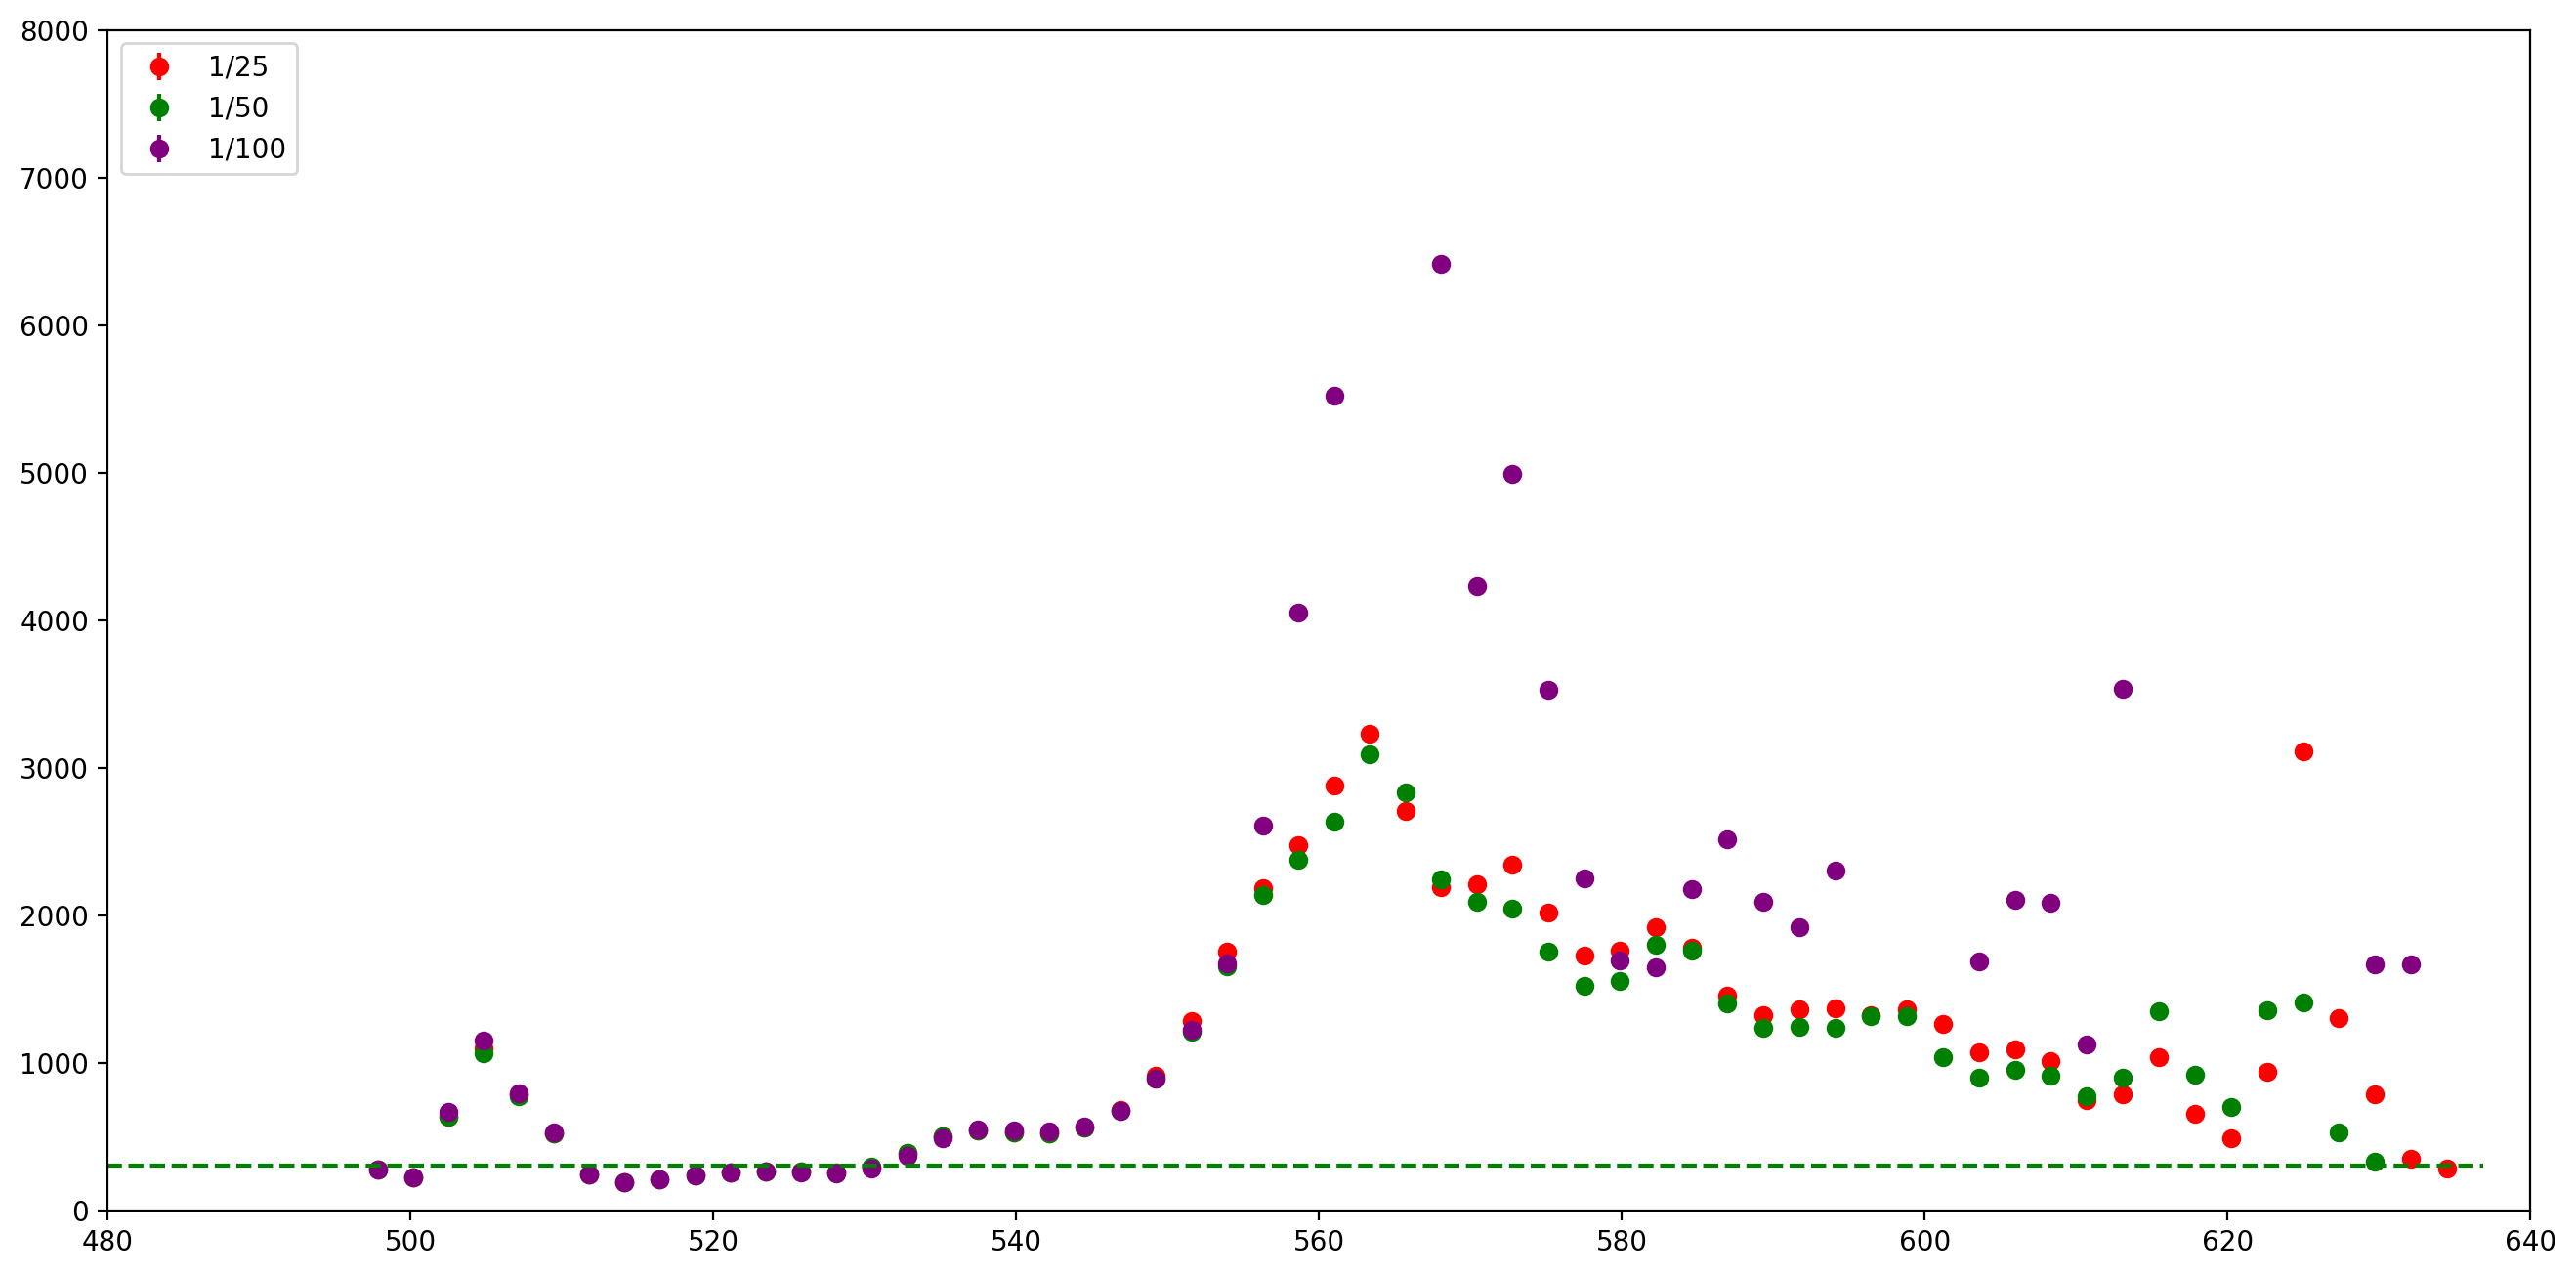

In [9]:
specdata1 = readSp('qd1_byOffset_2/2.csv', ';')
specdata = readSp('qd1_byOffset_2/1.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
fig, ax = plt.subplots(num=None, figsize=(16, 8), dpi=200, facecolor='w', edgecolor='k')
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='red')

specdata1 = readSp('qd1_byOffset_2/3.csv', ';')
specdata = readSp('qd1_byOffset_2/1.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='green')

specdata1 = readSp('qd1_byOffset_2/4.csv', ';')
specdata = readSp('qd1_byOffset_2/1.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='purple')

specdata1 = readSp('qd1_byOffset_2/5.csv', ';')
specdata = readSp('qd1_byOffset_2/1.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, True)
#ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='yellow')

ax.errorbar(wl1, np.ones(wl1.shape[0]) * 300, linestyle='--', color='green')

plt.legend(('1/25', '1/50', '1/100'))
plt.ylim(0,8000)
plt.xlim(480, 640)
plt.show()

561.3894653
561.8607788
558.9157104


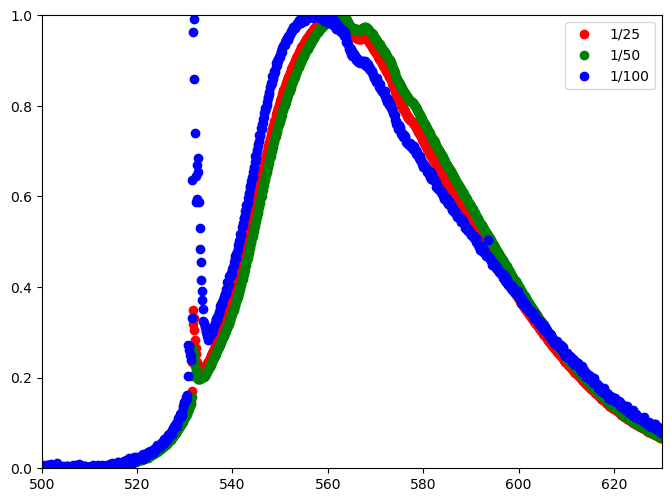

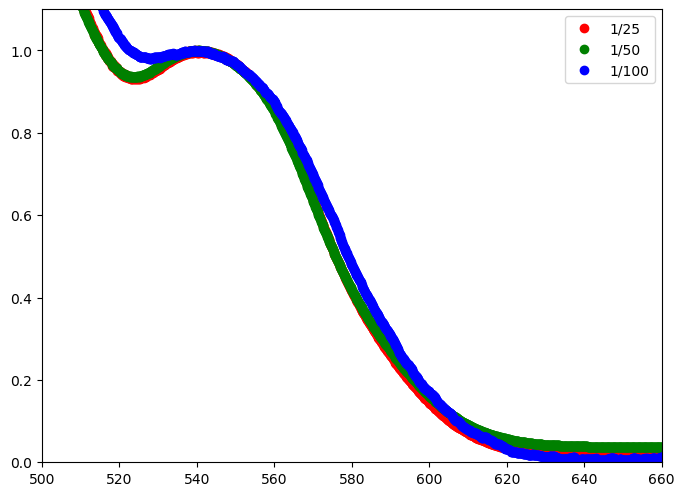

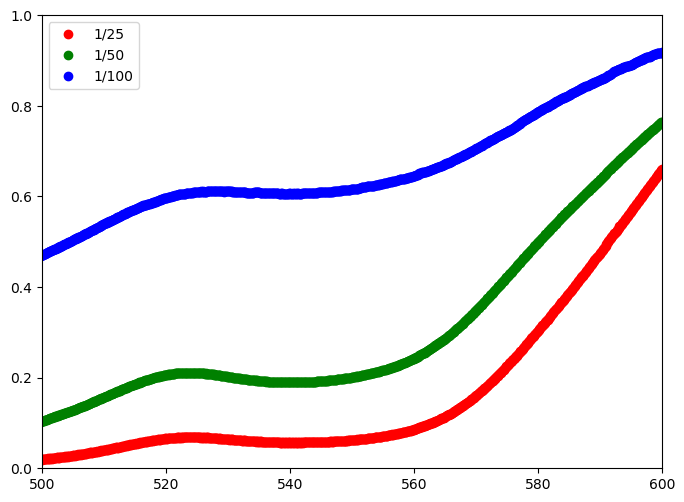

In [359]:
fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

#specdata1 = readSp('qd1/qd1_a_1x50.csv', ';')
#specdata = readSp('qd1/qd1_ode_1x50.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x25.csv', ';')
ax.errorbar(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), fmt='-o', linestyle='', color='red')
print(specdata2[np.where(specdata2[:,1] == max(specdata2[:,1]))[0][0],0])
specdata2 = readSp('qd1/qd1_f_1x50.csv', ';')
ax.errorbar(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), fmt='-o', linestyle='', color='green')
print(specdata2[np.where(specdata2[:,1] == max(specdata2[:,1]))[0][0],0])
specdata2 = readSp('qd1/qd1_f_1x100.csv', ';')
ax.errorbar(specdata2[:,0], specdata2[:,1]/max(specdata2[2000:,1]), fmt='-o', linestyle='', color='blue')

print(specdata2[np.where(specdata2[:,1] == max(specdata2[2000:,1]))[0][0],0])

plt.legend(('1/25', '1/50', '1/100'))


plt.xlim(500, 630)
plt.ylim(0, 1)
plt.show()
fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

specdata1 = readSp('qd1/qd1_a_1x25.csv', ';')
specdata = readSp('qd1/qd1_ode_1x25.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='red')

specdata1 = readSp('qd1/qd1_a_1x50.csv', ';')
specdata = readSp('qd1/qd1_ode_1x50.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='green')

specdata1 = readSp('qd1/qd1_a_1x100.csv', ';')
specdata = readSp('qd1/qd1_ode_1x100.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='blue')

#specdata1 = readSp('qd1/qd1_a_1x100.csv', ';')
#specdata = readSp('qd1/qd1_ode_1x100.csv', delimiter = ';')
#ax.errorbar(specdata1[:,0], specdata1[:,1]/specdata[:,1], fmt='-o', linestyle='', color='green')
plt.legend(('1/25', '1/50', '1/100'))

plt.xlim(500, 660)
plt.ylim(0,1.1)
plt.show()

fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

specdata1 = readSp('qd1/qd1_a_1x25.csv', ';')
specdata = readSp('qd1/qd1_ode_1x25.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], (specdata1[:,1]/specdata[:,1]), fmt='-o', linestyle='', color='red')

specdata1 = readSp('qd1/qd1_a_1x50.csv', ';')
specdata = readSp('qd1/qd1_ode_1x50.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], (specdata1[:,1]/specdata[:,1]), fmt='-o', linestyle='', color='green')

specdata1 = readSp('qd1/qd1_a_1x100.csv', ';')
specdata = readSp('qd1/qd1_ode_1x100.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], (specdata1[:,1]/specdata[:,1]), fmt='-o', linestyle='', color='blue')
plt.legend(('1/25', '1/50', '1/100'))

plt.xlim(500, 600)
plt.ylim(0,1)
plt.show()

564.2182007
561.1538086
561.1538086


(500, 630)

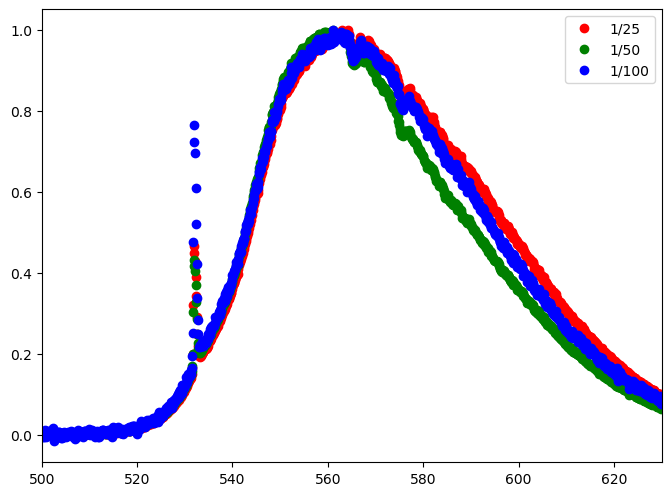

In [356]:
fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

#specdata1 = readSp('qd1/qd1_a_1x50.csv', ';')
#specdata = readSp('qd1/qd1_ode_1x50.csv', delimiter = ';')
specdata2 = readSp('qd1_fluor/1.csv', ';')
ax.errorbar(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), fmt='-o', linestyle='', color='red')
print(specdata2[np.where(specdata2[:,1] == max(specdata2[:,1]))[0][0],0])
specdata2 = readSp('qd1_fluor/2.csv', ';')
ax.errorbar(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), fmt='-o', linestyle='', color='green')
print(specdata2[np.where(specdata2[:,1] == max(specdata2[:,1]))[0][0],0])
specdata2 = readSp('qd1_fluor/3.csv', ';')
ax.errorbar(specdata2[:,0], specdata2[:,1]/max(specdata2[2000:,1]), fmt='-o', linestyle='', color='blue')
print(specdata2[np.where(specdata2[:,1] == max(specdata2[:,1]))[0][0],0])

plt.legend(('1/25', '1/50', '1/100'))
plt.xlim(500, 630)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in log


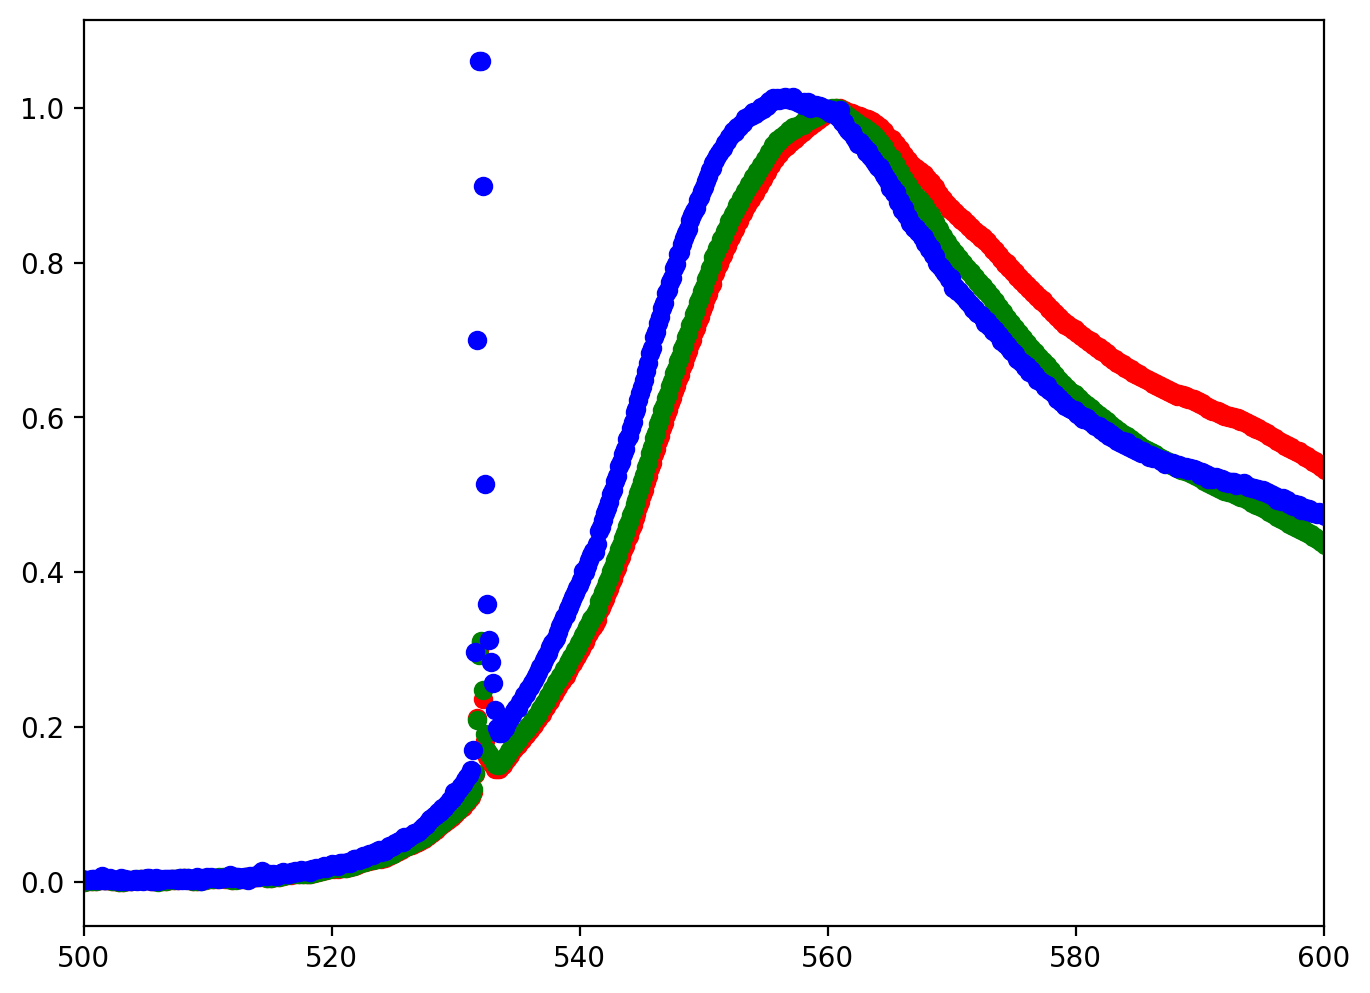

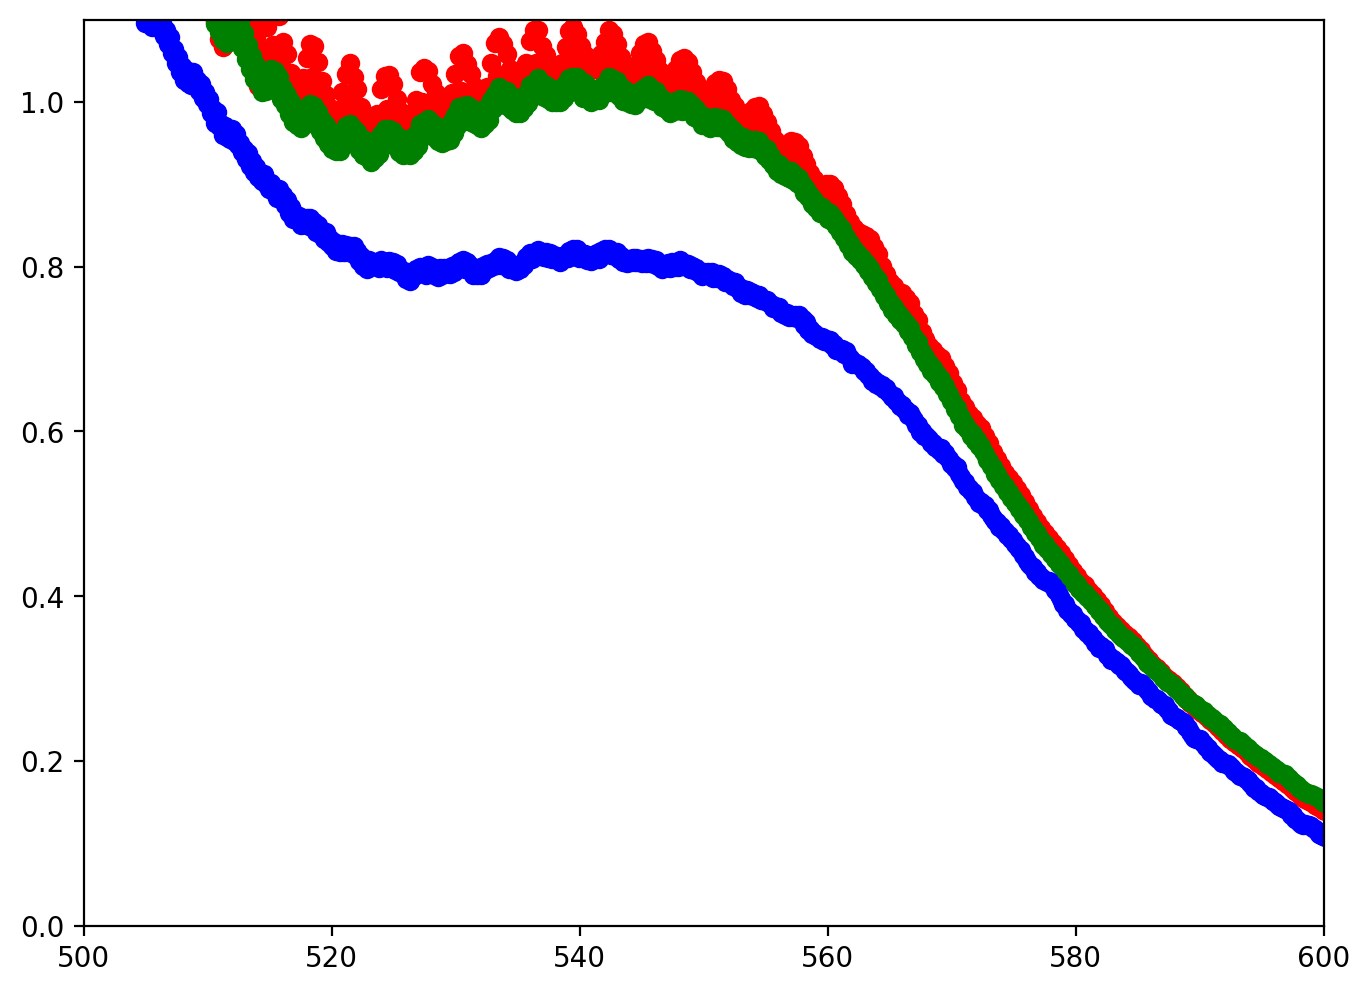

In [44]:
fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')

#specdata1 = readSp('qd1/qd1_a_1x50.csv', ';')
#specdata = readSp('qd1/qd1_ode_1x50.csv', delimiter = ';')
specdata2 = readSp('qd1AnotherSpectrom/qd1_f_1x25.csv', ';')
ax.errorbar(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), fmt='-o', linestyle='', color='red')
specdata2 = readSp('qd1AnotherSpectrom/qd1_f_1x50.csv', ';')
ax.errorbar(specdata2[:,0], specdata2[:,1]/max(specdata2[:,1]), fmt='-o', linestyle='', color='green')
specdata2 = readSp('qd1AnotherSpectrom/qd1_f_1x100.csv', ';')
ax.errorbar(specdata2[:,0], specdata2[:,1]/max(specdata2[390:,1]), fmt='-o', linestyle='', color='blue')

plt.xlim(500, 600)
fig, ax = plt.subplots(num=None, figsize=(8, 6), dpi=200, facecolor='w', edgecolor='k')

specdata1 = readSp('qd1AnotherSpectrom/qd1_a_1x25.csv', ';')
specdata = readSp('qd1AnotherSpectrom/qd1_ode_1x25.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='red')

specdata1 = readSp('qd1AnotherSpectrom/qd1_a_1x50.csv', ';')
specdata = readSp('qd1AnotherSpectrom/qd1_ode_1x50.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='green')

specdata1 = readSp('qd1AnotherSpectrom/qd1_a_1x100.csv', ';')
specdata = readSp('qd1AnotherSpectrom/qd1_ode_1x100.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='blue')

#specdata1 = readSp('qd1/qd1_a_1x100.csv', ';')
#specdata = readSp('qd1/qd1_ode_1x100.csv', delimiter = ';')
#ax.errorbar(specdata1[:,0], specdata1[:,1]/specdata[:,1], fmt='-o', linestyle='', color='green')

plt.xlim(500, 600)
plt.ylim(0,1.1)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]


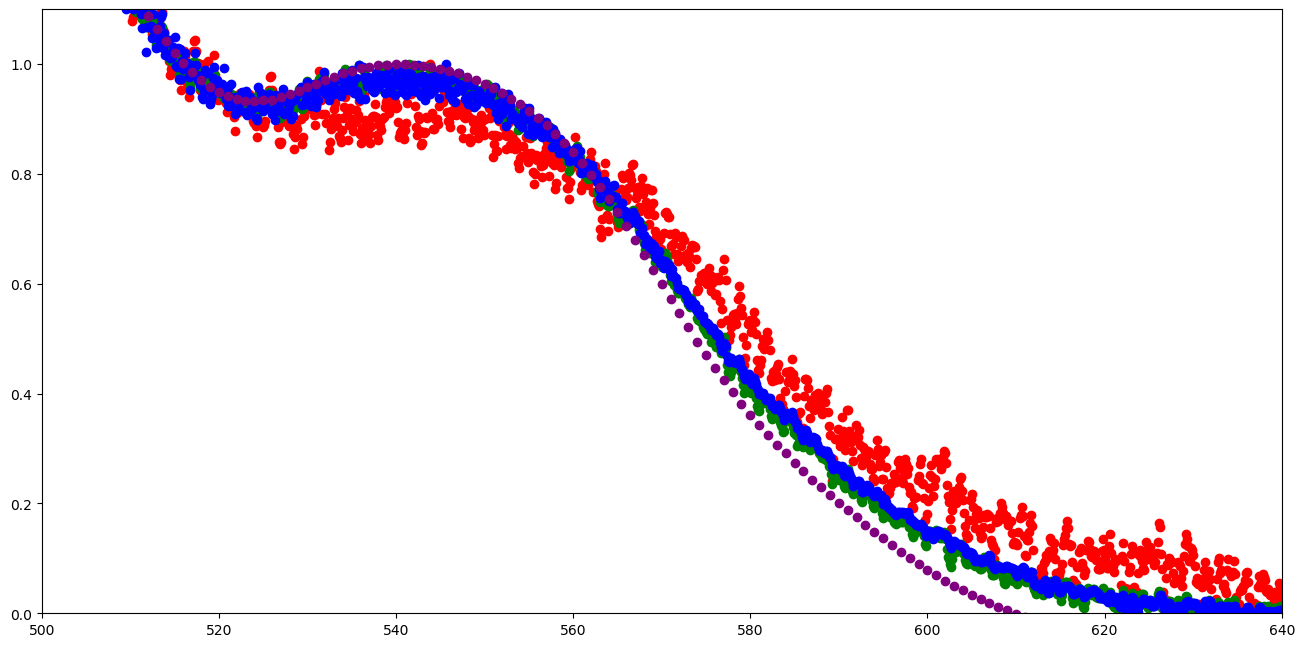

In [316]:
fig, ax = plt.subplots(num=None, figsize=(16, 8), dpi=100, facecolor='w', edgecolor='k')

specdata1 = readSp('qd1_byOffset_2/4.csv', ';')
specdata = readSp('qd1_byOffset_2/1.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='red')

specdata1 = readSp('qd1_byOffset_2/3.csv', ';')
specdata = readSp('qd1_byOffset_2/1.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='green')

specdata1 = readSp('qd1_byOffset_2/2.csv', ';')
specdata = readSp('qd1_byOffset_2/1.csv', delimiter = ';')
ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='blue')

specdataQDA = np.genfromtxt('fromMit/abs_1', delimiter = '\t')
ax.errorbar(specdataQDA[:,0], specdataQDA[:,1]/max(specdataQDA[:-180,1]), fmt='-o', linestyle='', color='purple')

specdata1 = readSp('qd1_18_02_closedAp/2.csv', ';')
specdata = readSp('qd1_18_02_closedAp/1.csv', ';')
#ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='red')

specdata1 = readSp('qd1_18_02_closedAp/3.csv', ';')
specdata = readSp('qd1_18_02_closedAp/1.csv', ';')
#ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='green')

specdata1 = readSp('qd1_18_02_closedAp/4.csv', ';')
specdata = readSp('qd1_18_02_closedAp/1.csv', ';')
#ax.errorbar(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1])/max(np.log(specdata[1800:,1]/specdata1[1800:,1])), fmt='-o', linestyle='', color='blue')

#plt.legend(('1/25', '1/50', '1/100'))

plt.xlim(500, 640)
plt.ylim(0,1.1)
plt.show()

In [88]:
specdata[1800:,0]

array([535.4277344, 535.5448608, 535.6619263, ..., 754.927063 ,
       755.0465088, 755.1658936])

In [111]:
specdata[1800:,0]

array([535.4277344, 535.5448608, 535.6619263, ..., 754.927063 ,
       755.0465088, 755.1658936])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:146: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:153: RuntimeWarning: invalid value encountered in log
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:154: RuntimeWarning: divide by zero encountered in true_divide


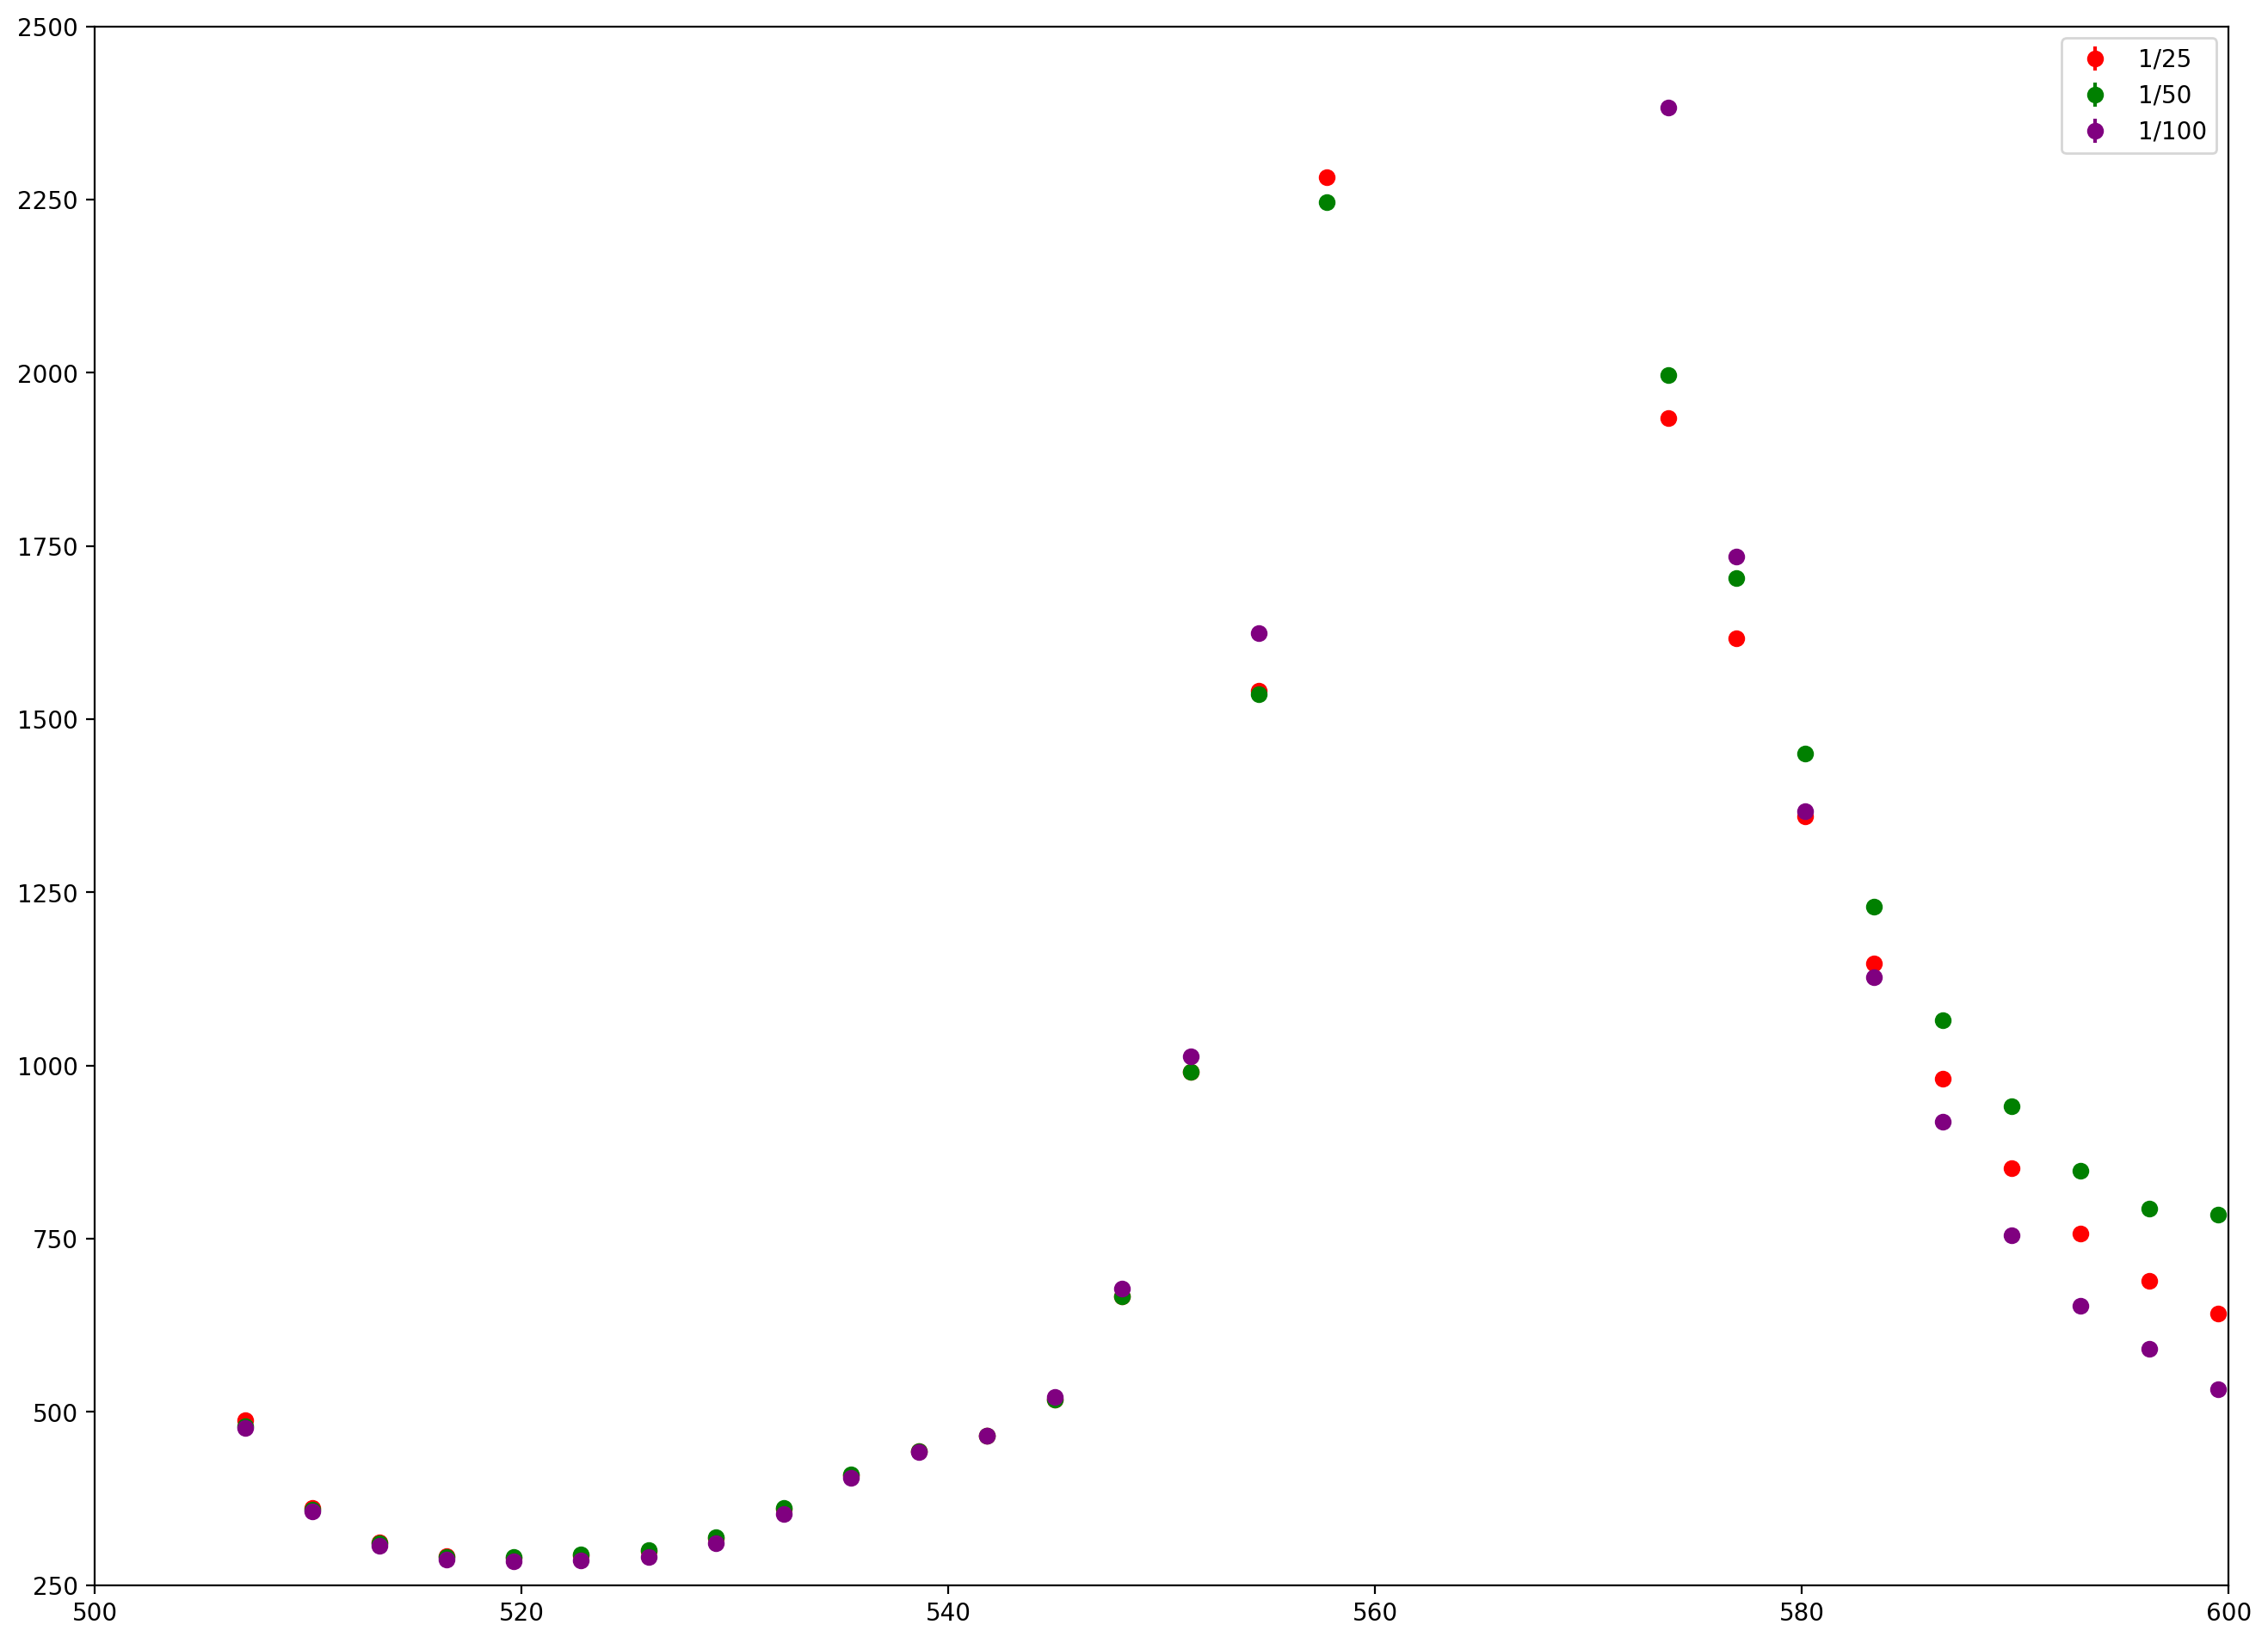

In [261]:
specdata1 = readSp('qd1AnotherSpectrom/qd1_a_1x25.csv', ';')
specdata = readSp('qd1AnotherSpectrom/qd1_ode_1x25.csv', delimiter = ';')
specdata2 = readSp('qd1AnotherSpectrom/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, False)
fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=200, facecolor='w', edgecolor='k')
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='red')

specdata1 = readSp('qd1AnotherSpectrom/qd1_a_1x50.csv', ';')
specdata = readSp('qd1AnotherSpectrom/qd1_ode_1x50.csv', delimiter = ';')
specdata2 = readSp('qd1AnotherSpectrom/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, False)
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='green')

specdata1 = readSp('qd1AnotherSpectrom/qd1_a_1x100.csv', ';')
specdata = readSp('qd1AnotherSpectrom/qd1_ode_1x100.csv', delimiter = ';')
specdata2 = readSp('qd1AnotherSpectrom/qd1_f_1x100.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2, False)
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='purple')

plt.legend( ('1/25', '1/50', '1/100'))
plt.ylim(250,2500)
plt.xlim(500, 600)
plt.show()

(500, 600)

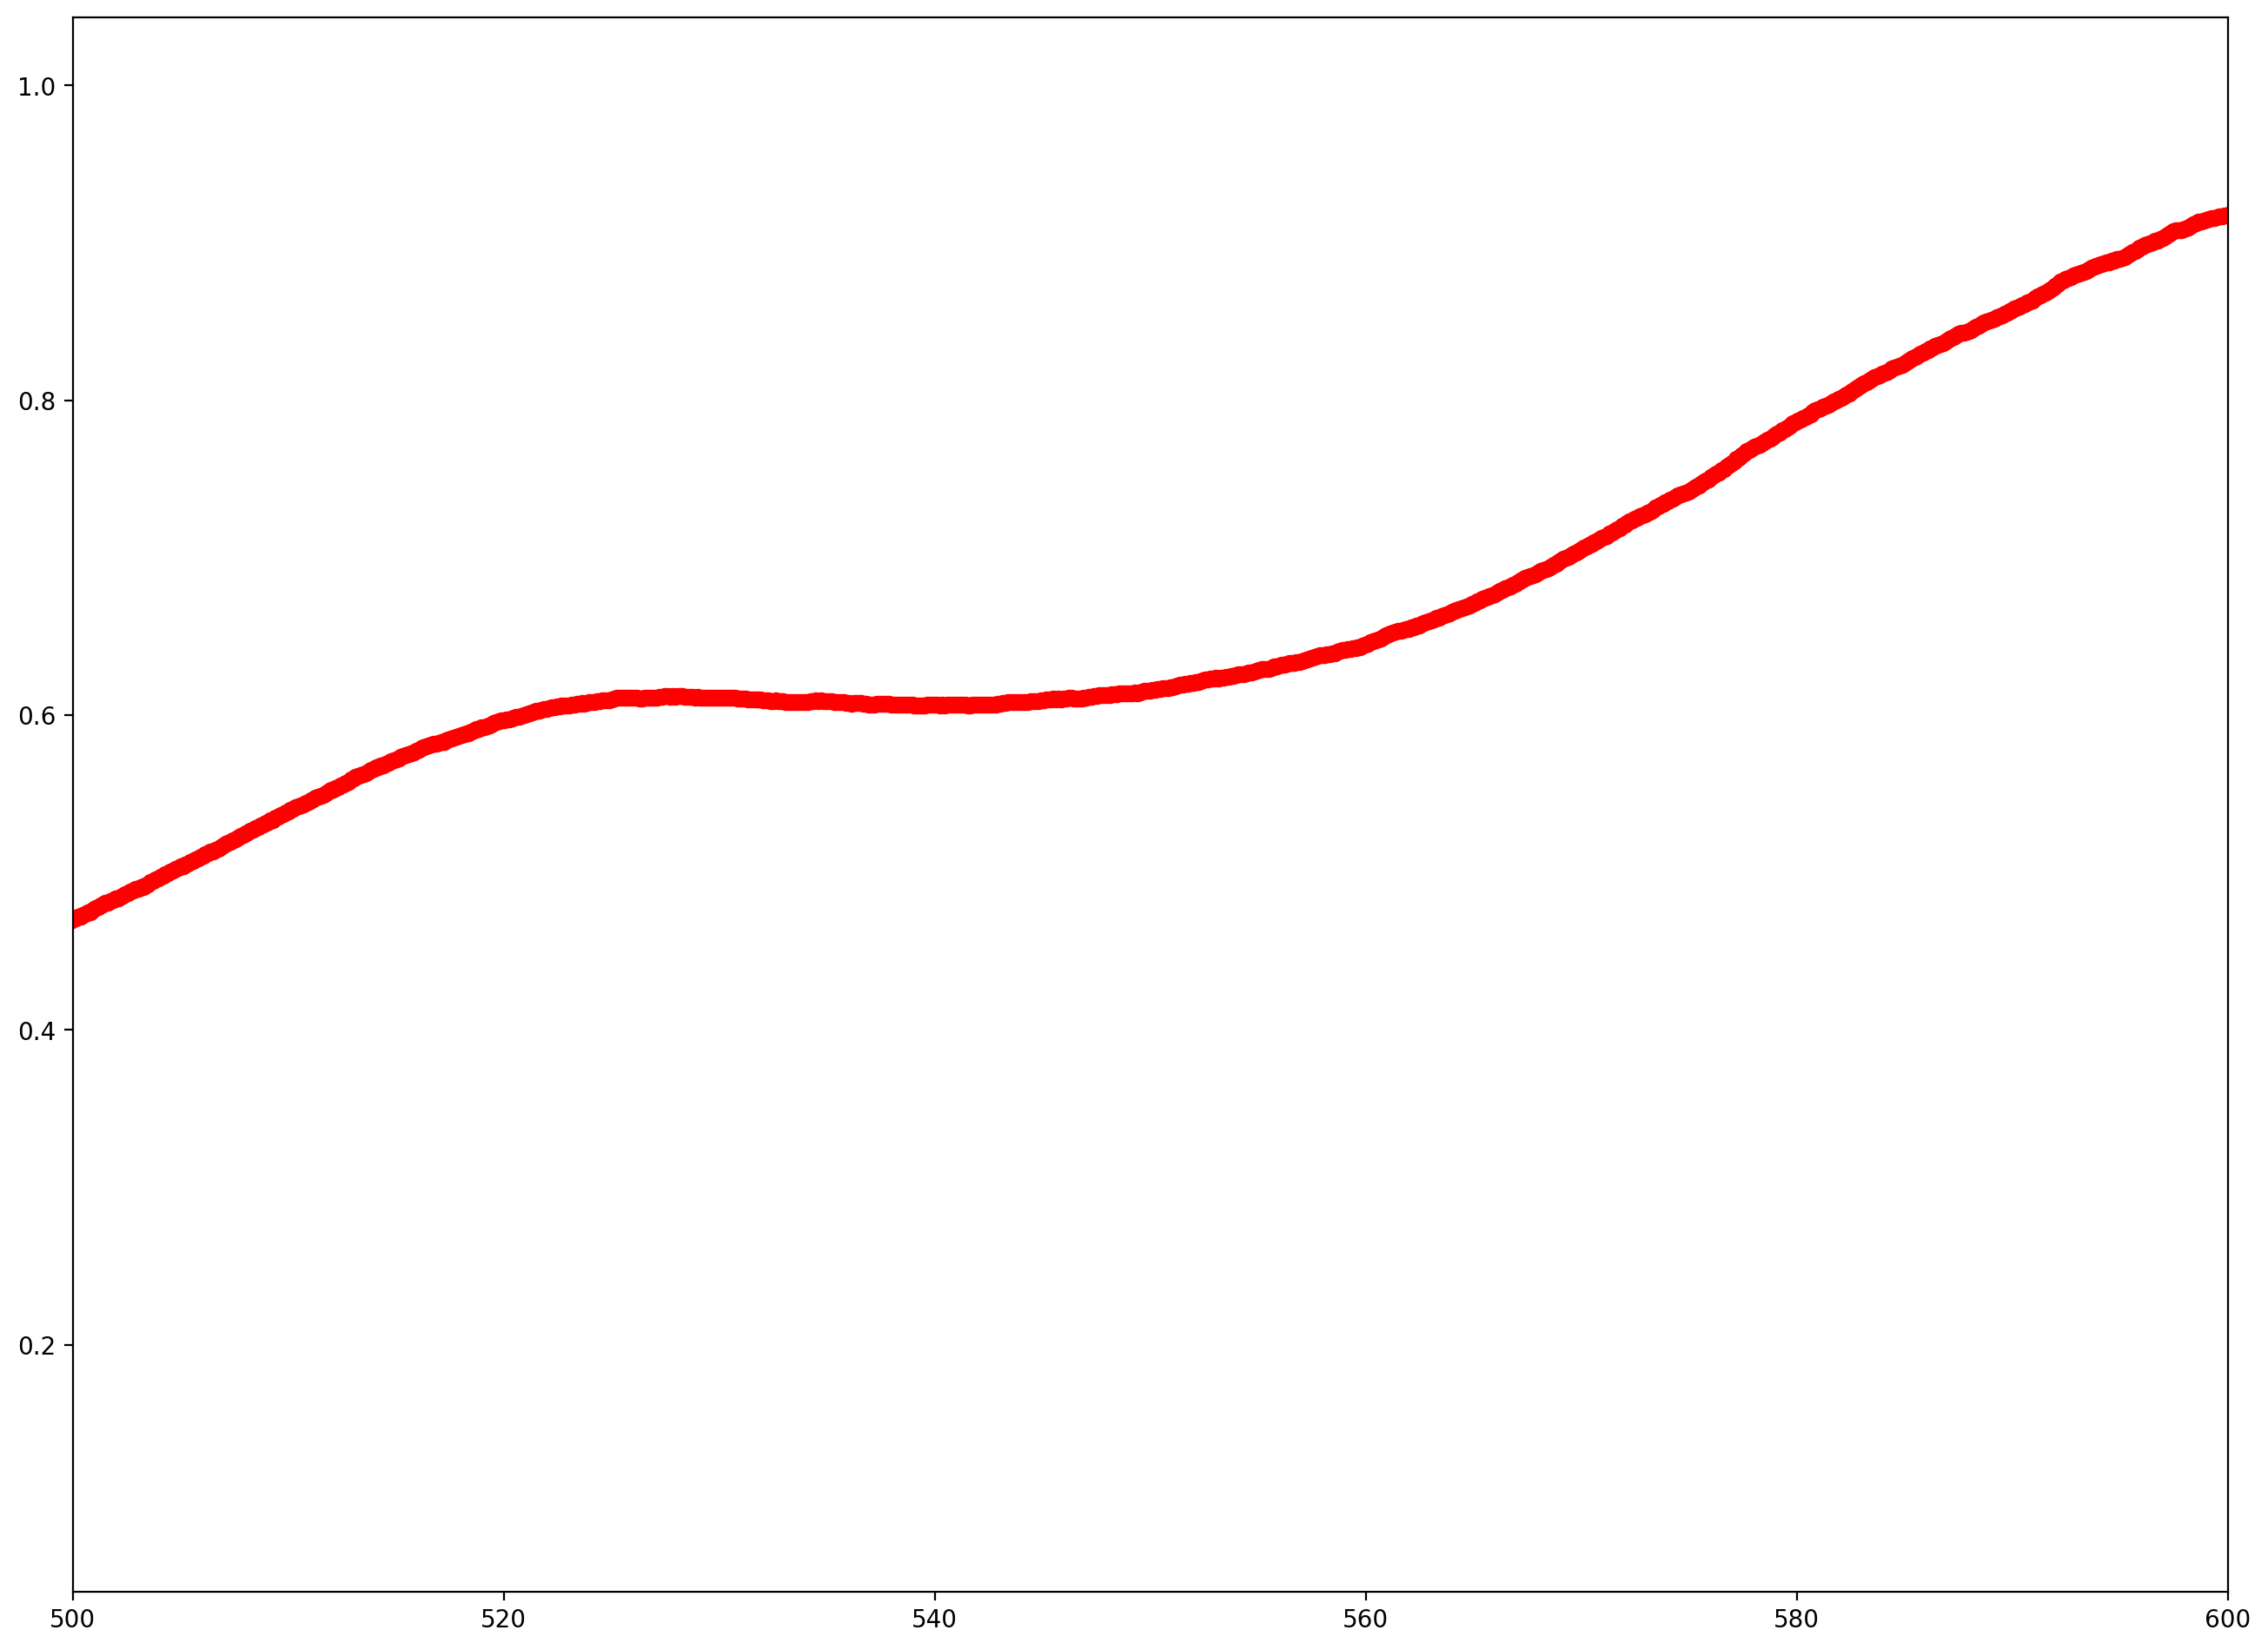

In [13]:
specdata1 = readSp('qd1/qd1_a_1x100.csv', ';')
specdata = readSp('qd1/qd1_ode_1x100.csv', delimiter = ';')

fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=200, facecolor='w', edgecolor='k')
ax.errorbar(specdata1[:,0], specdata1[:,1]/specdata[:,1], fmt='-o', linestyle='', color='red')

plt.xlim(500,600)

In [15]:
specdata1 = readSp('rd6_a_18.csv', ';')
specdata = readSp('rd6_ethGl_18.csv', delimiter = ';')
specdata2 = readSp('rd6_f_13.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2)
fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=200, facecolor='w', edgecolor='k')
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='red')

specdata1 = readSp('rd6_a_21.csv', ';')
specdata = readSp('rd6_ethGl_21.csv', delimiter = ';')
specdata2 = readSp('rd6_f_20.csv', ';')
wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2)
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='blue')
plt.ylim(200, 500)

FileNotFoundError: [Errno 2] No such file or directory: 'rd6_a_18.csv'

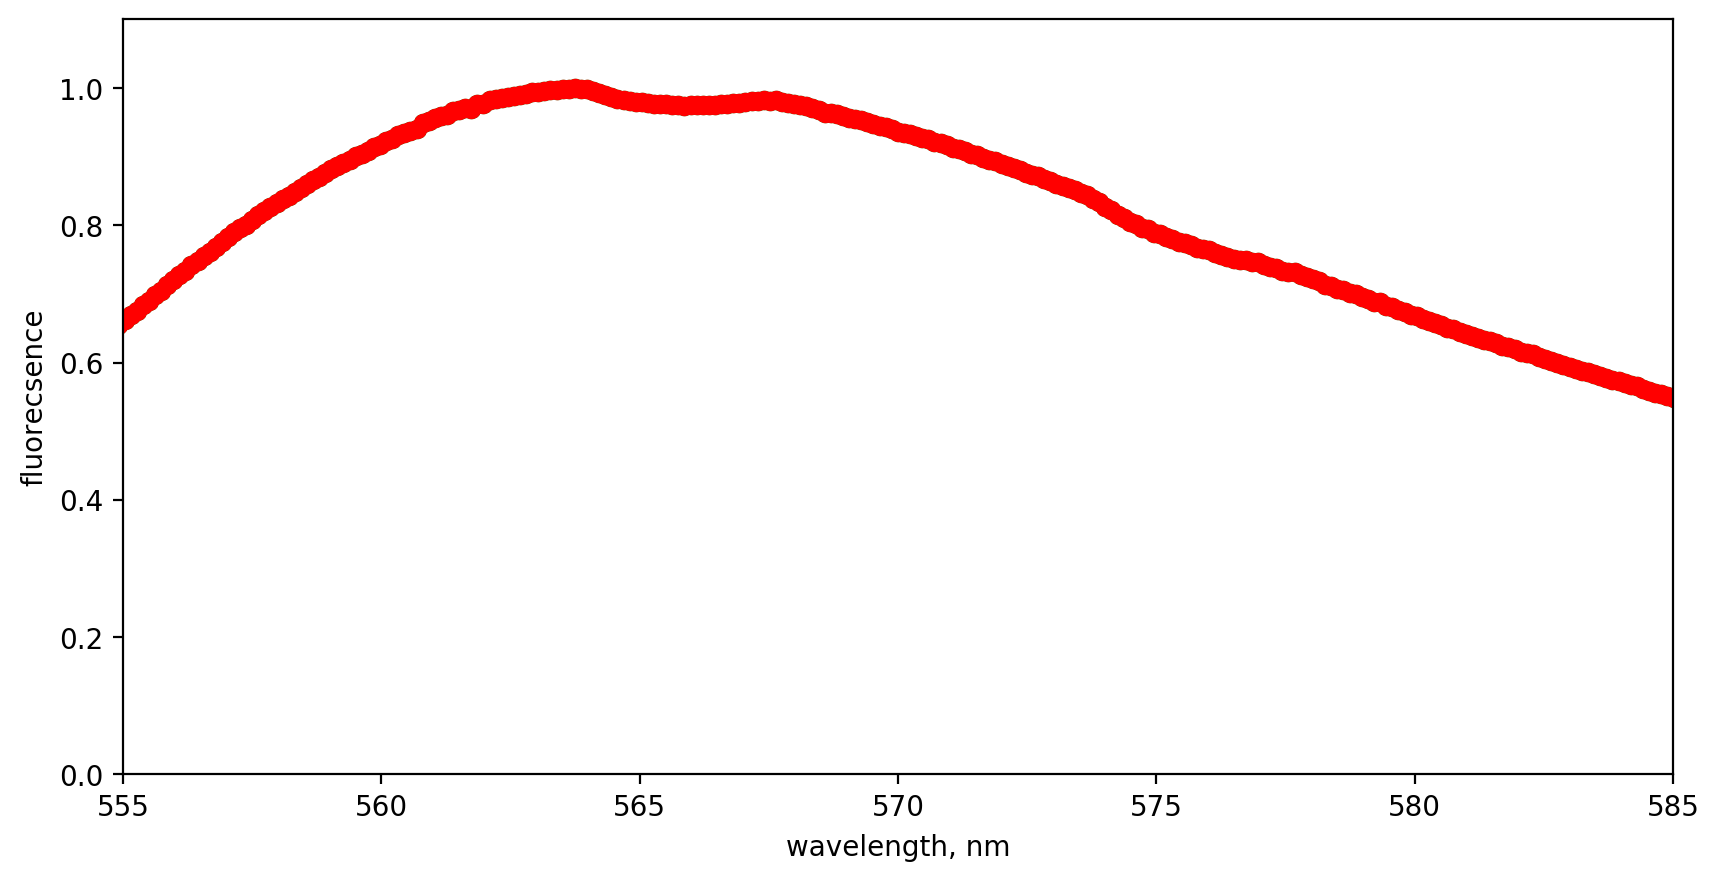

In [16]:
specdata_1 = readSp('r6g/rd6_f_3.csv', ';')
specdata_2 = readSp('r6g/rd6_f_9.csv', ';')

def smooth(x, y, downwl, upwl):
    down = np.where(rangeWl >= downwl)[0][0]
    up = np.where(rangeWl <= upwl)[0][-1]
    ysmooth = savitzky_golay(y[down:up], 101, 3)
    ysmooth = savitzky_golay(y[down:up], 51, 2)
    ysmooth = savitzky_golay(y[down:up], 11, 1)
    yOut = np.copy(y)
    yOut[down:up] = ysmooth
    return yOut


#fluor
#transmition + smooth for pump and 2 strange regions
#specdata2[:,1], specdata2[:,0] = transM(specdata2[:,1]*100, specdata2[:,0], np.genfromtxt('QuartzCuvette.csv', delimiter = '\t'))

#specdata2[:,1] = smooth(specdata2[:,0], specdata2[:,1], 530, 540)
#specdata2[:,1] = smooth(specdata2[:,0], specdata2[:,1], 563, 569)
#specdata2[:,1] = smooth(specdata2[:,0], specdata2[:,1], 573, 577)

#plot
fig, ax = plt.subplots(num=None, figsize=(10, 5), dpi=200, facecolor='w', edgecolor='k')
#ax.plot(xx, yy, linestyle='', marker='o', color='red')

ax.plot(specdata_1[:,0], specdata_1[:,1]/max(specdata_1[:,1]), linestyle='', marker='o', color='green')
yy = smooth(specdata_1[:,0], specdata_1[:,1], 560, 570)
yy = smooth(specdata_1[:,0], yy, 570, 580)

ax.plot(specdata_1[:,0], yy/max(specdata_1[:,1]), linestyle='', marker='o', color='red')


#ax.plot(specdata_2[:,0], specdata_2[:,1]/max(specdata_2[:,1]), linestyle='', marker='o', color='red')
#ax.plot(specdata_2[:,0], specdata_1[:,1]/specdata_2[:,1], linestyle='', marker='o', color='blue')

plt.xlabel('wavelength, nm')
plt.ylabel('fluorecsence')
#ax.plot(specdataE2[:-100,0], specdataE2[:-100,1]/max(specdataE2[:,1]), linestyle='', marker='o', color='red')

plt.xlim(555, 585)
plt.ylim(0, 1.1)

plt.show()


569.9988403

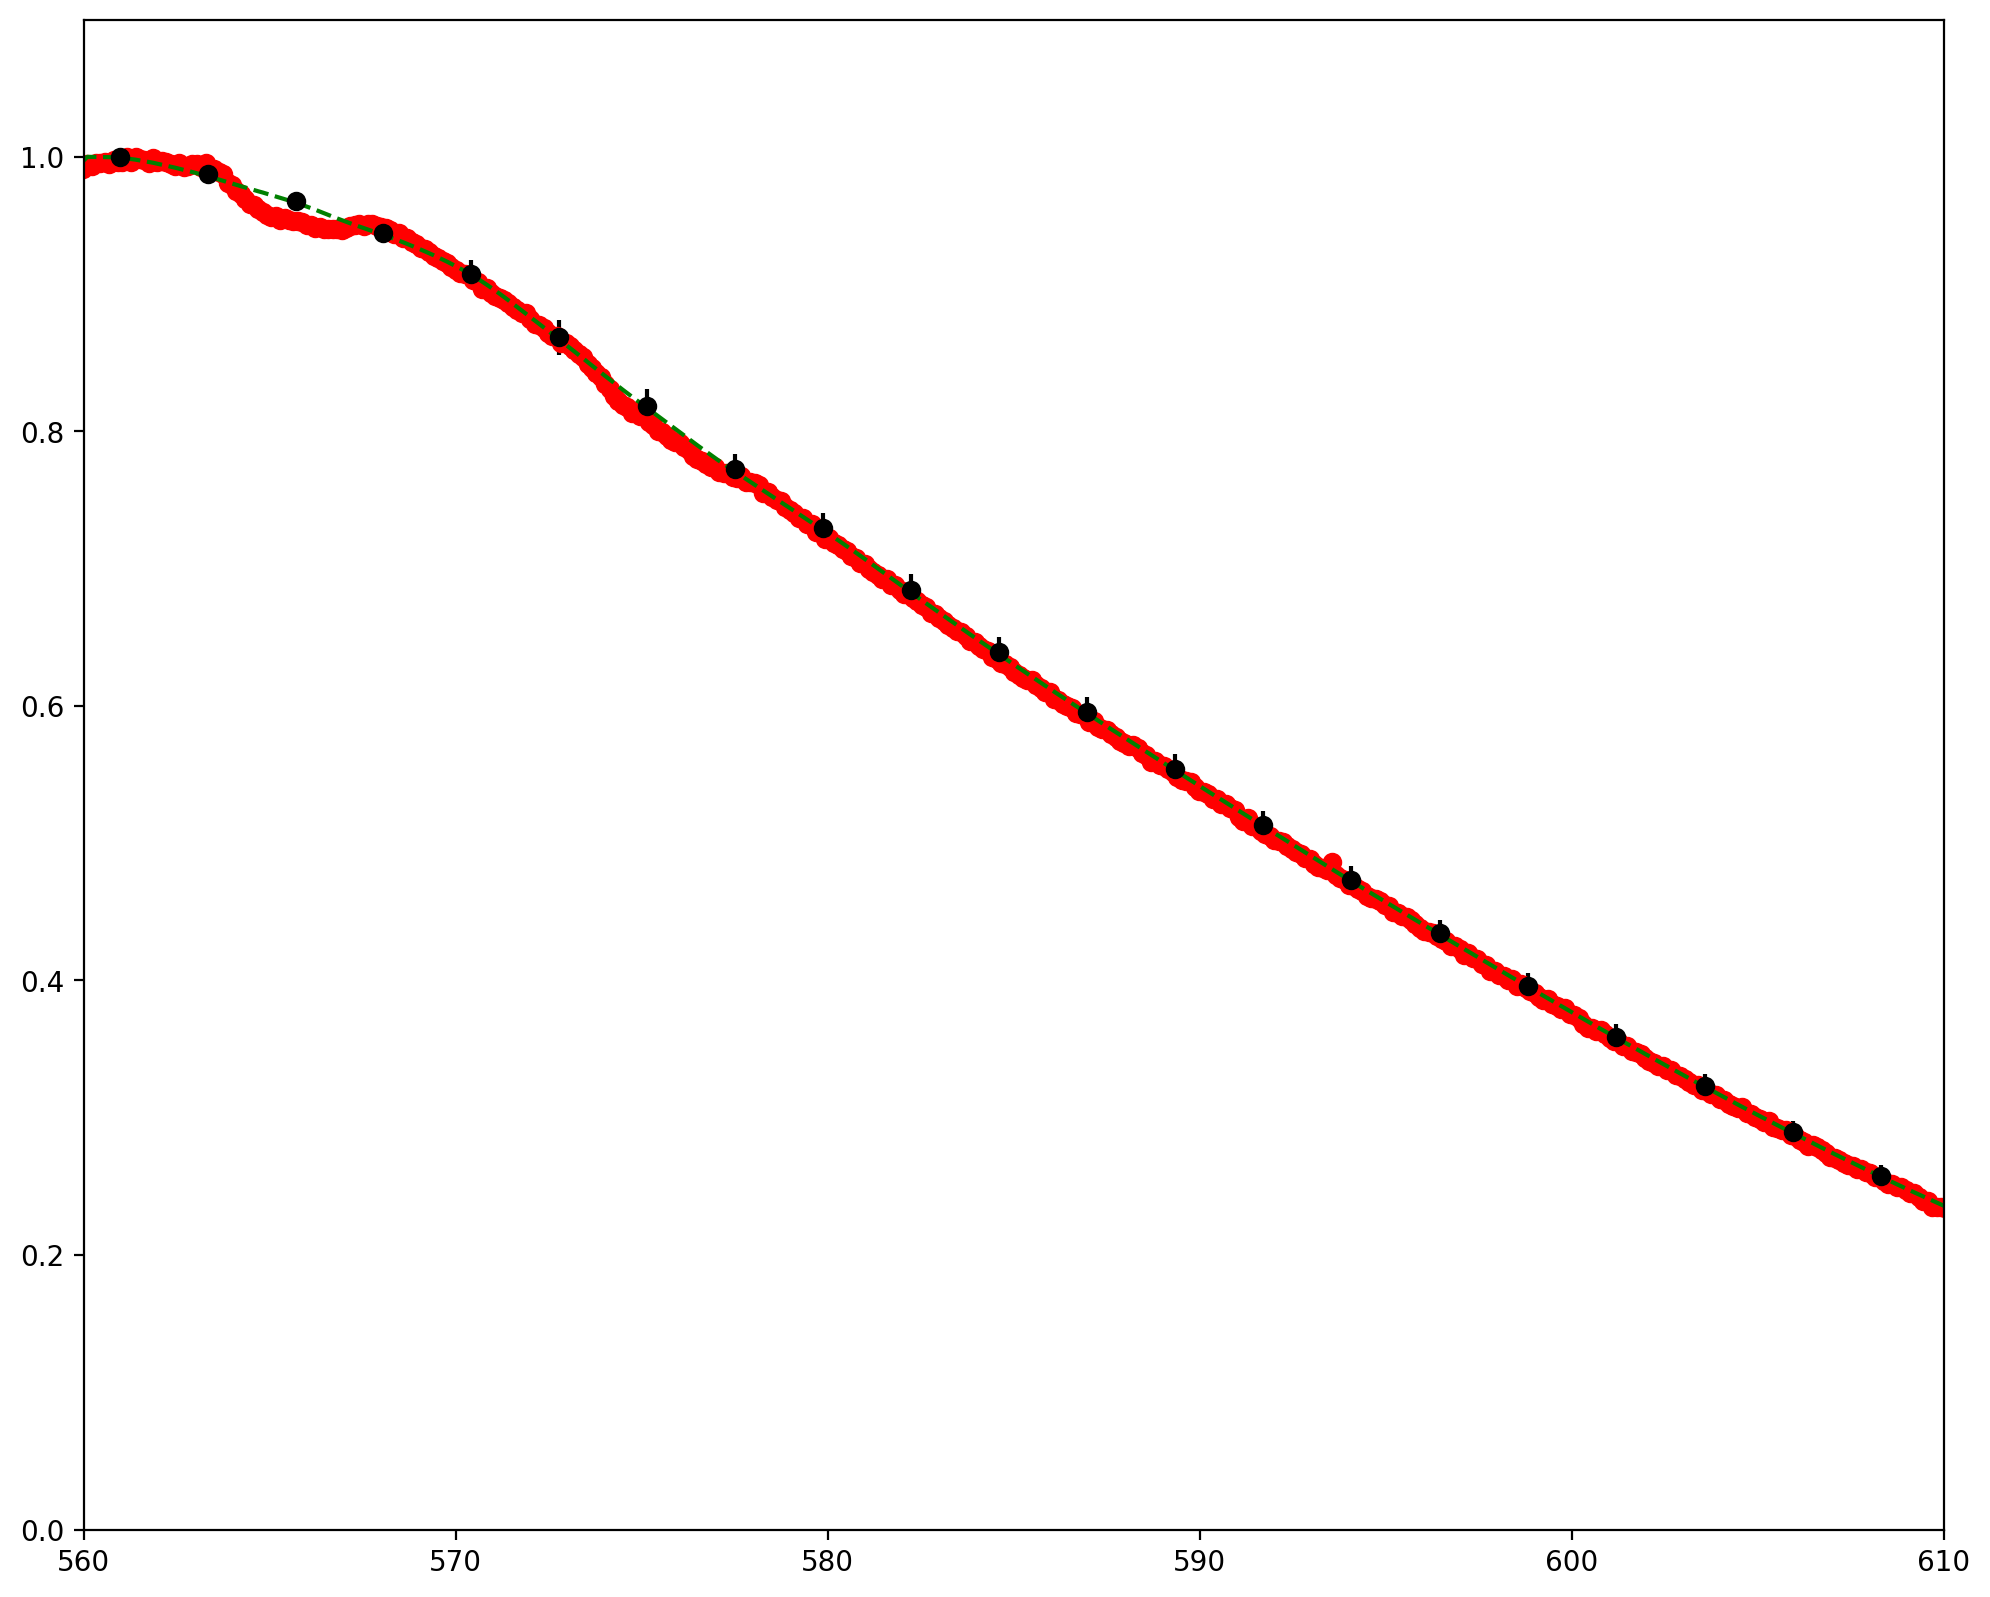

In [60]:
def smooth(x, y, downwl, upwl):
    down = np.where(x >= downwl)[0][0]
    up = np.where(x <= upwl)[0][-1]
    #ysmooth = savitzky_golay(y[down:up], 101, 3)
    #ysmooth = savitzky_golay(y[down:up], 81, 2)
    ysmooth = savitzky_golay(y[down:up], 51, 1)
    yOut = np.copy(y)
    yOut[down:up] = ysmooth
    return yOut

def func(x, a, b, c, d):
    return a + b * x + c * x **2 + d * x ** 3


sp2 = readSp('qd1AnotherSpectrom/qd1_f_1x25.csv', ';')

sp1 = readSp('qd1/qd1_f_1x25.csv', ';')
fig, ax = plt.subplots(num=None, figsize=(12, 10), dpi=200, facecolor='w', edgecolor='k')
ax.plot(sp1[:,0], sp1[:,1]/max(sp1[:,1]), linestyle='', marker='o', color='red')

dw = np.where(sp1[:,0] >= 560)[0][0]
upw = np.where(sp1[:,0] <= 570)[0][-1]

popt, pcov = curve_fit(func, sp1[dw:upw,0], sp1[dw:upw,1])
y1 = func(sp1[:,0],*popt)

sp1[:, 1] = np.copy(smooth(sp1[:, 0], sp1[:, 1], 560, 620))
x, y, err = avgPlot(sp1[:, 0], sp1[:, 1], 20)
#y[102] = y[102] / 0.98

ax.plot(sp1[:,0], sp1[:,1]/max(sp1[:,1]), linestyle='--', marker='', color='green')
ax.errorbar(x, y/max(y) , yerr=err, linestyle='', marker='o', color='black')
#ax.plot(sp1[:,0], y1/max(sp1[:,1]), linestyle='', marker='o', color='green')

#ax.plot(sp2[:,0], sp2[:,1]/max(sp2[:,1]), linestyle='', marker='o', color='green')
#plt.xlim(520, 620)
plt.xlim(560, 610)

plt.ylim(0, 1.1)
np.where(x >= 565)[0][0]
sp1[50, 0] - sp1[0, 0]
sp1[upw, 0]
 

In [16]:
#absorption and reabsorption

specdata1 = readSp('qd1/qd1_a_1x25.csv', ';')
specdata = readSp('qd1/qd1_ode_1x25.csv', delimiter = ';')
specdata2 = readSp('qd1/qd1_f_1x25_reabsorb_1.csv', ';')

wl1, temp22, err2 = stepaTemp1(specdata1, specdata, specdata2)
fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=200, facecolor='w', edgecolor='k')
ax.errorbar(wl1, temp22, yerr=err2, fmt='-o', linestyle='', color='red')

FileNotFoundError: [Errno 2] No such file or directory: 'qd1/qd1_a_1x25.csv'

In [31]:
#take absorption coeff
def takeAbs(specdata1, specdata):    
    absorp = np.log(specdata[:,1]/specdata1[:,1]) / 2
    cutwl = np.where(specdata[:,0] >= 532)[0][0]
    return absorp[cutwl]

In [40]:
specdata1 = readSp('MIT_qd1/qd1_byOffset_2/5.csv', ';')
specdata = readSp('MIT_qd1/qd1_byOffset_2/1.csv', delimiter = ';')
abso = takeAbs(specdata1, specdata)

specdata1 = readSp('MIT_qd1/qd1_byOffset_2/4.csv', ';')
specdata = readSp('MIT_qd1/qd1_byOffset_2/1.csv', delimiter = ';')
abso1 = takeAbs(specdata1, specdata)

specdata1 = readSp('MIT_qd1/qd1_byOffset_2/3.csv', ';')
abso2 = takeAbs(specdata1, specdata)

specdata1 = readSp('MIT_qd1/qd1_byOffset_2/2.csv', ';')
abso3 = takeAbs(specdata1, specdata)
print(abso, abso1, abso2, abso3)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


0.1474725184753602 0.2828571711489254 0.7979389567522013 1.4493055706068958


In [38]:
specdata1 = readSp('r6g/rd6_a_8.csv', ';')
specdata = readSp('r6g/rd6_ethGl_8.csv', delimiter = ';')
abso = takeAbs(specdata1, specdata)
abso

0.028615956162062414

In [44]:
def takeDiff(specdata1, specdata):    
    absorp = (specdata[:,1] - specdata1[:,1]) 
    cutwl = np.where(specdata[:,0] >= 532)[0][0]
    return absorp[cutwl]

In [45]:
specdata1 = readSp('MIT_qd1/qd1_byOffset_2/5.csv', ';')
specdata = readSp('MIT_qd1/qd1_byOffset_2/1.csv', delimiter = ';')
abso = takeDiff(specdata1, specdata)

specdata1 = readSp('MIT_qd1/qd1_byOffset_2/4.csv', ';')
specdata = readSp('MIT_qd1/qd1_byOffset_2/1.csv', delimiter = ';')
abso1 = takeDiff(specdata1, specdata)

specdata1 = readSp('MIT_qd1/qd1_byOffset_2/3.csv', ';')
abso2 = takeDiff(specdata1, specdata)

specdata1 = readSp('MIT_qd1/qd1_byOffset_2/2.csv', ';')
abso3 = takeDiff(specdata1, specdata)
print(abso, abso1, abso2, abso3)

0.07753127810000002 0.13114115590000003 0.24199950321000002 0.2868106663


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


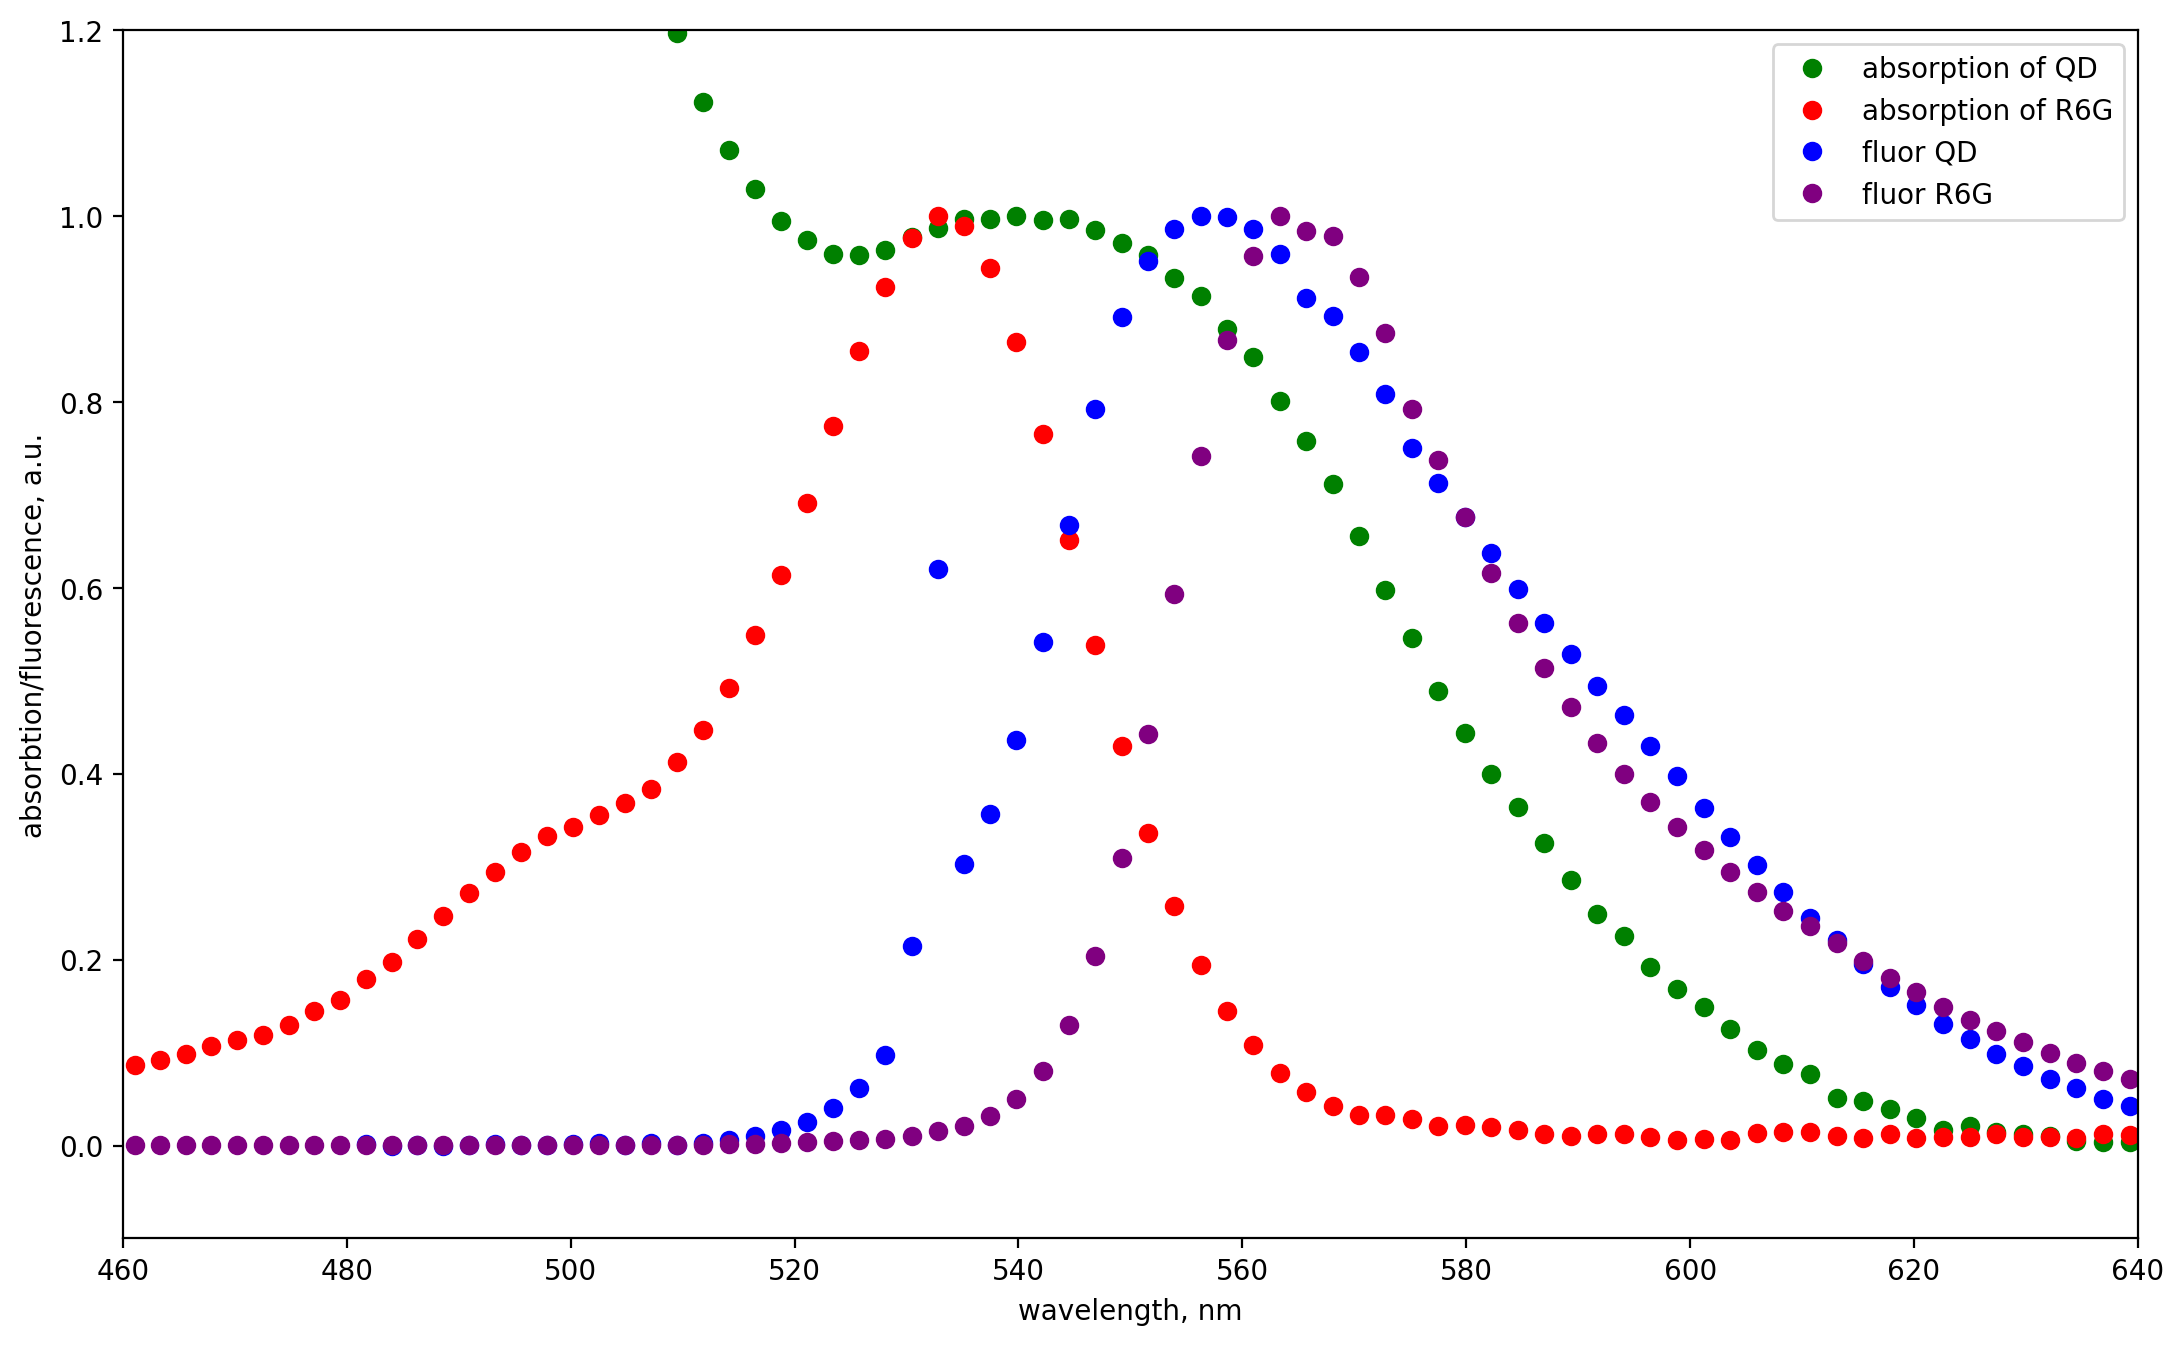

max absorption of QD 539.821490475
max absorption of R6G 532.7939910800001
max fluor of QD 556.266864025
max fluor of R6G 563.334072885
absorption at 580 for QD 0.3993833007607888
absorption at 580 for R6G 0.02023067356246746


In [56]:
#comparison
specdata1_ = readSp('r6g/rd6_a_18.csv', ';')
specdata_ = readSp('r6g/rd6_ethGl_18.csv', delimiter = ';')
specdata2_ = readSp('r6g/rd6_f_3.csv', ';')

specdata1 = readSp('MIT_qd1/qd1_byOffset_2/2.csv', ';')
specdata = readSp('MIT_qd1/qd1_byOffset_2/1.csv', delimiter = ';')
specdata2 = readSp('MIT_qd1/qd1/qd1_f_1x100.csv', ';')
rangeWl = np.copy(specdata2[:,0])
specFlur = np.copy(specdata2[:,1])
#cutting all less x
cutwl = np.where(rangeWl >= 480)[0][0]
specdata = np.copy(specdata[cutwl:])
specdata1 = np.copy(specdata1[cutwl:])
specdata2 = np.copy(specdata2[cutwl:])


#cutting all more than x

cutwl = np.where(rangeWl <= 600)[0][-1]
specdata = np.copy(specdata[:cutwl])
specdata1 = np.copy(specdata1[:cutwl])
specdata2 = np.copy(specdata2[:cutwl])
rangeWl = np.copy(specdata2[:,0])

#absorption
#yy, xx = transM(specdata2[:,1]*100, specdata2[:,0], np.genfromtxt('QuartzCuvette.csv', delimiter = '\t'))
fig, ax = plt.subplots(num=None, figsize=(13, 8), dpi=200, facecolor='w', edgecolor='k')
#ax.plot(specdata[:,0], specdata[:,1], linestyle='', marker='o', color='green')
#ax.plot(specdata1[:,0], specdata1[:,1], linestyle='', marker='o', color='red')
#ax.plot(specdata1[:,0], np.log(specdata[:,1]/specdata1[:,1]) / 0.002 , linestyle='', marker='o', color='blue')
#coef = (specdata[:,1] - specdata1[:,1]) / (1 * 0.2 * 1e3)

abswl, absy, abserr = avgPlot(specdata2[:, 0], np.log(specdata[:,1]/specdata1[:,1]), 20)

ax.plot(abswl, absy / max(absy[ np.where(abswl >= 520)[0][0]:]), 
        linestyle='', marker='o', color='green')

abswl_, absy_, abserr_ = avgPlot(specdata2_[:, 0], np.log(specdata_[:,1]/specdata1_[:,1]), 20)
ax.plot(abswl_, absy_/max(absy_)
        , linestyle='', marker='o', color='red')

fwl, fy, ferr = avgPlot(specdata2[:, 0], specdata2[:, 1], 20)

ax.plot(fwl, fy/max(fy), 
        linestyle='', marker='o', color='blue')

fwl_, fy_, ferr_ = avgPlot(specdata2_[:, 0], specdata2_[:, 1], 20)

ax.plot(fwl_, fy_/max(fy_), 
        linestyle='', marker='o', color='purple')
#ax.plot(specdata1[:,0], (specdata[:,1] - specdata1[:,1]) , linestyle='', marker='o', color='blue')
#ax.plot(specdata1[:,0], specdata[:,1], linestyle='', marker='o', color='red')
#ax.plot(specdata1[:,0], specdata1[:,1], linestyle='', marker='o', color='blue')


plt.xlabel('wavelength, nm')
plt.ylabel('absorbtion/fluorescence, a.u.')
plt.ylim(-0.1,1.2)
plt.xlim(460, 640)
#plt.ylim(0,130)
plt.legend(('absorption of QD', 'absorption of R6G', 'fluor QD', 'fluor R6G'))
plt.show()
print('max absorption of QD', abswl[np.where(absy == max(absy[ np.where(abswl >= 520)[0][0]:]))[0][0]])
print('max absorption of R6G',abswl_[np.where(absy_ == max(absy_[ np.where(abswl_ >= 520)[0][0]:]))[0][0]])
print('max fluor of QD',fwl[np.where(fy == max(fy))[0][0]])
print('max fluor of R6G',fwl_[np.where(fy_ == max(fy_))[0][0]])

print('absorption at 580 for QD', absy[np.where(abswl >= 580)[0][0]]/ max(absy[ np.where(abswl >= 520)[0][0]:]))
print('absorption at 580 for R6G', absy_[np.where(abswl_ >= 580)[0][0]]/ max(absy_[ np.where(abswl_ >= 520)[0][0]:]))

#print('max fluorescence wl', specdata2[np.where(specdata2[:,1] == max(specdata2[:,1]))[0][0],0])
#print('max absorption wl', specdata[np.where(np.log(specdata[:,1]/specdata1[:,1]) == max(np.log(specdata[:,1]/specdata1[:,1])))[0][0],0])

